In [1]:
from mcmc import mcmc_run, get_adsorption_coords

from ase.calculators.lammpsrun import LAMMPS
from ase.io import read

from catkit.gen.adsorption import get_adsorption_sites

import catkit

import os
import numpy as np

import sys
sys.path.append("/home/dux/")
from htvs.djangochem.pgmols.utils import surfaces

In [2]:
from time import perf_counter

start = perf_counter()
num_runs = 100

# use LAMMPS
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Au_u3.eam']
}

potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Au_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=True, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

# Au from standard cell
atoms = read('Au_mp-81_conventional_standard.cif')
slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])

coords, connectivity, sym_idx = get_adsorption_sites(slab, symmetry_reduced=False)

element = 'Au'
metal = catkit.gratoms.Gratoms(element)

ads_coords = get_adsorption_coords(slab, metal, connectivity)

/home/dux/.local/lib/python3.9/site-packages/catkit/gen/surface.py:334: UserWarning: Your slab has no bulk atoms and may be too thin to identify surface atoms correctly. This may cause surface adsorption site identification to fail.
  warnings.warn(
/home/dux/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = n

In [3]:
all_adsorbed = read("Au_110_all_adsorbed_slab.cif")
assert len(all_adsorbed) == len(slab) + len(ads_coords)

Manually removed some atoms

In [4]:
proper_adsorbed = read("Au_110_proper_adsorbed_slab.cif")
ads_positions = proper_adsorbed.get_positions()[len(slab):]

In [7]:
ads_positions.shape

(32, 3)

In [5]:
len(ads_positions)

32

In [6]:
slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])

element = 'Au'
num_ads_atoms = 16 + 8 # for canonical runs
alpha = 0.99
num_runs = 300

history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=alpha, slab=slab, calc=lammps_calc, element=element, canonical=True, num_ads_atoms=num_ads_atoms, ads_coords=ads_positions)

INFO:Running with num_runs = 300, temp = 1, pot = 0, alpha = 0.99
INFO:there are 64 atoms 
INFO:using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f321d58db80>
INFO:In pristine slab, there are a total of 32 sites
/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/ase/calculators/lammpsrun.py:379: UserWarning: semi-periodic ASE cell detected - translation to proper LAMMPS input cell might fail
  warnings.warn(
INFO:running for 32 iterations per run over a total of 300 runs
INFO:adsorbate is Au
INFO:In sweep 1 out of 300
INFO:In sweep 2 out of 300
INFO:In sweep 3 out of 300
INFO:In sweep 4 out of 300
INFO:In sweep 5 out of 300
INFO:In sweep 6 out of 300
INFO:In sweep 7 out of 300
INFO:In sweep 8 out of 300
INFO:In sweep 9 out of 300
INFO:In sweep 10 out of 300
INFO:In sweep 11 out of 300
INFO:In sweep 12 out of 300
INFO:In sweep 13 out of 300
INFO:In sweep 14 out of 300
INFO:In sweep 15 out of 300
INFO:In sweep 16 out of 300
INFO:In sweep 17 out of 300
INFO:In sweep 

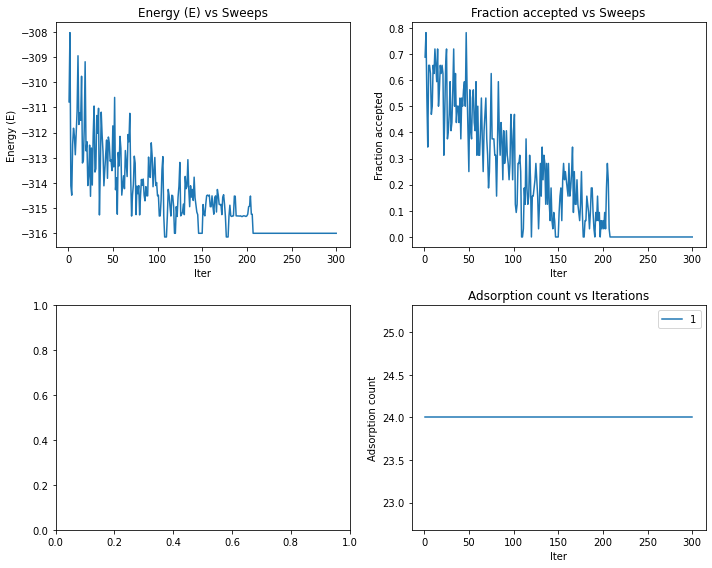

In [7]:
import matplotlib.pyplot as plt
runs = range(1, num_runs+1)
# do the plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Sweeps")

ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Sweeps")

ax[1, 1].plot(runs, np.array(list(adsorption_count_hist.values())).T)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].legend(adsorption_count_hist.keys())
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()

In [8]:
from mcmc import mcmc_run, slab_energy

# calculated energy of desorbed rows (2 adjacent rows removed)
aligned_sites = read("Au_canonical_aligned_sites_300_iter.cif")
aligned_sites.calc = lammps_calc
print(f"aligned sites slab energy is {slab_energy(aligned_sites)}")

# non aligned sites (a lot more possibilites)
nonaligned_sites = read("Au_canonical_nonaligned_sites_300_iter.cif")
nonaligned_sites.calc = lammps_calc
print(f"nonaligned sites slab energy is {slab_energy(nonaligned_sites)}")


aligned sites slab energy is -316.1376632572531
nonaligned sites slab energy is -316.0347337124226


Try with relaxation

In [9]:
slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])

element = 'Au'
num_ads_atoms = 16 + 8 # for canonical runs
alpha = 0.99
num_runs = 300

history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=alpha, slab=slab, calc=lammps_calc, element=element, canonical=True, num_ads_atoms=num_ads_atoms, ads_coords=ads_positions, relax=True)

/home/dux/.local/lib/python3.9/site-packages/catkit/gen/surface.py:334: UserWarning: Your slab has no bulk atoms and may be too thin to identify surface atoms correctly. This may cause surface adsorption site identification to fail.
  warnings.warn(
INFO:Running with num_runs = 300, temp = 1, pot = 0, alpha = 0.99
INFO:there are 64 atoms 
INFO:using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f321d58db80>
/home/dux/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tu

      Step     Time          Energy         fmax
BFGS:    0 17:33:42     -223.525316        1.2683
BFGS:    1 17:33:42     -223.547736        1.2065
BFGS:    2 17:33:42     -223.697990        0.2572
BFGS:    3 17:33:42     -223.703556        0.0566
      Step     Time          Energy         fmax
BFGS:    0 17:33:42     -227.370428        1.2404
BFGS:    1 17:33:42     -227.413319        1.1799
BFGS:    2 17:33:42     -227.702991        0.2346
BFGS:    3 17:33:42     -227.712039        0.0742
      Step     Time          Energy         fmax
BFGS:    0 17:33:42     -229.031893        1.5294
BFGS:    1 17:33:42     -229.107700        1.5210
BFGS:    2 17:33:42     -229.653907        1.3579
BFGS:    3 17:33:42     -229.919832        1.0930
BFGS:    4 17:33:42     -229.967857        0.9557
BFGS:    5 17:33:42     -230.010707        0.8463
BFGS:    6 17:33:42     -230.070354        0.8582
BFGS:    7 17:33:43     -230.146129        0.4962
BFGS:    8 17:33:43     -230.186233        0.2150
BFG

INFO:running for 32 iterations per run over a total of 300 runs
INFO:adsorbate is Au
INFO:In sweep 1 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:33:54     -312.072991        1.5231
BFGS:    1 17:33:54     -312.315347        1.4604
BFGS:    2 17:33:55     -313.738743        0.6602
BFGS:    3 17:33:55     -313.854089        0.2501
BFGS:    4 17:33:55     -313.865461        0.2293
BFGS:    5 17:33:55     -313.873604        0.2406
BFGS:    6 17:33:55     -313.899661        0.2107
BFGS:    7 17:33:55     -313.914674        0.1656
      Step     Time          Energy         fmax
BFGS:    0 17:33:55     -313.235752        1.5229
BFGS:    1 17:33:55     -313.472187        1.4597
BFGS:    2 17:33:55     -314.826462        0.6455
BFGS:    3 17:33:55     -314.921521        0.1847
      Step     Time          Energy         fmax
BFGS:    0 17:33:55     -312.985802        1.4792
BFGS:    1 17:33:55     -313.242308        1.4074
BFGS:    2 17:33:55     -314.691269        0.5878
BFGS:    3 17:33:55     -314.746889        0.4036
BFGS:    4 17:33:55     -314.756386        0.3403
BFG

INFO:In sweep 2 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:33:59     -313.891483        1.3190
BFGS:    1 17:33:59     -314.100854        1.2440
BFGS:    2 17:33:59     -315.305067        0.1984
      Step     Time          Energy         fmax
BFGS:    0 17:33:59     -313.844670        1.3301
BFGS:    1 17:33:59     -314.052017        1.2698
BFGS:    2 17:33:59     -315.256581        0.3346
BFGS:    3 17:33:59     -315.270536        0.2397
BFGS:    4 17:33:59     -315.275644        0.2275
BFGS:    5 17:33:59     -315.312030        0.1701
      Step     Time          Energy         fmax
BFGS:    0 17:33:59     -313.672793        1.5445
BFGS:    1 17:33:59     -313.894135        1.4796
BFGS:    2 17:33:59     -315.135515        0.6409
BFGS:    3 17:33:59     -315.211782        0.3162
BFGS:    4 17:33:59     -315.220024        0.2584
BFGS:    5 17:33:59     -315.227117        0.2516
BFGS:    6 17:33:59     -315.244163        0.2081
BFGS:    7 17:33:59     -315.253597        0.1706
   

INFO:In sweep 3 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:34:04     -313.687135        1.5622
BFGS:    1 17:34:04     -313.912526        1.4957
BFGS:    2 17:34:04     -315.157252        0.6335
BFGS:    3 17:34:04     -315.229321        0.2602
BFGS:    4 17:34:04     -315.237591        0.2319
BFGS:    5 17:34:04     -315.244552        0.2448
BFGS:    6 17:34:04     -315.262920        0.2144
BFGS:    7 17:34:04     -315.274083        0.1600
      Step     Time          Energy         fmax
BFGS:    0 17:34:04     -311.779859        1.5274
BFGS:    1 17:34:04     -312.044242        1.4614
BFGS:    2 17:34:04     -313.605041        0.5918
BFGS:    3 17:34:04     -313.717379        0.3201
BFGS:    4 17:34:04     -313.736798        0.2363
BFGS:    5 17:34:04     -313.745460        0.1954
      Step     Time          Energy         fmax
BFGS:    0 17:34:04     -312.263245        1.3290
BFGS:    1 17:34:04     -312.497818        1.2699
BFGS:    2 17:34:04     -313.912529        0.3427
BFG

INFO:In sweep 4 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:34:08     -312.230105        1.5661
BFGS:    1 17:34:08     -312.513277        1.5047
BFGS:    2 17:34:08     -314.070417        0.6849
BFGS:    3 17:34:08     -314.162627        0.4094
BFGS:    4 17:34:08     -314.175524        0.3305
BFGS:    5 17:34:08     -314.191544        0.3243
BFGS:    6 17:34:08     -314.227144        0.3034
BFGS:    7 17:34:08     -314.253619        0.3079
BFGS:    8 17:34:08     -314.267089        0.2686
BFGS:    9 17:34:08     -314.273616        0.2077
BFGS:   10 17:34:08     -314.281027        0.1770
      Step     Time          Energy         fmax
BFGS:    0 17:34:08     -313.269260        1.4540
BFGS:    1 17:34:09     -313.525119        1.3819
BFGS:    2 17:34:09     -314.953492        0.4066
BFGS:    3 17:34:09     -314.996123        0.2349
BFGS:    4 17:34:09     -315.003990        0.2075
BFGS:    5 17:34:09     -315.047636        0.2416
BFGS:    6 17:34:09     -315.074117        0.2083
BF

INFO:In sweep 5 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:34:16     -311.812864        1.3065
BFGS:    1 17:34:16     -312.068742        1.2298
BFGS:    2 17:34:16     -313.588521        0.6638
BFGS:    3 17:34:16     -313.611138        0.5620
BFGS:    4 17:34:16     -313.632643        0.4769
BFGS:    5 17:34:16     -313.706414        0.2097
BFGS:    6 17:34:16     -313.720158        0.2377
BFGS:    7 17:34:16     -313.727614        0.2359
BFGS:    8 17:34:16     -313.732623        0.2281
BFGS:    9 17:34:16     -313.745991        0.2004
BFGS:   10 17:34:16     -313.756700        0.1712
      Step     Time          Energy         fmax
BFGS:    0 17:34:16     -310.105826        1.4457
BFGS:    1 17:34:16     -310.390823        1.3712
BFGS:    2 17:34:16     -312.124403        0.7310
BFGS:    3 17:34:16     -312.230472        0.4854
BFGS:    4 17:34:16     -312.252200        0.4893
BFGS:    5 17:34:16     -312.311089        0.4027
BFGS:    6 17:34:16     -312.360071        0.3178
BF

INFO:In sweep 6 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:34:22     -310.594631        1.5710
BFGS:    1 17:34:22     -310.899020        1.5149
BFGS:    2 17:34:22     -312.647257        0.7252
BFGS:    3 17:34:22     -312.788239        0.3844
BFGS:    4 17:34:22     -312.812221        0.2918
BFGS:    5 17:34:22     -312.829050        0.3129
BFGS:    6 17:34:22     -312.891798        0.3246
BFGS:    7 17:34:22     -312.929470        0.2573
BFGS:    8 17:34:22     -312.949302        0.2317
BFGS:    9 17:34:22     -312.958852        0.2642
BFGS:   10 17:34:22     -312.971528        0.2616
BFGS:   11 17:34:22     -312.987533        0.2106
BFGS:   12 17:34:22     -313.002631        0.2100
BFGS:   13 17:34:22     -313.010324        0.1647
      Step     Time          Energy         fmax
BFGS:    0 17:34:22     -310.936941        1.5154
BFGS:    1 17:34:22     -311.247121        1.4595
BFGS:    2 17:34:22     -313.033704        0.6655
BFGS:    3 17:34:22     -313.144472        0.3084
BF

INFO:In sweep 7 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:34:29     -311.173922        1.4713
BFGS:    1 17:34:29     -311.436322        1.4000
BFGS:    2 17:34:29     -312.996797        0.7826
BFGS:    3 17:34:29     -313.099257        0.4967
BFGS:    4 17:34:29     -313.115635        0.5210
BFGS:    5 17:34:29     -313.153977        0.4858
BFGS:    6 17:34:29     -313.204216        0.3834
BFGS:    7 17:34:29     -313.240017        0.3689
BFGS:    8 17:34:29     -313.256402        0.3814
BFGS:    9 17:34:29     -313.269143        0.4032
BFGS:   10 17:34:29     -313.287977        0.3903
BFGS:   11 17:34:29     -313.315280        0.3195
BFGS:   12 17:34:29     -313.341052        0.2476
BFGS:   13 17:34:29     -313.357079        0.2793
BFGS:   14 17:34:29     -313.366079        0.2981
BFGS:   15 17:34:29     -313.379507        0.2937
BFGS:   16 17:34:29     -313.407060        0.3364
BFGS:   17 17:34:29     -313.451295        0.4520
BFGS:   18 17:34:29     -313.496988        0.5846
B

INFO:In sweep 8 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:34:35     -312.071894        1.3061
BFGS:    1 17:34:35     -312.295856        1.2462
BFGS:    2 17:34:35     -313.669161        0.6454
BFGS:    3 17:34:35     -313.700470        0.4975
BFGS:    4 17:34:35     -313.712422        0.4682
BFGS:    5 17:34:35     -313.788299        0.2812
BFGS:    6 17:34:35     -313.791155        0.2466
BFGS:    7 17:34:35     -313.803327        0.1824
      Step     Time          Energy         fmax
BFGS:    0 17:34:35     -312.200295        1.5005
BFGS:    1 17:34:35     -312.450612        1.4351
BFGS:    2 17:34:35     -313.887166        0.5791
BFGS:    3 17:34:35     -313.961918        0.3578
BFGS:    4 17:34:35     -313.973478        0.2528
BFGS:    5 17:34:35     -313.987208        0.2297
BFGS:    6 17:34:35     -314.011155        0.2292
BFGS:    7 17:34:35     -314.024814        0.2455
BFGS:    8 17:34:35     -314.031421        0.2071
BFGS:    9 17:34:35     -314.036531        0.1674
  

INFO:In sweep 9 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:34:40     -311.222761        1.7260
BFGS:    1 17:34:40     -311.513100        1.6806
BFGS:    2 17:34:40     -313.095748        1.0102
BFGS:    3 17:34:40     -313.301637        0.6187
BFGS:    4 17:34:40     -313.334897        0.4279
BFGS:    5 17:34:40     -313.350454        0.4285
BFGS:    6 17:34:40     -313.454946        0.3145
BFGS:    7 17:34:40     -313.470231        0.2735
BFGS:    8 17:34:40     -313.478912        0.2177
BFGS:    9 17:34:40     -313.486933        0.2536
BFGS:   10 17:34:40     -313.501445        0.2706
BFGS:   11 17:34:40     -313.512839        0.2267
BFGS:   12 17:34:40     -313.519534        0.1625
      Step     Time          Energy         fmax
BFGS:    0 17:34:40     -312.196628        1.4612
BFGS:    1 17:34:40     -312.456120        1.3924
BFGS:    2 17:34:40     -313.967912        0.5303
BFGS:    3 17:34:40     -314.041713        0.3136
BFGS:    4 17:34:40     -314.051340        0.2640
BF

INFO:In sweep 10 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:34:47     -314.524726        1.3176
BFGS:    1 17:34:47     -314.741625        1.2425
BFGS:    2 17:34:47     -315.913105        0.2284
BFGS:    3 17:34:47     -315.917894        0.2184
BFGS:    4 17:34:47     -315.954701        0.1270
      Step     Time          Energy         fmax
BFGS:    0 17:34:47     -313.054659        1.5242
BFGS:    1 17:34:47     -313.323289        1.4468
BFGS:    2 17:34:47     -314.774344        0.3607
BFGS:    3 17:34:47     -314.814795        0.3855
BFGS:    4 17:34:47     -314.823123        0.3333
BFGS:    5 17:34:47     -314.847739        0.2170
BFGS:    6 17:34:47     -314.869966        0.2855
BFGS:    7 17:34:47     -314.882025        0.2710
BFGS:    8 17:34:47     -314.887047        0.2162
BFGS:    9 17:34:47     -314.891674        0.1489
      Step     Time          Energy         fmax
BFGS:    0 17:34:47     -314.507160        1.3687
BFGS:    1 17:34:48     -314.723449        1.2929
BFG

INFO:In sweep 11 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:34:52     -312.388547        1.7165
BFGS:    1 17:34:52     -312.666643        1.6602
BFGS:    2 17:34:52     -314.150577        0.9259
BFGS:    3 17:34:52     -314.325345        0.3989
BFGS:    4 17:34:52     -314.343670        0.3698
BFGS:    5 17:34:52     -314.354981        0.3718
BFGS:    6 17:34:52     -314.399101        0.2407
BFGS:    7 17:34:52     -314.415879        0.2437
BFGS:    8 17:34:52     -314.424599        0.2213
BFGS:    9 17:34:52     -314.432811        0.2166
BFGS:   10 17:34:52     -314.443238        0.2268
BFGS:   11 17:34:52     -314.453562        0.1800
      Step     Time          Energy         fmax
BFGS:    0 17:34:52     -310.120285        1.6416
BFGS:    1 17:34:52     -310.421639        1.5913
BFGS:    2 17:34:52     -312.157871        0.8817
BFGS:    3 17:34:52     -312.372417        0.5311
BFGS:    4 17:34:52     -312.405843        0.3687
BFGS:    5 17:34:52     -312.420934        0.3280
BF

INFO:In sweep 12 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:34:58     -309.524064        1.6697
BFGS:    1 17:34:58     -309.839720        1.5995
BFGS:    2 17:34:58     -311.621498        0.6791
BFGS:    3 17:34:58     -311.820887        0.4570
BFGS:    4 17:34:58     -311.850268        0.2771
BFGS:    5 17:34:58     -311.863353        0.2756
BFGS:    6 17:34:58     -311.927054        0.3196
BFGS:    7 17:34:58     -311.944835        0.3102
BFGS:    8 17:34:58     -311.955626        0.2536
BFGS:    9 17:34:58     -311.967312        0.2163
BFGS:   10 17:34:58     -311.984851        0.1876
      Step     Time          Energy         fmax
BFGS:    0 17:34:58     -307.868568        1.6282
BFGS:    1 17:34:58     -308.194584        1.5649
BFGS:    2 17:34:58     -310.129427        0.8013
BFGS:    3 17:34:58     -310.397651        0.5336
BFGS:    4 17:34:58     -310.439031        0.4654
BFGS:    5 17:34:58     -310.458803        0.4416
BFGS:    6 17:34:58     -310.551770        0.3095
BF

INFO:In sweep 13 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:35:05     -311.006045        1.4746
BFGS:    1 17:35:05     -311.293296        1.4042
BFGS:    2 17:35:05     -312.981709        0.7858
BFGS:    3 17:35:05     -313.092107        0.5116
BFGS:    4 17:35:05     -313.112793        0.5282
BFGS:    5 17:35:05     -313.179274        0.4658
BFGS:    6 17:35:05     -313.245689        0.3601
BFGS:    7 17:35:05     -313.289382        0.3662
BFGS:    8 17:35:05     -313.308477        0.4191
BFGS:    9 17:35:05     -313.326576        0.4385
BFGS:   10 17:35:05     -313.352545        0.4003
BFGS:   11 17:35:05     -313.385426        0.2803
BFGS:   12 17:35:05     -313.409741        0.1963
      Step     Time          Energy         fmax
BFGS:    0 17:35:05     -310.817855        1.5273
BFGS:    1 17:35:05     -311.112566        1.4544
BFGS:    2 17:35:05     -312.803894        0.4960
BFGS:    3 17:35:06     -312.906685        0.4326
BFGS:    4 17:35:06     -312.923946        0.3567
BF

INFO:In sweep 14 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:35:12     -309.240816        1.4703
BFGS:    1 17:35:12     -309.539870        1.4095
BFGS:    2 17:35:12     -311.405098        0.7591
BFGS:    3 17:35:12     -311.577391        0.3701
BFGS:    4 17:35:12     -311.598805        0.4311
BFGS:    5 17:35:12     -311.615988        0.4182
BFGS:    6 17:35:12     -311.666766        0.3081
BFGS:    7 17:35:12     -311.696525        0.2732
BFGS:    8 17:35:12     -311.712906        0.3317
BFGS:    9 17:35:12     -311.722181        0.3606
BFGS:   10 17:35:12     -311.739140        0.3663
BFGS:   11 17:35:12     -311.760670        0.3173
BFGS:   12 17:35:12     -311.781487        0.2259
BFGS:   13 17:35:12     -311.792522        0.1878
      Step     Time          Energy         fmax
BFGS:    0 17:35:13     -309.796481        1.5136
BFGS:    1 17:35:13     -310.073601        1.4588
BFGS:    2 17:35:13     -311.784306        0.7237
BFGS:    3 17:35:13     -311.967566        0.5123
BF

INFO:In sweep 15 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:35:19     -309.545916        1.7559
BFGS:    1 17:35:19     -309.837226        1.6861
BFGS:    2 17:35:19     -311.454694        0.7082
BFGS:    3 17:35:19     -311.682727        0.7829
BFGS:    4 17:35:19     -311.724203        0.5162
BFGS:    5 17:35:19     -311.740106        0.4302
BFGS:    6 17:35:19     -311.796216        0.2680
BFGS:    7 17:35:19     -311.801219        0.2493
BFGS:    8 17:35:19     -311.805598        0.1956
      Step     Time          Energy         fmax
BFGS:    0 17:35:19     -308.906688        1.6005
BFGS:    1 17:35:19     -309.196087        1.5398
BFGS:    2 17:35:19     -310.949573        0.7917
BFGS:    3 17:35:19     -311.197982        0.7955
BFGS:    4 17:35:19     -311.240797        0.5392
BFGS:    5 17:35:19     -311.264136        0.4524
BFGS:    6 17:35:19     -311.360597        0.3303
BFGS:    7 17:35:19     -311.382570        0.3414
BFGS:    8 17:35:19     -311.394403        0.2805
BF

INFO:In sweep 16 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:35:28     -308.036640        1.7814
BFGS:    1 17:35:28     -308.368949        1.7155
BFGS:    2 17:35:28     -310.227988        0.9172
BFGS:    3 17:35:28     -310.577837        0.5524
BFGS:    4 17:35:28     -310.632860        0.5262
BFGS:    5 17:35:28     -310.657391        0.5069
BFGS:    6 17:35:28     -310.793310        0.4170
BFGS:    7 17:35:28     -310.814342        0.3865
BFGS:    8 17:35:28     -310.834061        0.4177
BFGS:    9 17:35:28     -310.859687        0.4612
BFGS:   10 17:35:28     -310.897741        0.4175
BFGS:   11 17:35:28     -310.929788        0.3797
BFGS:   12 17:35:28     -310.947616        0.3297
BFGS:   13 17:35:28     -310.955919        0.2606
BFGS:   14 17:35:28     -310.966855        0.1933
      Step     Time          Energy         fmax
BFGS:    0 17:35:28     -307.704042        1.7862
BFGS:    1 17:35:28     -308.027687        1.7470
BFGS:    2 17:35:28     -309.859754        1.1740
BF

INFO:In sweep 17 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:35:35     -312.961421        1.4921
BFGS:    1 17:35:35     -313.198585        1.4261
BFGS:    2 17:35:35     -314.565936        0.5479
BFGS:    3 17:35:35     -314.627191        0.3082
BFGS:    4 17:35:35     -314.636846        0.2500
BFGS:    5 17:35:35     -314.646089        0.2247
BFGS:    6 17:35:35     -314.665879        0.2095
BFGS:    7 17:35:35     -314.678218        0.1664
      Step     Time          Energy         fmax
BFGS:    0 17:35:35     -312.761829        1.4898
BFGS:    1 17:35:35     -313.011091        1.4239
BFGS:    2 17:35:35     -314.414609        0.5194
BFGS:    3 17:35:35     -314.470393        0.2456
BFGS:    4 17:35:35     -314.480127        0.2277
BFGS:    5 17:35:35     -314.501327        0.2380
BFGS:    6 17:35:35     -314.531750        0.2005
BFGS:    7 17:35:35     -314.554554        0.1972
      Step     Time          Energy         fmax
BFGS:    0 17:35:35     -313.181653        1.4694
BFG

INFO:In sweep 18 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:35:40     -310.021888        1.6287
BFGS:    1 17:35:40     -310.293669        1.5763
BFGS:    2 17:35:40     -311.880099        0.8322
BFGS:    3 17:35:40     -312.086885        0.4037
BFGS:    4 17:35:40     -312.112460        0.2730
BFGS:    5 17:35:40     -312.121059        0.2563
BFGS:    6 17:35:40     -312.186651        0.1971
      Step     Time          Energy         fmax
BFGS:    0 17:35:40     -310.459490        1.6247
BFGS:    1 17:35:40     -310.734254        1.5722
BFGS:    2 17:35:40     -312.337508        0.8258
BFGS:    3 17:35:40     -312.540683        0.6525
BFGS:    4 17:35:40     -312.570482        0.4511
BFGS:    5 17:35:40     -312.581738        0.3908
BFGS:    6 17:35:40     -312.653733        0.3825
BFGS:    7 17:35:40     -312.663772        0.3544
BFGS:    8 17:35:40     -312.675749        0.2735
BFGS:    9 17:35:40     -312.689948        0.2168
BFGS:   10 17:35:40     -312.706684        0.2272
BF

INFO:In sweep 19 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:35:46     -311.933522        1.6663
BFGS:    1 17:35:46     -312.198158        1.6141
BFGS:    2 17:35:46     -313.647734        0.8727
BFGS:    3 17:35:46     -313.800073        0.3240
BFGS:    4 17:35:46     -313.819481        0.3364
BFGS:    5 17:35:46     -313.829568        0.3408
BFGS:    6 17:35:46     -313.880304        0.1946
      Step     Time          Energy         fmax
BFGS:    0 17:35:46     -311.012034        1.5375
BFGS:    1 17:35:46     -311.300047        1.4809
BFGS:    2 17:35:46     -312.942375        0.6902
BFGS:    3 17:35:46     -313.051007        0.4076
BFGS:    4 17:35:46     -313.067659        0.3229
BFGS:    5 17:35:46     -313.083556        0.3219
BFGS:    6 17:35:46     -313.131455        0.3291
BFGS:    7 17:35:46     -313.166602        0.2556
BFGS:    8 17:35:46     -313.184780        0.1782
      Step     Time          Energy         fmax
BFGS:    0 17:35:46     -310.519122        1.6696
BFG

INFO:In sweep 20 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:35:52     -310.556268        1.4898
BFGS:    1 17:35:52     -310.860266        1.4275
BFGS:    2 17:35:52     -312.668720        0.6169
BFGS:    3 17:35:52     -312.788491        0.4029
BFGS:    4 17:35:52     -312.805272        0.3127
BFGS:    5 17:35:52     -312.821223        0.2382
BFGS:    6 17:35:52     -312.862445        0.2631
BFGS:    7 17:35:52     -312.892232        0.3118
BFGS:    8 17:35:52     -312.908245        0.2756
BFGS:    9 17:35:52     -312.916631        0.2268
BFGS:   10 17:35:52     -312.928110        0.2392
BFGS:   11 17:35:52     -312.942822        0.2064
BFGS:   12 17:35:52     -312.957854        0.1568
      Step     Time          Energy         fmax
BFGS:    0 17:35:52     -311.212758        1.6201
BFGS:    1 17:35:52     -311.491517        1.5680
BFGS:    2 17:35:52     -313.083181        0.8341
BFGS:    3 17:35:52     -313.267824        0.4896
BFGS:    4 17:35:52     -313.290926        0.3596
BF

INFO:In sweep 21 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:35:58     -314.097336        1.4868
BFGS:    1 17:35:58     -314.314731        1.4219
BFGS:    2 17:35:58     -315.512565        0.5700
BFGS:    3 17:35:58     -315.557072        0.3273
BFGS:    4 17:35:58     -315.565126        0.2755
BFGS:    5 17:35:58     -315.586109        0.2451
BFGS:    6 17:35:58     -315.604822        0.1774
      Step     Time          Energy         fmax
BFGS:    0 17:35:58     -312.725902        1.5230
BFGS:    1 17:35:58     -312.981460        1.4464
BFGS:    2 17:35:58     -314.418716        0.4420
BFGS:    3 17:35:58     -314.481416        0.5002
BFGS:    4 17:35:58     -314.492776        0.4064
BFGS:    5 17:35:58     -314.513768        0.2231
BFGS:    6 17:35:58     -314.538075        0.2220
BFGS:    7 17:35:58     -314.549841        0.2232
BFGS:    8 17:35:58     -314.554492        0.1679
      Step     Time          Energy         fmax
BFGS:    0 17:35:58     -312.992883        1.5353
BFG

INFO:In sweep 22 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:36:03     -311.686550        1.4441
BFGS:    1 17:36:03     -311.969370        1.3711
BFGS:    2 17:36:03     -313.608845        0.7096
BFGS:    3 17:36:03     -313.673698        0.4778
BFGS:    4 17:36:03     -313.686936        0.4792
BFGS:    5 17:36:03     -313.741523        0.3593
BFGS:    6 17:36:03     -313.772568        0.2754
BFGS:    7 17:36:03     -313.788488        0.3125
BFGS:    8 17:36:03     -313.797380        0.3496
BFGS:    9 17:36:03     -313.813060        0.3718
BFGS:   10 17:36:03     -313.833732        0.3319
BFGS:   11 17:36:03     -313.855902        0.2349
BFGS:   12 17:36:03     -313.869191        0.2575
BFGS:   13 17:36:03     -313.876639        0.2727
BFGS:   14 17:36:03     -313.885001        0.2553
BFGS:   15 17:36:03     -313.899050        0.2341
BFGS:   16 17:36:03     -313.913612        0.2273
BFGS:   17 17:36:03     -313.923531        0.2091
BFGS:   18 17:36:03     -313.930207        0.2015
B

INFO:In sweep 23 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:36:08     -313.518709        1.4834
BFGS:    1 17:36:08     -313.749765        1.4113
BFGS:    2 17:36:08     -315.032357        0.4359
BFGS:    3 17:36:08     -315.082088        0.3450
BFGS:    4 17:36:08     -315.090506        0.3041
BFGS:    5 17:36:08     -315.128865        0.3017
BFGS:    6 17:36:08     -315.160424        0.3331
BFGS:    7 17:36:08     -315.179107        0.2846
BFGS:    8 17:36:08     -315.186247        0.2183
BFGS:    9 17:36:08     -315.192190        0.1555
      Step     Time          Energy         fmax
BFGS:    0 17:36:08     -314.299762        1.2824
BFGS:    1 17:36:08     -314.505210        1.2095
BFGS:    2 17:36:08     -315.640252        0.1936
      Step     Time          Energy         fmax
BFGS:    0 17:36:08     -313.168819        1.3036
BFGS:    1 17:36:08     -313.392242        1.2453
BFGS:    2 17:36:08     -314.695144        0.3391
BFGS:    3 17:36:08     -314.710946        0.2335
BFG

INFO:In sweep 24 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:36:13     -310.533632        1.7188
BFGS:    1 17:36:13     -310.818756        1.6595
BFGS:    2 17:36:13     -312.424180        0.9433
BFGS:    3 17:36:13     -312.683014        0.5557
BFGS:    4 17:36:13     -312.720783        0.5047
BFGS:    5 17:36:13     -312.736590        0.4761
BFGS:    6 17:36:13     -312.818028        0.3757
BFGS:    7 17:36:13     -312.831313        0.3335
BFGS:    8 17:36:13     -312.837656        0.2594
BFGS:    9 17:36:13     -312.846152        0.2426
BFGS:   10 17:36:13     -312.859490        0.2300
BFGS:   11 17:36:13     -312.873926        0.2806
BFGS:   12 17:36:13     -312.883581        0.2841
BFGS:   13 17:36:13     -312.889378        0.2356
BFGS:   14 17:36:13     -312.895167        0.1836
      Step     Time          Energy         fmax
BFGS:    0 17:36:13     -311.394420        1.6079
BFGS:    1 17:36:13     -311.683075        1.5463
BFGS:    2 17:36:13     -313.312632        0.6984
BF

INFO:In sweep 25 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:36:19     -309.696763        1.5069
BFGS:    1 17:36:19     -309.977001        1.4417
BFGS:    2 17:36:19     -311.695738        0.7224
BFGS:    3 17:36:19     -311.858382        0.3825
BFGS:    4 17:36:19     -311.880691        0.3532
BFGS:    5 17:36:19     -311.891583        0.3570
BFGS:    6 17:36:19     -311.937856        0.3134
BFGS:    7 17:36:19     -311.957943        0.2626
BFGS:    8 17:36:19     -311.966929        0.2507
BFGS:    9 17:36:19     -311.972238        0.2526
BFGS:   10 17:36:19     -311.982224        0.2530
BFGS:   11 17:36:19     -311.998136        0.2567
BFGS:   12 17:36:19     -312.018308        0.3462
BFGS:   13 17:36:19     -312.034485        0.3568
BFGS:   14 17:36:19     -312.045915        0.3133
BFGS:   15 17:36:19     -312.060849        0.2507
BFGS:   16 17:36:19     -312.088280        0.3190
BFGS:   17 17:36:19     -312.126618        0.4628
BFGS:   18 17:36:19     -312.161999        0.5471
B

INFO:In sweep 26 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:36:24     -311.851137        1.4824
BFGS:    1 17:36:24     -312.097771        1.4059
BFGS:    2 17:36:24     -313.547756        0.5277
BFGS:    3 17:36:24     -313.630065        0.4431
BFGS:    4 17:36:24     -313.641929        0.3589
BFGS:    5 17:36:24     -313.660614        0.2572
BFGS:    6 17:36:24     -313.682889        0.2375
BFGS:    7 17:36:24     -313.693428        0.2547
BFGS:    8 17:36:24     -313.697545        0.2188
BFGS:    9 17:36:24     -313.701537        0.1587
      Step     Time          Energy         fmax
BFGS:    0 17:36:25     -310.018479        1.4307
BFGS:    1 17:36:25     -310.308859        1.3569
BFGS:    2 17:36:25     -312.050578        0.5084
BFGS:    3 17:36:25     -312.127304        0.3330
BFGS:    4 17:36:25     -312.139952        0.2809
BFGS:    5 17:36:25     -312.161535        0.2638
BFGS:    6 17:36:25     -312.190824        0.2177
BFGS:    7 17:36:25     -312.206837        0.2296
BF

INFO:In sweep 27 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:36:28     -312.000644        1.4950
BFGS:    1 17:36:28     -312.294114        1.4208
BFGS:    2 17:36:28     -313.948662        0.5294
BFGS:    3 17:36:28     -314.008604        0.3826
BFGS:    4 17:36:28     -314.022668        0.3263
BFGS:    5 17:36:28     -314.061817        0.2721
BFGS:    6 17:36:28     -314.110514        0.3184
BFGS:    7 17:36:28     -314.145267        0.2813
BFGS:    8 17:36:28     -314.159236        0.2625
BFGS:    9 17:36:28     -314.166688        0.2832
BFGS:   10 17:36:28     -314.175926        0.2477
BFGS:   11 17:36:28     -314.187624        0.1496
      Step     Time          Energy         fmax
BFGS:    0 17:36:28     -313.043884        1.4610
BFGS:    1 17:36:28     -313.303717        1.3912
BFGS:    2 17:36:28     -314.748528        0.5115
BFGS:    3 17:36:28     -314.785018        0.2629
BFGS:    4 17:36:29     -314.794440        0.2322
BFGS:    5 17:36:29     -314.831610        0.2589
BF

INFO:In sweep 28 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:36:33     -311.745089        1.4646
BFGS:    1 17:36:33     -312.015680        1.3999
BFGS:    2 17:36:33     -313.559516        0.5207
BFGS:    3 17:36:33     -313.620222        0.2732
BFGS:    4 17:36:33     -313.630450        0.2327
BFGS:    5 17:36:33     -313.652644        0.2053
BFGS:    6 17:36:33     -313.679819        0.1900
      Step     Time          Energy         fmax
BFGS:    0 17:36:33     -313.051873        1.3677
BFGS:    1 17:36:33     -313.295943        1.2918
BFGS:    2 17:36:33     -314.688545        0.3529
BFGS:    3 17:36:33     -314.707038        0.3106
BFGS:    4 17:36:33     -314.714704        0.2949
BFGS:    5 17:36:33     -314.768069        0.1175
      Step     Time          Energy         fmax
BFGS:    0 17:36:33     -312.757056        1.4648
BFGS:    1 17:36:33     -313.010648        1.3996
BFGS:    2 17:36:33     -314.427807        0.5123
BFGS:    3 17:36:33     -314.469971        0.2733
BFG

INFO:In sweep 29 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:36:39     -309.783426        1.5037
BFGS:    1 17:36:39     -310.080097        1.4305
BFGS:    2 17:36:39     -311.861460        0.8087
BFGS:    3 17:36:39     -312.001617        0.4940
BFGS:    4 17:36:39     -312.024171        0.5354
BFGS:    5 17:36:39     -312.054445        0.5141
BFGS:    6 17:36:39     -312.112284        0.4067
BFGS:    7 17:36:39     -312.149050        0.3456
BFGS:    8 17:36:39     -312.167511        0.3641
BFGS:    9 17:36:39     -312.180887        0.3818
BFGS:   10 17:36:39     -312.203057        0.3837
BFGS:   11 17:36:39     -312.232116        0.3380
BFGS:   12 17:36:39     -312.261890        0.2629
BFGS:   13 17:36:39     -312.279330        0.2176
BFGS:   14 17:36:39     -312.289734        0.2377
BFGS:   15 17:36:39     -312.304326        0.2458
BFGS:   16 17:36:39     -312.331050        0.3073
BFGS:   17 17:36:39     -312.363063        0.3881
BFGS:   18 17:36:39     -312.389719        0.4403
B

INFO:In sweep 30 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:36:45     -312.802135        1.5572
BFGS:    1 17:36:45     -313.053507        1.4835
BFGS:    2 17:36:45     -314.461836        0.4928
BFGS:    3 17:36:45     -314.539329        0.3333
BFGS:    4 17:36:45     -314.550237        0.2656
BFGS:    5 17:36:45     -314.563237        0.2343
BFGS:    6 17:36:45     -314.590185        0.2945
BFGS:    7 17:36:45     -314.607106        0.2851
BFGS:    8 17:36:45     -314.615583        0.2318
BFGS:    9 17:36:45     -314.621287        0.2209
BFGS:   10 17:36:45     -314.628796        0.2104
BFGS:   11 17:36:45     -314.638097        0.1513
      Step     Time          Energy         fmax
BFGS:    0 17:36:45     -311.757294        1.5595
BFGS:    1 17:36:45     -312.056046        1.4811
BFGS:    2 17:36:45     -313.710161        0.5007
BFGS:    3 17:36:45     -313.787454        0.4277
BFGS:    4 17:36:45     -313.801794        0.3418
BFGS:    5 17:36:45     -313.824714        0.2687
BF

INFO:In sweep 31 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:36:51     -312.802546        1.6697
BFGS:    1 17:36:51     -313.052170        1.6052
BFGS:    2 17:36:51     -314.399884        0.8196
BFGS:    3 17:36:51     -314.537039        0.2877
BFGS:    4 17:36:51     -314.550729        0.3120
BFGS:    5 17:36:51     -314.560466        0.3370
BFGS:    6 17:36:51     -314.593354        0.3528
BFGS:    7 17:36:51     -314.612627        0.2873
BFGS:    8 17:36:51     -314.622163        0.2069
BFGS:    9 17:36:51     -314.627262        0.1650
      Step     Time          Energy         fmax
BFGS:    0 17:36:51     -312.597205        1.3704
BFGS:    1 17:36:51     -312.810405        1.2954
BFGS:    2 17:36:51     -314.131132        0.4611
BFGS:    3 17:36:51     -314.179996        0.2376
BFGS:    4 17:36:51     -314.185847        0.2534
BFGS:    5 17:36:51     -314.196232        0.2331
BFGS:    6 17:36:51     -314.209662        0.1553
      Step     Time          Energy         fmax
BFG

INFO:In sweep 32 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:36:56     -312.281077        1.5128
BFGS:    1 17:36:56     -312.529030        1.4471
BFGS:    2 17:36:56     -313.973346        0.5880
BFGS:    3 17:36:56     -314.070392        0.2684
BFGS:    4 17:36:56     -314.082212        0.2151
BFGS:    5 17:36:56     -314.090384        0.1971
      Step     Time          Energy         fmax
BFGS:    0 17:36:56     -313.386600        1.5137
BFGS:    1 17:36:56     -313.599721        1.4480
BFGS:    2 17:36:56     -314.831508        0.5765
BFGS:    3 17:36:56     -314.915066        0.1492
      Step     Time          Energy         fmax
BFGS:    0 17:36:56     -313.730148        1.3930
BFGS:    1 17:36:56     -313.938397        1.3150
BFGS:    2 17:36:56     -315.158095        0.2418
BFGS:    3 17:36:56     -315.190963        0.1309
      Step     Time          Energy         fmax
BFGS:    0 17:36:56     -312.686342        1.3717
BFGS:    1 17:36:56     -312.907520        1.2963
BFGS

INFO:In sweep 33 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:37:01     -312.817897        1.4938
BFGS:    1 17:37:01     -313.059479        1.4237
BFGS:    2 17:37:01     -314.429143        0.6137
BFGS:    3 17:37:01     -314.493350        0.3450
BFGS:    4 17:37:01     -314.502397        0.2823
BFGS:    5 17:37:01     -314.516413        0.2696
BFGS:    6 17:37:01     -314.542426        0.3042
BFGS:    7 17:37:01     -314.562766        0.2921
BFGS:    8 17:37:01     -314.573433        0.2416
BFGS:    9 17:37:01     -314.579266        0.2824
BFGS:   10 17:37:01     -314.586582        0.2716
BFGS:   11 17:37:01     -314.595754        0.2037
BFGS:   12 17:37:01     -314.603621        0.1379
      Step     Time          Energy         fmax
BFGS:    0 17:37:01     -314.253084        1.3210
BFGS:    1 17:37:01     -314.455220        1.2437
BFGS:    2 17:37:01     -315.591878        0.2781
BFGS:    3 17:37:01     -315.598277        0.2219
BFGS:    4 17:37:01     -315.603570        0.2092
BF

INFO:In sweep 34 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:37:04     -311.628166        1.4738
BFGS:    1 17:37:04     -311.906927        1.4031
BFGS:    2 17:37:04     -313.543507        0.5424
BFGS:    3 17:37:04     -313.618824        0.4337
BFGS:    4 17:37:04     -313.633479        0.3650
BFGS:    5 17:37:04     -313.662645        0.2410
BFGS:    6 17:37:04     -313.707327        0.3114
BFGS:    7 17:37:04     -313.739226        0.3158
BFGS:    8 17:37:04     -313.752758        0.2531
BFGS:    9 17:37:04     -313.759825        0.2696
BFGS:   10 17:37:04     -313.767750        0.2411
BFGS:   11 17:37:04     -313.778114        0.1546
      Step     Time          Energy         fmax
BFGS:    0 17:37:04     -311.730229        1.4681
BFGS:    1 17:37:04     -311.975747        1.4068
BFGS:    2 17:37:04     -313.451782        0.6030
BFGS:    3 17:37:04     -313.543380        0.3372
BFGS:    4 17:37:04     -313.556772        0.2577
BFGS:    5 17:37:04     -313.567665        0.2291
BF

INFO:In sweep 35 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:37:09     -311.809665        1.4712
BFGS:    1 17:37:09     -312.083170        1.3974
BFGS:    2 17:37:09     -313.653786        0.4507
BFGS:    3 17:37:10     -313.712766        0.4136
BFGS:    4 17:37:10     -313.725746        0.3473
BFGS:    5 17:37:10     -313.767199        0.2445
BFGS:    6 17:37:10     -313.801984        0.2530
BFGS:    7 17:37:10     -313.819510        0.2364
BFGS:    8 17:37:10     -313.827262        0.2398
BFGS:    9 17:37:10     -313.835772        0.2146
BFGS:   10 17:37:10     -313.846493        0.1929
      Step     Time          Energy         fmax
BFGS:    0 17:37:10     -312.053913        1.7316
BFGS:    1 17:37:10     -312.345358        1.6611
BFGS:    2 17:37:10     -313.869569        0.7253
BFGS:    3 17:37:10     -314.003455        0.4209
BFGS:    4 17:37:10     -314.024443        0.2956
BFGS:    5 17:37:10     -314.038246        0.2413
BFGS:    6 17:37:10     -314.089914        0.3482
BF

INFO:In sweep 36 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:37:14     -314.507085        1.3688
BFGS:    1 17:37:14     -314.723302        1.2930
BFGS:    2 17:37:14     -315.902232        0.2124
BFGS:    3 17:37:14     -315.911745        0.2151
BFGS:    4 17:37:14     -315.917974        0.2058
BFGS:    5 17:37:14     -315.950744        0.1382
      Step     Time          Energy         fmax
BFGS:    0 17:37:14     -314.524725        1.3177
BFGS:    1 17:37:14     -314.741624        1.2425
BFGS:    2 17:37:14     -315.913101        0.2283
BFGS:    3 17:37:14     -315.917891        0.2184
BFGS:    4 17:37:14     -315.954646        0.1268
      Step     Time          Energy         fmax
BFGS:    0 17:37:14     -314.083467        1.3989
BFGS:    1 17:37:14     -314.305055        1.3248
BFGS:    2 17:37:14     -315.541621        0.2914
BFGS:    3 17:37:14     -315.559386        0.2424
BFGS:    4 17:37:14     -315.563710        0.2180
BFGS:    5 17:37:14     -315.590820        0.1242
   

INFO:In sweep 37 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:37:18     -312.698069        1.5116
BFGS:    1 17:37:18     -312.944063        1.4371
BFGS:    2 17:37:18     -314.354123        0.5425
BFGS:    3 17:37:18     -314.433676        0.3856
BFGS:    4 17:37:18     -314.444509        0.3096
BFGS:    5 17:37:18     -314.459248        0.2101
BFGS:    6 17:37:18     -314.483052        0.2780
BFGS:    7 17:37:18     -314.497314        0.2864
BFGS:    8 17:37:18     -314.503805        0.2439
BFGS:    9 17:37:18     -314.508597        0.1884
      Step     Time          Energy         fmax
BFGS:    0 17:37:18     -313.764126        1.4566
BFGS:    1 17:37:18     -314.004642        1.3851
BFGS:    2 17:37:18     -315.334235        0.4156
BFGS:    3 17:37:18     -315.371257        0.2550
BFGS:    4 17:37:18     -315.378406        0.2269
BFGS:    5 17:37:18     -315.418514        0.2401
BFGS:    6 17:37:18     -315.438216        0.1970
      Step     Time          Energy         fmax
BFG

INFO:In sweep 38 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:37:21     -313.147262        1.4695
BFGS:    1 17:37:21     -313.390817        1.3946
BFGS:    2 17:37:21     -314.762409        0.4716
BFGS:    3 17:37:21     -314.806343        0.3942
BFGS:    4 17:37:21     -314.815006        0.3399
BFGS:    5 17:37:21     -314.845534        0.2193
BFGS:    6 17:37:21     -314.866976        0.2837
BFGS:    7 17:37:21     -314.877701        0.2697
BFGS:    8 17:37:21     -314.882891        0.2181
BFGS:    9 17:37:21     -314.889708        0.2040
BFGS:   10 17:37:21     -314.897967        0.1701
      Step     Time          Energy         fmax
BFGS:    0 17:37:21     -311.468596        1.4367
BFGS:    1 17:37:21     -311.721258        1.3676
BFGS:    2 17:37:21     -313.254481        0.7287
BFGS:    3 17:37:21     -313.341822        0.4914
BFGS:    4 17:37:21     -313.357549        0.4933
BFGS:    5 17:37:21     -313.400672        0.3973
BFGS:    6 17:37:21     -313.440877        0.2652
BF

INFO:In sweep 39 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:37:27     -312.460319        1.4419
BFGS:    1 17:37:27     -312.700679        1.3938
BFGS:    2 17:37:27     -314.119727        0.7335
BFGS:    3 17:37:27     -314.201678        0.4041
BFGS:    4 17:37:27     -314.213508        0.4343
BFGS:    5 17:37:27     -314.236206        0.4296
BFGS:    6 17:37:27     -314.270132        0.3529
BFGS:    7 17:37:27     -314.293009        0.2707
BFGS:    8 17:37:27     -314.301995        0.2643
BFGS:    9 17:37:27     -314.307425        0.2712
BFGS:   10 17:37:27     -314.315421        0.2705
BFGS:   11 17:37:27     -314.328634        0.2539
BFGS:   12 17:37:27     -314.345157        0.3035
BFGS:   13 17:37:27     -314.358391        0.2925
BFGS:   14 17:37:27     -314.367084        0.2684
BFGS:   15 17:37:27     -314.378259        0.2950
BFGS:   16 17:37:27     -314.400161        0.3325
BFGS:   17 17:37:27     -314.436532        0.4761
BFGS:   18 17:37:27     -314.474159        0.6122
B

INFO:In sweep 40 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:37:32     -314.113566        1.3678
BFGS:    1 17:37:32     -314.344056        1.2917
BFGS:    2 17:37:32     -315.603448        0.2010
BFGS:    3 17:37:32     -315.613252        0.2213
BFGS:    4 17:37:32     -315.621386        0.2119
BFGS:    5 17:37:32     -315.655306        0.1382
      Step     Time          Energy         fmax
BFGS:    0 17:37:32     -313.023760        1.4792
BFGS:    1 17:37:32     -313.285596        1.4044
BFGS:    2 17:37:32     -314.741393        0.5263
BFGS:    3 17:37:32     -314.785171        0.3687
BFGS:    4 17:37:32     -314.795292        0.3181
BFGS:    5 17:37:32     -314.828889        0.2205
BFGS:    6 17:37:32     -314.857342        0.2436
BFGS:    7 17:37:32     -314.872798        0.2044
BFGS:    8 17:37:32     -314.878227        0.2249
BFGS:    9 17:37:32     -314.882753        0.2328
BFGS:   10 17:37:32     -314.889131        0.2041
BFGS:   11 17:37:32     -314.896532        0.1565
  

INFO:In sweep 41 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:37:38     -313.850003        1.3036
BFGS:    1 17:37:38     -314.071643        1.2452
BFGS:    2 17:37:38     -315.328455        0.3388
BFGS:    3 17:37:38     -315.339941        0.2415
BFGS:    4 17:37:38     -315.350521        0.2106
BFGS:    5 17:37:38     -315.397435        0.1847
      Step     Time          Energy         fmax
BFGS:    0 17:37:38     -314.917828        1.2536
BFGS:    1 17:37:38     -315.121913        1.1707
BFGS:    2 17:37:38     -316.223388        0.2684
BFGS:    3 17:37:38     -316.230907        0.2068
BFGS:    4 17:37:38     -316.241186        0.1570
      Step     Time          Energy         fmax
BFGS:    0 17:37:38     -314.841719        1.3684
BFGS:    1 17:37:38     -315.034377        1.2915
BFGS:    2 17:37:38     -316.121100        0.1950
      Step     Time          Energy         fmax
BFGS:    0 17:37:38     -314.197331        1.2686
BFGS:    1 17:37:38     -314.402310        1.2091
BFGS

INFO:In sweep 42 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:37:42     -312.317033        1.4488
BFGS:    1 17:37:42     -312.575987        1.3843
BFGS:    2 17:37:42     -314.071066        0.5075
BFGS:    3 17:37:42     -314.124014        0.2803
BFGS:    4 17:37:42     -314.132982        0.2369
BFGS:    5 17:37:42     -314.150109        0.2017
BFGS:    6 17:37:42     -314.172540        0.1899
      Step     Time          Energy         fmax
BFGS:    0 17:37:42     -312.912303        1.3180
BFGS:    1 17:37:42     -313.151432        1.2435
BFGS:    2 17:37:42     -314.545299        0.3294
BFGS:    3 17:37:42     -314.560179        0.2511
BFGS:    4 17:37:42     -314.571191        0.2343
BFGS:    5 17:37:42     -314.631687        0.2152
BFGS:    6 17:37:42     -314.640646        0.2172
BFGS:    7 17:37:42     -314.646337        0.1937
      Step     Time          Energy         fmax
BFGS:    0 17:37:42     -312.709805        1.5132
BFGS:    1 17:37:42     -312.954556        1.4479
BFG

INFO:In sweep 43 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:37:46     -310.033860        1.6164
BFGS:    1 17:37:46     -310.327326        1.5634
BFGS:    2 17:37:46     -312.053630        0.8160
BFGS:    3 17:37:46     -312.281557        0.4799
BFGS:    4 17:37:46     -312.312709        0.4257
BFGS:    5 17:37:46     -312.327313        0.4161
BFGS:    6 17:37:46     -312.420328        0.2951
BFGS:    7 17:37:46     -312.440946        0.3011
BFGS:    8 17:37:46     -312.451605        0.3304
BFGS:    9 17:37:46     -312.462559        0.3447
BFGS:   10 17:37:46     -312.483917        0.3264
BFGS:   11 17:37:46     -312.508412        0.2532
BFGS:   12 17:37:46     -312.526634        0.2794
BFGS:   13 17:37:46     -312.535921        0.2431
BFGS:   14 17:37:46     -312.542696        0.2088
BFGS:   15 17:37:46     -312.554250        0.2340
BFGS:   16 17:37:46     -312.572726        0.2513
BFGS:   17 17:37:46     -312.590411        0.2491
BFGS:   18 17:37:46     -312.602642        0.2351
B

INFO:In sweep 44 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:37:53     -314.008949        1.4921
BFGS:    1 17:37:53     -314.231557        1.4210
BFGS:    2 17:37:53     -315.474761        0.4684
BFGS:    3 17:37:53     -315.527536        0.3086
BFGS:    4 17:37:53     -315.534791        0.2688
BFGS:    5 17:37:53     -315.557863        0.2707
BFGS:    6 17:37:53     -315.584013        0.2911
BFGS:    7 17:37:53     -315.603259        0.2353
BFGS:    8 17:37:53     -315.610796        0.2055
BFGS:    9 17:37:53     -315.615868        0.1982
      Step     Time          Energy         fmax
BFGS:    0 17:37:53     -314.030475        1.5040
BFGS:    1 17:37:53     -314.240086        1.4378
BFGS:    2 17:37:53     -315.431494        0.5746
BFGS:    3 17:37:53     -315.495421        0.1869
      Step     Time          Energy         fmax
BFGS:    0 17:37:54     -312.910502        1.5088
BFGS:    1 17:37:54     -313.154241        1.4435
BFGS:    2 17:37:54     -314.551224        0.5846
BFG

INFO:In sweep 45 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:37:57     -313.806721        1.4790
BFGS:    1 17:37:57     -314.053008        1.4079
BFGS:    2 17:37:57     -315.374807        0.4494
BFGS:    3 17:37:57     -315.410207        0.2515
BFGS:    4 17:37:57     -315.417390        0.2453
BFGS:    5 17:37:58     -315.462590        0.2477
BFGS:    6 17:37:58     -315.481113        0.1866
      Step     Time          Energy         fmax
BFGS:    0 17:37:58     -312.727968        1.5073
BFGS:    1 17:37:58     -313.006865        1.4308
BFGS:    2 17:37:58     -314.549643        0.4992
BFGS:    3 17:37:58     -314.608933        0.3922
BFGS:    4 17:37:58     -314.620569        0.3393
BFGS:    5 17:37:58     -314.663096        0.2776
BFGS:    6 17:37:58     -314.704652        0.2904
BFGS:    7 17:37:58     -314.730455        0.2560
BFGS:    8 17:37:58     -314.740006        0.1804
      Step     Time          Energy         fmax
BFGS:    0 17:37:58     -314.506855        1.2996
BFG

INFO:In sweep 46 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:38:01     -312.982241        1.4723
BFGS:    1 17:38:01     -313.232649        1.4076
BFGS:    2 17:38:01     -314.650368        0.5318
BFGS:    3 17:38:01     -314.705180        0.2460
BFGS:    4 17:38:01     -314.715769        0.2194
BFGS:    5 17:38:01     -314.736946        0.2413
BFGS:    6 17:38:01     -314.767676        0.2041
BFGS:    7 17:38:01     -314.791256        0.2001
BFGS:    8 17:38:01     -314.801528        0.1860
      Step     Time          Energy         fmax
BFGS:    0 17:38:01     -311.903869        1.7447
BFGS:    1 17:38:01     -312.202545        1.6744
BFGS:    2 17:38:01     -313.780910        0.7954
BFGS:    3 17:38:01     -313.940687        0.5085
BFGS:    4 17:38:01     -313.969190        0.3177
BFGS:    5 17:38:01     -313.986293        0.2577
BFGS:    6 17:38:01     -314.061043        0.3948
BFGS:    7 17:38:01     -314.098514        0.3728
BFGS:    8 17:38:01     -314.117721        0.2742
BF

INFO:In sweep 47 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:38:05     -312.900350        1.3175
BFGS:    1 17:38:05     -313.134534        1.2470
BFGS:    2 17:38:05     -314.511124        0.3181
BFGS:    3 17:38:05     -314.527148        0.2842
BFGS:    4 17:38:05     -314.537817        0.2808
BFGS:    5 17:38:05     -314.609281        0.1867
      Step     Time          Energy         fmax
BFGS:    0 17:38:05     -313.435224        1.4563
BFGS:    1 17:38:05     -313.678964        1.3921
BFGS:    2 17:38:05     -315.037198        0.5212
BFGS:    3 17:38:05     -315.079019        0.2575
BFGS:    4 17:38:05     -315.088043        0.2329
BFGS:    5 17:38:05     -315.124130        0.2611
BFGS:    6 17:38:05     -315.155451        0.2416
BFGS:    7 17:38:05     -315.174910        0.2079
BFGS:    8 17:38:05     -315.182141        0.2689
BFGS:    9 17:38:05     -315.187849        0.2804
BFGS:   10 17:38:05     -315.196452        0.2434
BFGS:   11 17:38:05     -315.206935        0.1681
  

INFO:In sweep 48 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:38:11     -311.785396        1.6464
BFGS:    1 17:38:11     -312.072554        1.5931
BFGS:    2 17:38:11     -313.652418        0.8252
BFGS:    3 17:38:11     -313.803464        0.4325
BFGS:    4 17:38:11     -313.826654        0.3383
BFGS:    5 17:38:11     -313.841598        0.3512
BFGS:    6 17:38:11     -313.912036        0.3073
BFGS:    7 17:38:11     -313.943758        0.2251
BFGS:    8 17:38:11     -313.959532        0.2473
BFGS:    9 17:38:11     -313.967876        0.2858
BFGS:   10 17:38:11     -313.979392        0.2835
BFGS:   11 17:38:11     -313.993664        0.2231
BFGS:   12 17:38:11     -314.005052        0.1842
      Step     Time          Energy         fmax
BFGS:    0 17:38:11     -310.816105        1.6052
BFGS:    1 17:38:11     -311.124656        1.5432
BFGS:    2 17:38:11     -312.861226        0.6923
BFGS:    3 17:38:11     -312.999859        0.4591
BFGS:    4 17:38:11     -313.024149        0.3301
BF

INFO:In sweep 49 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:38:16     -311.842653        1.4642
BFGS:    1 17:38:16     -312.122071        1.3920
BFGS:    2 17:38:16     -313.711093        0.4603
BFGS:    3 17:38:16     -313.761089        0.3698
BFGS:    4 17:38:16     -313.773341        0.3205
BFGS:    5 17:38:16     -313.819554        0.2247
BFGS:    6 17:38:16     -313.856691        0.2545
BFGS:    7 17:38:16     -313.875931        0.2227
BFGS:    8 17:38:16     -313.883593        0.2164
BFGS:    9 17:38:16     -313.890888        0.2180
BFGS:   10 17:38:16     -313.900305        0.1792
      Step     Time          Energy         fmax
BFGS:    0 17:38:16     -312.883511        1.3496
BFGS:    1 17:38:16     -313.116658        1.2761
BFGS:    2 17:38:16     -314.489429        0.3638
BFGS:    3 17:38:16     -314.511286        0.2913
BFGS:    4 17:38:16     -314.520723        0.2785
BFGS:    5 17:38:16     -314.599674        0.2041
BFGS:    6 17:38:16     -314.602449        0.1903
  

INFO:In sweep 50 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:38:21     -310.377220        1.6737
BFGS:    1 17:38:21     -310.716399        1.6090
BFGS:    2 17:38:21     -312.605328        0.8323
BFGS:    3 17:38:21     -312.820466        0.4283
BFGS:    4 17:38:21     -312.848780        0.3115
BFGS:    5 17:38:21     -312.866639        0.3261
BFGS:    6 17:38:21     -312.950312        0.3540
BFGS:    7 17:38:21     -313.006855        0.2797
BFGS:    8 17:38:21     -313.036955        0.2306
BFGS:    9 17:38:21     -313.046919        0.1863
      Step     Time          Energy         fmax
BFGS:    0 17:38:21     -312.635455        1.4312
BFGS:    1 17:38:21     -312.903574        1.3618
BFGS:    2 17:38:21     -314.466776        0.4259
BFGS:    3 17:38:21     -314.524798        0.2604
BFGS:    4 17:38:21     -314.534485        0.2302
BFGS:    5 17:38:22     -314.576261        0.2436
BFGS:    6 17:38:22     -314.613649        0.2377
BFGS:    7 17:38:22     -314.637676        0.1941
  

INFO:In sweep 51 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:38:28     -309.807025        1.4906
BFGS:    1 17:38:28     -310.104261        1.4193
BFGS:    2 17:38:28     -311.904910        0.7200
BFGS:    3 17:38:28     -312.044925        0.3760
BFGS:    4 17:38:28     -312.063884        0.3878
BFGS:    5 17:38:28     -312.084827        0.3890
BFGS:    6 17:38:28     -312.139510        0.3238
BFGS:    7 17:38:28     -312.179614        0.3619
BFGS:    8 17:38:28     -312.200489        0.3132
BFGS:    9 17:38:28     -312.211511        0.3275
BFGS:   10 17:38:28     -312.225377        0.3355
BFGS:   11 17:38:28     -312.245547        0.3007
BFGS:   12 17:38:28     -312.267915        0.2564
BFGS:   13 17:38:28     -312.283316        0.2511
BFGS:   14 17:38:28     -312.292112        0.2122
BFGS:   15 17:38:28     -312.301278        0.2252
BFGS:   16 17:38:28     -312.316966        0.2722
BFGS:   17 17:38:28     -312.334380        0.3137
BFGS:   18 17:38:28     -312.347685        0.3257
B

INFO:In sweep 52 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:38:35     -313.419620        1.7339
BFGS:    1 17:38:35     -313.659657        1.6686
BFGS:    2 17:38:35     -314.932529        0.8832
BFGS:    3 17:38:35     -315.078038        0.3953
BFGS:    4 17:38:35     -315.095841        0.3255
BFGS:    5 17:38:35     -315.107513        0.3590
BFGS:    6 17:38:35     -315.160417        0.4289
BFGS:    7 17:38:35     -315.195325        0.3761
BFGS:    8 17:38:35     -315.214617        0.2752
BFGS:    9 17:38:35     -315.223067        0.2450
BFGS:   10 17:38:35     -315.232020        0.2035
BFGS:   11 17:38:35     -315.244039        0.1766
      Step     Time          Energy         fmax
BFGS:    0 17:38:35     -312.556890        1.7082
BFGS:    1 17:38:35     -312.809133        1.6444
BFGS:    2 17:38:35     -314.197769        0.8855
BFGS:    3 17:38:35     -314.379050        0.4500
BFGS:    4 17:38:35     -314.399703        0.3126
BFGS:    5 17:38:35     -314.410304        0.3408
BF

INFO:In sweep 53 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:38:39     -313.050107        1.4949
BFGS:    1 17:38:39     -313.313627        1.4224
BFGS:    2 17:38:39     -314.768157        0.4420
BFGS:    3 17:38:39     -314.814155        0.3428
BFGS:    4 17:38:39     -314.822700        0.2940
BFGS:    5 17:38:39     -314.847798        0.2681
BFGS:    6 17:38:39     -314.873256        0.2662
BFGS:    7 17:38:39     -314.888583        0.2111
BFGS:    8 17:38:39     -314.894322        0.1685
      Step     Time          Energy         fmax
BFGS:    0 17:38:39     -312.973984        1.5204
BFGS:    1 17:38:39     -313.222279        1.4577
BFGS:    2 17:38:39     -314.618804        0.6566
BFGS:    3 17:38:39     -314.694817        0.2783
BFGS:    4 17:38:39     -314.704614        0.2917
BFGS:    5 17:38:39     -314.718663        0.2858
BFGS:    6 17:38:39     -314.744009        0.2732
BFGS:    7 17:38:39     -314.761563        0.2686
BFGS:    8 17:38:39     -314.770205        0.2203
BF

INFO:In sweep 54 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:38:44     -313.079434        1.4191
BFGS:    1 17:38:44     -313.328377        1.3426
BFGS:    2 17:38:44     -314.723795        0.4037
BFGS:    3 17:38:44     -314.750253        0.2546
BFGS:    4 17:38:44     -314.757652        0.2310
BFGS:    5 17:38:44     -314.811583        0.1598
      Step     Time          Energy         fmax
BFGS:    0 17:38:44     -313.476369        1.5216
BFGS:    1 17:38:44     -313.738219        1.4462
BFGS:    2 17:38:44     -315.132936        0.4567
BFGS:    3 17:38:44     -315.165179        0.3376
BFGS:    4 17:38:44     -315.174468        0.2956
BFGS:    5 17:38:44     -315.223071        0.2753
BFGS:    6 17:38:44     -315.259476        0.2459
BFGS:    7 17:38:44     -315.278150        0.1622
      Step     Time          Energy         fmax
BFGS:    0 17:38:44     -313.004540        1.5453
BFGS:    1 17:38:44     -313.262646        1.4807
BFGS:    2 17:38:44     -314.685317        0.6342
BFG

INFO:In sweep 55 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:38:49     -313.001502        1.5637
BFGS:    1 17:38:49     -313.262795        1.4976
BFGS:    2 17:38:49     -314.690444        0.6347
BFGS:    3 17:38:49     -314.762610        0.3928
BFGS:    4 17:38:49     -314.775043        0.3188
BFGS:    5 17:38:49     -314.791329        0.2645
BFGS:    6 17:38:49     -314.824202        0.2585
BFGS:    7 17:38:49     -314.847570        0.2478
BFGS:    8 17:38:49     -314.858988        0.1926
      Step     Time          Energy         fmax
BFGS:    0 17:38:49     -313.653175        1.5441
BFGS:    1 17:38:49     -313.876002        1.4791
BFGS:    2 17:38:49     -315.128574        0.6353
BFGS:    3 17:38:49     -315.206356        0.2563
BFGS:    4 17:38:49     -315.214585        0.2336
BFGS:    5 17:38:49     -315.221071        0.2447
BFGS:    6 17:38:49     -315.238777        0.2121
BFGS:    7 17:38:49     -315.248988        0.1659
      Step     Time          Energy         fmax
BFG

INFO:In sweep 56 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:38:55     -310.760491        1.4793
BFGS:    1 17:38:55     -311.021581        1.4312
BFGS:    2 17:38:55     -312.584652        0.8495
BFGS:    3 17:38:55     -312.711461        0.4728
BFGS:    4 17:38:55     -312.733187        0.5020
BFGS:    5 17:38:55     -312.772868        0.4453
BFGS:    6 17:38:55     -312.827153        0.3323
BFGS:    7 17:38:56     -312.854264        0.3397
BFGS:    8 17:38:56     -312.863810        0.2870
BFGS:    9 17:38:56     -312.873106        0.2518
BFGS:   10 17:38:56     -312.883811        0.2518
BFGS:   11 17:38:56     -312.902082        0.1962
      Step     Time          Energy         fmax
BFGS:    0 17:38:56     -313.492322        1.4833
BFGS:    1 17:38:56     -313.724562        1.4108
BFGS:    2 17:38:56     -315.010745        0.4287
BFGS:    3 17:38:56     -315.058999        0.3442
BFGS:    4 17:38:56     -315.066900        0.3031
BFGS:    5 17:38:56     -315.100825        0.2968
BF

INFO:In sweep 57 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:39:01     -312.459481        1.4767
BFGS:    1 17:39:01     -312.733098        1.4050
BFGS:    2 17:39:01     -314.247475        0.4517
BFGS:    3 17:39:01     -314.293145        0.3255
BFGS:    4 17:39:01     -314.302183        0.2905
BFGS:    5 17:39:01     -314.340620        0.2855
BFGS:    6 17:39:01     -314.374593        0.2765
BFGS:    7 17:39:01     -314.395213        0.2066
BFGS:    8 17:39:01     -314.402880        0.2529
BFGS:    9 17:39:01     -314.409194        0.2520
BFGS:   10 17:39:01     -314.417018        0.2031
BFGS:   11 17:39:01     -314.425511        0.1163
      Step     Time          Energy         fmax
BFGS:    0 17:39:01     -310.931917        1.4433
BFGS:    1 17:39:01     -311.198286        1.3711
BFGS:    2 17:39:01     -312.756913        0.5376
BFGS:    3 17:39:01     -312.822851        0.3232
BFGS:    4 17:39:01     -312.835254        0.3270
BFGS:    5 17:39:01     -312.865887        0.2626
BF

INFO:In sweep 58 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:39:04     -310.948301        1.4760
BFGS:    1 17:39:04     -311.213164        1.4114
BFGS:    2 17:39:04     -312.769609        0.5436
BFGS:    3 17:39:04     -312.859395        0.2543
BFGS:    4 17:39:04     -312.870127        0.1923
      Step     Time          Energy         fmax
BFGS:    0 17:39:04     -310.948301        1.4760
BFGS:    1 17:39:04     -311.213164        1.4114
BFGS:    2 17:39:04     -312.769609        0.5436
BFGS:    3 17:39:04     -312.859395        0.2543
BFGS:    4 17:39:04     -312.870127        0.1923
      Step     Time          Energy         fmax
BFGS:    0 17:39:04     -312.800591        1.4576
BFGS:    1 17:39:04     -313.045765        1.3938
BFGS:    2 17:39:04     -314.442639        0.5414
BFGS:    3 17:39:04     -314.497159        0.2740
BFGS:    4 17:39:04     -314.505247        0.2312
BFGS:    5 17:39:04     -314.521022        0.2311
BFGS:    6 17:39:04     -314.544952        0.2402
BFG

INFO:In sweep 59 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:39:09     -309.759155        1.5267
BFGS:    1 17:39:09     -310.036014        1.4683
BFGS:    2 17:39:09     -311.731568        0.7531
BFGS:    3 17:39:09     -311.888835        0.6727
BFGS:    4 17:39:09     -311.918955        0.4875
BFGS:    5 17:39:09     -311.937654        0.4669
BFGS:    6 17:39:09     -312.002944        0.3204
BFGS:    7 17:39:09     -312.027247        0.3258
BFGS:    8 17:39:09     -312.036655        0.2596
BFGS:    9 17:39:09     -312.044581        0.2375
BFGS:   10 17:39:09     -312.053909        0.1939
      Step     Time          Energy         fmax
BFGS:    0 17:39:09     -312.649547        1.3386
BFGS:    1 17:39:09     -312.891250        1.2623
BFGS:    2 17:39:09     -314.318599        0.3639
BFGS:    3 17:39:09     -314.339289        0.2151
BFGS:    4 17:39:09     -314.345074        0.2029
BFGS:    5 17:39:09     -314.387717        0.1525
      Step     Time          Energy         fmax
BFG

INFO:In sweep 60 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:39:13     -312.210541        1.4492
BFGS:    1 17:39:13     -312.458501        1.3849
BFGS:    2 17:39:13     -313.887459        0.5217
BFGS:    3 17:39:13     -313.939389        0.3782
BFGS:    4 17:39:13     -313.950504        0.3218
BFGS:    5 17:39:13     -313.973750        0.2710
BFGS:    6 17:39:13     -314.000507        0.2147
BFGS:    7 17:39:13     -314.015799        0.1930
      Step     Time          Energy         fmax
BFGS:    0 17:39:13     -313.492406        1.4834
BFGS:    1 17:39:13     -313.724636        1.4108
BFGS:    2 17:39:13     -315.010738        0.4287
BFGS:    3 17:39:13     -315.058993        0.3442
BFGS:    4 17:39:13     -315.066895        0.3031
BFGS:    5 17:39:13     -315.100823        0.2968
BFGS:    6 17:39:13     -315.130378        0.3350
BFGS:    7 17:39:13     -315.148835        0.2945
BFGS:    8 17:39:13     -315.156394        0.2285
BFGS:    9 17:39:13     -315.162856        0.1747
  

INFO:In sweep 61 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:39:17     -314.028990        1.5043
BFGS:    1 17:39:17     -314.239146        1.4381
BFGS:    2 17:39:17     -315.435313        0.5695
BFGS:    3 17:39:17     -315.503069        0.2036
BFGS:    4 17:39:17     -315.509704        0.1944
      Step     Time          Energy         fmax
BFGS:    0 17:39:17     -312.941592        1.5047
BFGS:    1 17:39:17     -313.169830        1.4391
BFGS:    2 17:39:17     -314.492251        0.5888
BFGS:    3 17:39:17     -314.579838        0.2972
BFGS:    4 17:39:17     -314.588572        0.2340
BFGS:    5 17:39:17     -314.597902        0.2197
BFGS:    6 17:39:17     -314.619178        0.2145
BFGS:    7 17:39:17     -314.633685        0.1679
      Step     Time          Energy         fmax
BFGS:    0 17:39:17     -312.074988        1.3707
BFGS:    1 17:39:17     -312.296211        1.2959
BFGS:    2 17:39:17     -313.694414        0.6880
BFGS:    3 17:39:17     -313.778243        0.4370
BFG

INFO:In sweep 62 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:39:21     -314.918670        1.2845
BFGS:    1 17:39:21     -315.124331        1.2077
BFGS:    2 17:39:21     -316.233215        0.2609
BFGS:    3 17:39:21     -316.239817        0.2303
BFGS:    4 17:39:21     -316.273774        0.1711
      Step     Time          Energy         fmax
BFGS:    0 17:39:21     -313.609651        1.4233
BFGS:    1 17:39:21     -313.841530        1.3536
BFGS:    2 17:39:21     -315.136707        0.3950
BFGS:    3 17:39:21     -315.164650        0.2635
BFGS:    4 17:39:21     -315.173826        0.2454
BFGS:    5 17:39:21     -315.270855        0.1991
      Step     Time          Energy         fmax
BFGS:    0 17:39:21     -314.513486        1.3486
BFGS:    1 17:39:21     -314.721550        1.2742
BFGS:    2 17:39:21     -315.874378        0.2073
BFGS:    3 17:39:21     -315.882787        0.1897
      Step     Time          Energy         fmax
BFGS:    0 17:39:21     -314.156922        1.4834
BFGS

INFO:In sweep 63 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:39:24     -312.131783        1.4760
BFGS:    1 17:39:24     -312.404253        1.4021
BFGS:    2 17:39:24     -313.928714        0.4522
BFGS:    3 17:39:24     -313.974843        0.3783
BFGS:    4 17:39:24     -313.986242        0.3299
BFGS:    5 17:39:24     -314.036360        0.2157
BFGS:    6 17:39:24     -314.071584        0.2439
BFGS:    7 17:39:24     -314.088623        0.2139
BFGS:    8 17:39:24     -314.094957        0.2370
BFGS:    9 17:39:24     -314.100947        0.2267
BFGS:   10 17:39:24     -314.108414        0.1767
      Step     Time          Energy         fmax
BFGS:    0 17:39:24     -310.349920        1.5433
BFGS:    1 17:39:24     -310.653147        1.4867
BFGS:    2 17:39:24     -312.412756        0.6731
BFGS:    3 17:39:24     -312.534064        0.5135
BFGS:    4 17:39:24     -312.558592        0.4029
BFGS:    5 17:39:24     -312.585486        0.3193
BFGS:    6 17:39:24     -312.663445        0.3769
BF

INFO:In sweep 64 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:39:29     -312.868303        1.3788
BFGS:    1 17:39:29     -313.098919        1.3069
BFGS:    2 17:39:29     -314.459041        0.3874
BFGS:    3 17:39:29     -314.489205        0.2594
BFGS:    4 17:39:29     -314.496557        0.2273
BFGS:    5 17:39:29     -314.539548        0.1893
      Step     Time          Energy         fmax
BFGS:    0 17:39:29     -311.569762        1.3302
BFGS:    1 17:39:29     -311.795911        1.2587
BFGS:    2 17:39:29     -313.242269        0.6541
BFGS:    3 17:39:29     -313.301982        0.4580
BFGS:    4 17:39:29     -313.318217        0.4459
BFGS:    5 17:39:29     -313.397403        0.2028
BFGS:    6 17:39:29     -313.409653        0.2006
BFGS:    7 17:39:29     -313.414545        0.1894
      Step     Time          Energy         fmax
BFGS:    0 17:39:29     -309.814311        1.4672
BFGS:    1 17:39:29     -310.076239        1.4062
BFGS:    2 17:39:29     -311.724546        0.7282
BFG

INFO:In sweep 65 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:39:35     -310.940917        1.7385
BFGS:    1 17:39:35     -311.258198        1.6682
BFGS:    2 17:39:35     -312.974418        0.6784
BFGS:    3 17:39:35     -313.171792        0.5313
BFGS:    4 17:39:35     -313.198876        0.3645
BFGS:    5 17:39:35     -313.212356        0.2908
BFGS:    6 17:39:35     -313.272291        0.3160
BFGS:    7 17:39:35     -313.289549        0.3206
BFGS:    8 17:39:35     -313.300257        0.2680
BFGS:    9 17:39:35     -313.312153        0.2317
BFGS:   10 17:39:35     -313.328988        0.2179
BFGS:   11 17:39:35     -313.343710        0.2257
BFGS:   12 17:39:35     -313.352139        0.2195
BFGS:   13 17:39:35     -313.356052        0.1696
      Step     Time          Energy         fmax
BFGS:    0 17:39:35     -308.686447        1.5243
BFGS:    1 17:39:35     -308.990749        1.4550
BFGS:    2 17:39:35     -310.875763        0.8026
BFGS:    3 17:39:35     -311.083429        0.5130
BF

INFO:In sweep 66 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:39:42     -310.320415        1.4573
BFGS:    1 17:39:42     -310.588852        1.4130
BFGS:    2 17:39:42     -312.236926        0.8067
BFGS:    3 17:39:42     -312.371777        0.4628
BFGS:    4 17:39:42     -312.391780        0.4452
BFGS:    5 17:39:42     -312.417374        0.4139
BFGS:    6 17:39:42     -312.464448        0.2748
BFGS:    7 17:39:42     -312.488292        0.2776
BFGS:    8 17:39:42     -312.495999        0.2359
BFGS:    9 17:39:42     -312.501218        0.1944
      Step     Time          Energy         fmax
BFGS:    0 17:39:42     -311.174767        1.4506
BFGS:    1 17:39:42     -311.452802        1.3857
BFGS:    2 17:39:42     -313.124751        0.7386
BFGS:    3 17:39:42     -313.220793        0.4179
BFGS:    4 17:39:42     -313.237359        0.4605
BFGS:    5 17:39:42     -313.261483        0.4458
BFGS:    6 17:39:42     -313.303496        0.3414
BFGS:    7 17:39:42     -313.332595        0.2655
BF

INFO:In sweep 67 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:39:47     -312.478279        1.4542
BFGS:    1 17:39:47     -312.717330        1.3908
BFGS:    2 17:39:47     -314.108431        0.5440
BFGS:    3 17:39:47     -314.180323        0.2763
BFGS:    4 17:39:47     -314.189271        0.2289
BFGS:    5 17:39:47     -314.204681        0.2106
BFGS:    6 17:39:47     -314.225330        0.1824
      Step     Time          Energy         fmax
BFGS:    0 17:39:47     -312.954112        1.6113
BFGS:    1 17:39:47     -313.210711        1.5463
BFGS:    2 17:39:47     -314.613023        0.6383
BFGS:    3 17:39:47     -314.710487        0.4322
BFGS:    4 17:39:47     -314.723661        0.3272
BFGS:    5 17:39:47     -314.733728        0.2642
BFGS:    6 17:39:47     -314.761748        0.2693
BFGS:    7 17:39:47     -314.775150        0.2303
BFGS:    8 17:39:47     -314.781039        0.1692
      Step     Time          Energy         fmax
BFGS:    0 17:39:47     -313.746849        1.4567
BFG

INFO:In sweep 68 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:39:51     -315.301594        1.2958
BFGS:    1 17:39:51     -315.486466        1.2169
BFGS:    2 17:39:51     -316.483905        0.2569
BFGS:    3 17:39:51     -316.488133        0.2327
BFGS:    4 17:39:51     -316.515920        0.1450
      Step     Time          Energy         fmax
BFGS:    0 17:39:51     -313.643007        1.3254
BFGS:    1 17:39:51     -313.845417        1.2629
BFGS:    2 17:39:51     -315.055607        0.3356
BFGS:    3 17:39:51     -315.076470        0.3817
BFGS:    4 17:39:51     -315.082746        0.3483
BFGS:    5 17:39:51     -315.133263        0.1477
      Step     Time          Energy         fmax
BFGS:    0 17:39:51     -314.265017        1.2552
BFGS:    1 17:39:51     -314.470270        1.1727
BFGS:    2 17:39:51     -315.623654        0.2811
BFGS:    3 17:39:51     -315.627941        0.2579
BFGS:    4 17:39:51     -315.658738        0.1294
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 69 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:39:54     -312.645567        1.4482
BFGS:    1 17:39:54     -312.913992        1.3750
BFGS:    2 17:39:54     -314.444432        0.4436
BFGS:    3 17:39:54     -314.487514        0.3349
BFGS:    4 17:39:54     -314.495273        0.2908
BFGS:    5 17:39:54     -314.521686        0.2452
BFGS:    6 17:39:54     -314.544302        0.2117
BFGS:    7 17:39:54     -314.556886        0.1753
      Step     Time          Energy         fmax
BFGS:    0 17:39:54     -311.533144        1.5468
BFGS:    1 17:39:54     -311.817400        1.4907
BFGS:    2 17:39:54     -313.455024        0.7166
BFGS:    3 17:39:54     -313.574448        0.5644
BFGS:    4 17:39:54     -313.594959        0.4338
BFGS:    5 17:39:54     -313.612519        0.3438
BFGS:    6 17:39:54     -313.668142        0.3308
BFGS:    7 17:39:54     -313.705290        0.2511
BFGS:    8 17:39:55     -313.722944        0.1874
      Step     Time          Energy         fmax
BFG

INFO:In sweep 70 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:39:59     -312.371480        1.4833
BFGS:    1 17:39:59     -312.634641        1.4164
BFGS:    2 17:39:59     -314.142903        0.5204
BFGS:    3 17:39:59     -314.217184        0.3833
BFGS:    4 17:39:59     -314.229719        0.3216
BFGS:    5 17:39:59     -314.257656        0.2643
BFGS:    6 17:39:59     -314.298884        0.3397
BFGS:    7 17:39:59     -314.330708        0.3446
BFGS:    8 17:39:59     -314.345088        0.2756
BFGS:    9 17:39:59     -314.352588        0.2134
BFGS:   10 17:39:59     -314.361526        0.2224
BFGS:   11 17:39:59     -314.373719        0.1864
      Step     Time          Energy         fmax
BFGS:    0 17:39:59     -312.435331        1.4851
BFGS:    1 17:39:59     -312.700299        1.4131
BFGS:    2 17:39:59     -314.213230        0.4553
BFGS:    3 17:39:59     -314.283244        0.3688
BFGS:    4 17:39:59     -314.294661        0.3180
BFGS:    5 17:39:59     -314.332023        0.2796
BF

INFO:In sweep 71 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:40:03     -314.259560        1.5225
BFGS:    1 17:40:03     -314.478639        1.4484
BFGS:    2 17:40:03     -315.663910        0.4411
BFGS:    3 17:40:03     -315.700044        0.3044
BFGS:    4 17:40:03     -315.707107        0.2598
BFGS:    5 17:40:03     -315.727705        0.2809
BFGS:    6 17:40:03     -315.753476        0.3065
BFGS:    7 17:40:03     -315.772459        0.2615
BFGS:    8 17:40:03     -315.780530        0.2045
BFGS:    9 17:40:03     -315.784927        0.1700
      Step     Time          Energy         fmax
BFGS:    0 17:40:03     -313.466790        1.4914
BFGS:    1 17:40:03     -313.717092        1.4179
BFGS:    2 17:40:03     -315.085511        0.4168
BFGS:    3 17:40:03     -315.122288        0.3111
BFGS:    4 17:40:03     -315.130158        0.2762
BFGS:    5 17:40:03     -315.163641        0.2886
BFGS:    6 17:40:03     -315.192844        0.2963
BFGS:    7 17:40:03     -315.210520        0.2369
BF

INFO:In sweep 72 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:40:08     -312.157285        1.4161
BFGS:    1 17:40:08     -312.403462        1.3427
BFGS:    2 17:40:08     -313.838010        0.4052
BFGS:    3 17:40:08     -313.878161        0.2666
BFGS:    4 17:40:08     -313.884627        0.2237
BFGS:    5 17:40:08     -313.901315        0.2068
BFGS:    6 17:40:08     -313.919564        0.2159
BFGS:    7 17:40:08     -313.930999        0.2084
BFGS:    8 17:40:08     -313.935765        0.1686
      Step     Time          Energy         fmax
BFGS:    0 17:40:08     -310.058396        1.6429
BFGS:    1 17:40:08     -310.328957        1.6003
BFGS:    2 17:40:08     -311.883426        1.0190
BFGS:    3 17:40:08     -312.110842        0.4435
BFGS:    4 17:40:08     -312.138812        0.5017
BFGS:    5 17:40:08     -312.152824        0.5033
BFGS:    6 17:40:08     -312.231347        0.3503
BFGS:    7 17:40:08     -312.257007        0.2414
BFGS:    8 17:40:08     -312.268457        0.2493
BF

INFO:In sweep 73 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:40:13     -313.002767        1.5210
BFGS:    1 17:40:13     -313.262667        1.4538
BFGS:    2 17:40:13     -314.694255        0.5662
BFGS:    3 17:40:13     -314.752892        0.3779
BFGS:    4 17:40:13     -314.762839        0.3140
BFGS:    5 17:40:13     -314.778922        0.2311
BFGS:    6 17:40:13     -314.803735        0.2481
BFGS:    7 17:40:13     -314.820044        0.2333
BFGS:    8 17:40:13     -314.826845        0.1771
      Step     Time          Energy         fmax
BFGS:    0 17:40:13     -313.690113        1.3679
BFGS:    1 17:40:13     -313.926405        1.2918
BFGS:    2 17:40:13     -315.252072        0.2020
BFGS:    3 17:40:13     -315.264246        0.2170
BFGS:    4 17:40:13     -315.269304        0.1998
      Step     Time          Energy         fmax
BFGS:    0 17:40:13     -312.350910        1.4648
BFGS:    1 17:40:13     -312.611230        1.3997
BFGS:    2 17:40:13     -314.093415        0.5147
BFG

INFO:In sweep 74 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:40:18     -311.836473        1.4480
BFGS:    1 17:40:18     -312.107531        1.3752
BFGS:    2 17:40:18     -313.690472        0.4315
BFGS:    3 17:40:18     -313.751862        0.3703
BFGS:    4 17:40:18     -313.763353        0.3171
BFGS:    5 17:40:18     -313.799459        0.2426
BFGS:    6 17:40:18     -313.836690        0.2476
BFGS:    7 17:40:18     -313.859408        0.2245
BFGS:    8 17:40:18     -313.868275        0.2202
BFGS:    9 17:40:18     -313.875164        0.2271
BFGS:   10 17:40:18     -313.884696        0.2063
BFGS:   11 17:40:18     -313.896712        0.1526
      Step     Time          Energy         fmax
BFGS:    0 17:40:18     -311.655640        1.5399
BFGS:    1 17:40:18     -311.925611        1.4802
BFGS:    2 17:40:18     -313.473626        0.5692
BFGS:    3 17:40:18     -313.572472        0.4774
BFGS:    4 17:40:18     -313.588231        0.3714
BFGS:    5 17:40:18     -313.605635        0.2752
BF

INFO:In sweep 75 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:40:23     -310.824040        1.4926
BFGS:    1 17:40:23     -311.089347        1.4368
BFGS:    2 17:40:23     -312.697488        1.0097
BFGS:    3 17:40:24     -312.837462        0.7610
BFGS:    4 17:40:24     -312.867905        0.7809
BFGS:    5 17:40:24     -312.914451        0.7353
BFGS:    6 17:40:24     -312.999565        0.5601
BFGS:    7 17:40:24     -313.053935        0.4740
BFGS:    8 17:40:24     -313.078950        0.5227
BFGS:    9 17:40:24     -313.101578        0.5701
BFGS:   10 17:40:24     -313.129722        0.5874
BFGS:   11 17:40:24     -313.184431        0.5685
BFGS:   12 17:40:24     -313.239708        0.5359
BFGS:   13 17:40:24     -313.283389        0.5329
BFGS:   14 17:40:24     -313.309818        0.5296
BFGS:   15 17:40:24     -313.340590        0.5477
BFGS:   16 17:40:24     -313.412006        0.6472
BFGS:   17 17:40:24     -313.488527        0.7727
BFGS:   18 17:40:24     -313.568606        0.8873
B

INFO:In sweep 76 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:40:32     -311.162441        1.6481
BFGS:    1 17:40:32     -311.473127        1.5847
BFGS:    2 17:40:32     -313.207945        0.7556
BFGS:    3 17:40:32     -313.381205        0.5416
BFGS:    4 17:40:32     -313.407830        0.3934
BFGS:    5 17:40:32     -313.427700        0.3525
BFGS:    6 17:40:32     -313.501130        0.2906
BFGS:    7 17:40:32     -313.543001        0.2796
BFGS:    8 17:40:32     -313.563155        0.2541
BFGS:    9 17:40:32     -313.572241        0.2490
BFGS:   10 17:40:32     -313.582554        0.2455
BFGS:   11 17:40:32     -313.598609        0.2312
BFGS:   12 17:40:32     -313.614278        0.2190
BFGS:   13 17:40:32     -313.622953        0.1533
      Step     Time          Energy         fmax
BFGS:    0 17:40:32     -310.738709        1.5398
BFGS:    1 17:40:32     -311.044535        1.4627
BFGS:    2 17:40:32     -312.803920        0.4998
BFGS:    3 17:40:32     -312.905681        0.4326
BF

INFO:In sweep 77 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:40:36     -312.997066        1.4952
BFGS:    1 17:40:36     -313.244616        1.4317
BFGS:    2 17:40:36     -314.656999        0.5859
BFGS:    3 17:40:36     -314.726593        0.3018
BFGS:    4 17:40:36     -314.735836        0.2555
BFGS:    5 17:40:36     -314.748492        0.2294
BFGS:    6 17:40:36     -314.774300        0.2334
BFGS:    7 17:40:36     -314.794454        0.1903
      Step     Time          Energy         fmax
BFGS:    0 17:40:36     -313.068256        1.4700
BFGS:    1 17:40:36     -313.302633        1.4052
BFGS:    2 17:40:36     -314.657004        0.5275
BFGS:    3 17:40:36     -314.721501        0.3779
BFGS:    4 17:40:36     -314.731916        0.3193
BFGS:    5 17:40:36     -314.753161        0.2211
BFGS:    6 17:40:36     -314.784734        0.2036
BFGS:    7 17:40:36     -314.807651        0.1762
      Step     Time          Energy         fmax
BFGS:    0 17:40:36     -314.084601        1.4180
BFG

INFO:In sweep 78 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:40:41     -312.915967        1.6079
BFGS:    1 17:40:41     -313.161102        1.5487
BFGS:    2 17:40:41     -314.516486        0.7324
BFGS:    3 17:40:41     -314.623774        0.5192
BFGS:    4 17:40:41     -314.640666        0.3895
BFGS:    5 17:40:41     -314.653274        0.3219
BFGS:    6 17:40:41     -314.698505        0.3741
BFGS:    7 17:40:41     -314.728639        0.3317
BFGS:    8 17:40:41     -314.745351        0.2498
BFGS:    9 17:40:41     -314.752413        0.2624
BFGS:   10 17:40:41     -314.759544        0.2624
BFGS:   11 17:40:41     -314.769985        0.2098
BFGS:   12 17:40:41     -314.780149        0.1387
      Step     Time          Energy         fmax
BFGS:    0 17:40:41     -314.558283        1.4836
BFGS:    1 17:40:41     -314.767257        1.4113
BFGS:    2 17:40:41     -315.898987        0.4351
BFGS:    3 17:40:41     -315.928617        0.2978
BFGS:    4 17:40:41     -315.934716        0.2687
BF

INFO:In sweep 79 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:40:46     -311.452694        1.4560
BFGS:    1 17:40:46     -311.694420        1.3923
BFGS:    2 17:40:46     -313.163705        0.5365
BFGS:    3 17:40:46     -313.260406        0.4019
BFGS:    4 17:40:46     -313.270533        0.3199
BFGS:    5 17:40:46     -313.277488        0.2628
BFGS:    6 17:40:46     -313.299218        0.1724
      Step     Time          Energy         fmax
BFGS:    0 17:40:46     -312.599699        1.4691
BFGS:    1 17:40:46     -312.837132        1.4042
BFGS:    2 17:40:46     -314.231029        0.5291
BFGS:    3 17:40:46     -314.306604        0.3052
BFGS:    4 17:40:46     -314.316617        0.2480
BFGS:    5 17:40:46     -314.330882        0.2037
BFGS:    6 17:40:46     -314.354015        0.1998
      Step     Time          Energy         fmax
BFGS:    0 17:40:46     -311.747456        1.4557
BFGS:    1 17:40:46     -312.000836        1.3916
BFGS:    2 17:40:46     -313.493552        0.5255
BFG

INFO:In sweep 80 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:40:51     -312.114951        1.5775
BFGS:    1 17:40:51     -312.409200        1.5009
BFGS:    2 17:40:51     -314.010298        0.4953
BFGS:    3 17:40:51     -314.076460        0.4116
BFGS:    4 17:40:51     -314.091636        0.3407
BFGS:    5 17:40:51     -314.119976        0.2660
BFGS:    6 17:40:51     -314.167187        0.2961
BFGS:    7 17:40:51     -314.199968        0.2892
BFGS:    8 17:40:51     -314.214597        0.2494
BFGS:    9 17:40:51     -314.221809        0.2629
BFGS:   10 17:40:51     -314.229285        0.2330
BFGS:   11 17:40:51     -314.238710        0.1607
      Step     Time          Energy         fmax
BFGS:    0 17:40:51     -313.040307        1.4901
BFGS:    1 17:40:51     -313.298813        1.4262
BFGS:    2 17:40:51     -314.736489        0.5752
BFGS:    3 17:40:51     -314.790543        0.2827
BFGS:    4 17:40:51     -314.801055        0.2458
BFGS:    5 17:40:51     -314.827367        0.2560
BF

INFO:In sweep 81 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:40:57     -313.357667        1.4965
BFGS:    1 17:40:57     -313.602949        1.4225
BFGS:    2 17:40:57     -314.972349        0.4181
BFGS:    3 17:40:57     -315.026029        0.3614
BFGS:    4 17:40:57     -315.033694        0.3135
BFGS:    5 17:40:57     -315.056674        0.2658
BFGS:    6 17:40:57     -315.080356        0.3180
BFGS:    7 17:40:57     -315.095364        0.2988
BFGS:    8 17:40:57     -315.101448        0.2446
BFGS:    9 17:40:57     -315.106389        0.1801
      Step     Time          Energy         fmax
BFGS:    0 17:40:57     -313.324032        1.4832
BFGS:    1 17:40:57     -313.569646        1.4107
BFGS:    2 17:40:57     -314.958068        0.4274
BFGS:    3 17:40:57     -315.013067        0.3493
BFGS:    4 17:40:57     -315.021205        0.3015
BFGS:    5 17:40:57     -315.044157        0.2716
BFGS:    6 17:40:57     -315.072457        0.3267
BFGS:    7 17:40:57     -315.092843        0.3128
BF

INFO:In sweep 82 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:41:03     -313.276975        1.3702
BFGS:    1 17:41:03     -313.495169        1.2947
BFGS:    2 17:41:03     -314.776399        0.3348
BFGS:    3 17:41:03     -314.801222        0.3018
BFGS:    4 17:41:03     -314.807645        0.2752
BFGS:    5 17:41:03     -314.844875        0.1331
      Step     Time          Energy         fmax
BFGS:    0 17:41:03     -313.177222        1.4371
BFGS:    1 17:41:03     -313.419844        1.3680
BFGS:    2 17:41:03     -314.790421        0.3982
BFGS:    3 17:41:03     -314.825827        0.2837
BFGS:    4 17:41:03     -314.834135        0.2464
BFGS:    5 17:41:03     -314.878238        0.2408
BFGS:    6 17:41:03     -314.902733        0.2124
BFGS:    7 17:41:03     -314.914025        0.1893
      Step     Time          Energy         fmax
BFGS:    0 17:41:03     -314.917322        1.2844
BFGS:    1 17:41:03     -315.120779        1.2077
BFGS:    2 17:41:03     -316.215435        0.2598
BFG

INFO:In sweep 83 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:41:07     -311.311442        1.5998
BFGS:    1 17:41:07     -311.613077        1.5392
BFGS:    2 17:41:07     -313.287400        0.7199
BFGS:    3 17:41:07     -313.417105        0.5107
BFGS:    4 17:41:07     -313.438489        0.4046
BFGS:    5 17:41:07     -313.464397        0.3419
BFGS:    6 17:41:07     -313.532453        0.3977
BFGS:    7 17:41:07     -313.587280        0.3520
BFGS:    8 17:41:07     -313.618959        0.2688
BFGS:    9 17:41:07     -313.632191        0.2519
BFGS:   10 17:41:07     -313.643330        0.2447
BFGS:   11 17:41:07     -313.659400        0.1832
      Step     Time          Energy         fmax
BFGS:    0 17:41:07     -311.733909        1.4434
BFGS:    1 17:41:07     -312.018893        1.3750
BFGS:    2 17:41:07     -313.654751        0.4322
BFGS:    3 17:41:07     -313.706088        0.3828
BFGS:    4 17:41:07     -313.716542        0.3320
BFGS:    5 17:41:07     -313.752373        0.2659
BF

INFO:In sweep 84 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:41:13     -311.655122        1.4541
BFGS:    1 17:41:13     -311.932000        1.3899
BFGS:    2 17:41:13     -313.569706        0.5238
BFGS:    3 17:41:13     -313.644844        0.3817
BFGS:    4 17:41:13     -313.658094        0.3187
BFGS:    5 17:41:13     -313.682414        0.2439
BFGS:    6 17:41:13     -313.721833        0.2641
BFGS:    7 17:41:13     -313.750772        0.2195
BFGS:    8 17:41:13     -313.763136        0.1736
      Step     Time          Energy         fmax
BFGS:    0 17:41:13     -311.352829        1.4516
BFGS:    1 17:41:13     -311.625960        1.3875
BFGS:    2 17:41:13     -313.257951        0.5233
BFGS:    3 17:41:13     -313.337368        0.3901
BFGS:    4 17:41:13     -313.352061        0.3227
BFGS:    5 17:41:13     -313.377482        0.2340
BFGS:    6 17:41:13     -313.419559        0.2925
BFGS:    7 17:41:13     -313.448931        0.2845
BFGS:    8 17:41:13     -313.461263        0.2286
BF

INFO:In sweep 85 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:41:18     -313.067244        1.3207
BFGS:    1 17:41:18     -313.302503        1.2463
BFGS:    2 17:41:18     -314.664837        0.2975
BFGS:    3 17:41:18     -314.677982        0.1951
      Step     Time          Energy         fmax
BFGS:    0 17:41:18     -313.874103        1.3006
BFGS:    1 17:41:18     -314.081489        1.2274
BFGS:    2 17:41:18     -315.293544        0.2023
BFGS:    3 17:41:18     -315.303255        0.1477
      Step     Time          Energy         fmax
BFGS:    0 17:41:18     -312.374086        1.4689
BFGS:    1 17:41:18     -312.620337        1.4074
BFGS:    2 17:41:18     -314.073292        0.5975
BFGS:    3 17:41:18     -314.157381        0.3003
BFGS:    4 17:41:18     -314.167164        0.2453
BFGS:    5 17:41:18     -314.179075        0.2384
BFGS:    6 17:41:18     -314.203041        0.2766
BFGS:    7 17:41:19     -314.219961        0.2587
BFGS:    8 17:41:19     -314.228629        0.2170
BFG

INFO:In sweep 86 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:41:22     -313.205762        1.3008
BFGS:    1 17:41:22     -313.416771        1.2393
BFGS:    2 17:41:22     -314.716575        0.2851
BFGS:    3 17:41:22     -314.739732        0.3456
BFGS:    4 17:41:22     -314.746062        0.3134
BFGS:    5 17:41:22     -314.790890        0.1497
      Step     Time          Energy         fmax
BFGS:    0 17:41:22     -314.507706        1.3498
BFGS:    1 17:41:22     -314.723373        1.2761
BFGS:    2 17:41:22     -315.903579        0.2262
BFGS:    3 17:41:22     -315.911451        0.2003
BFGS:    4 17:41:22     -315.917591        0.1907
      Step     Time          Energy         fmax
BFGS:    0 17:41:22     -314.514572        1.3496
BFGS:    1 17:41:22     -314.722178        1.2756
BFGS:    2 17:41:22     -315.869744        0.2185
BFGS:    3 17:41:22     -315.877032        0.1611
      Step     Time          Energy         fmax
BFGS:    0 17:41:22     -313.781556        1.5146
BFGS

INFO:In sweep 87 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:41:26     -311.396363        1.5014
BFGS:    1 17:41:26     -311.644175        1.4356
BFGS:    2 17:41:26     -313.135411        0.7458
BFGS:    3 17:41:26     -313.251345        0.5021
BFGS:    4 17:41:26     -313.268958        0.3962
BFGS:    5 17:41:26     -313.281499        0.4058
BFGS:    6 17:41:26     -313.325208        0.3750
BFGS:    7 17:41:26     -313.352223        0.3019
BFGS:    8 17:41:26     -313.364279        0.2630
BFGS:    9 17:41:26     -313.369593        0.2564
BFGS:   10 17:41:26     -313.377033        0.2534
BFGS:   11 17:41:26     -313.388975        0.2544
BFGS:   12 17:41:26     -313.405679        0.3997
BFGS:   13 17:41:26     -313.422553        0.4777
BFGS:   14 17:41:26     -313.435001        0.4534
BFGS:   15 17:41:26     -313.449340        0.3840
BFGS:   16 17:41:26     -313.479215        0.3479
BFGS:   17 17:41:26     -313.523163        0.5257
BFGS:   18 17:41:26     -313.569572        0.6919
B

INFO:In sweep 88 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:41:31     -312.487529        1.7125
BFGS:    1 17:41:31     -312.753875        1.6482
BFGS:    2 17:41:31     -314.199191        0.8882
BFGS:    3 17:41:31     -314.379714        0.4361
BFGS:    4 17:41:31     -314.398248        0.3286
BFGS:    5 17:41:31     -314.411592        0.3601
BFGS:    6 17:41:31     -314.460862        0.3935
BFGS:    7 17:41:31     -314.491288        0.3254
BFGS:    8 17:41:31     -314.506671        0.2342
BFGS:    9 17:41:31     -314.513737        0.1988
      Step     Time          Energy         fmax
BFGS:    0 17:41:31     -312.661591        1.6991
BFGS:    1 17:41:31     -312.930534        1.6331
BFGS:    2 17:41:31     -314.373266        0.8265
BFGS:    3 17:41:31     -314.530290        0.3350
BFGS:    4 17:41:31     -314.546355        0.2910
BFGS:    5 17:41:31     -314.558158        0.3229
BFGS:    6 17:41:31     -314.606586        0.3851
BFGS:    7 17:41:31     -314.641958        0.3412
BF

INFO:In sweep 89 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:41:34     -313.411353        1.3706
BFGS:    1 17:41:34     -313.640697        1.2952
BFGS:    2 17:41:34     -314.974145        0.2998
BFGS:    3 17:41:34     -315.001093        0.2286
BFGS:    4 17:41:34     -315.007564        0.2081
BFGS:    5 17:41:34     -315.057864        0.1480
      Step     Time          Energy         fmax
BFGS:    0 17:41:34     -313.161537        1.4230
BFGS:    1 17:41:34     -313.402062        1.3538
BFGS:    2 17:41:34     -314.775828        0.4009
BFGS:    3 17:41:34     -314.812771        0.2930
BFGS:    4 17:41:34     -314.820978        0.2551
BFGS:    5 17:41:34     -314.864728        0.2199
BFGS:    6 17:41:34     -314.883202        0.2182
BFGS:    7 17:41:34     -314.891379        0.2037
BFGS:    8 17:41:34     -314.896501        0.1890
      Step     Time          Energy         fmax
BFGS:    0 17:41:34     -313.810577        1.4935
BFGS:    1 17:41:34     -314.058452        1.4227
BFG

INFO:In sweep 90 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:41:39     -312.918952        1.6277
BFGS:    1 17:41:39     -313.163137        1.5631
BFGS:    2 17:41:39     -314.497921        0.7567
BFGS:    3 17:41:39     -314.606619        0.3531
BFGS:    4 17:41:39     -314.619637        0.3111
BFGS:    5 17:41:39     -314.630448        0.3307
BFGS:    6 17:41:39     -314.668843        0.3166
BFGS:    7 17:41:39     -314.698171        0.2853
BFGS:    8 17:41:39     -314.715203        0.2295
BFGS:    9 17:41:39     -314.722321        0.1828
      Step     Time          Energy         fmax
BFGS:    0 17:41:39     -313.514368        1.5136
BFGS:    1 17:41:39     -313.731050        1.4482
BFGS:    2 17:41:39     -314.958167        0.5670
BFGS:    3 17:41:39     -315.024181        0.2041
BFGS:    4 17:41:39     -315.031704        0.1742
      Step     Time          Energy         fmax
BFGS:    0 17:41:39     -312.664242        1.6743
BFGS:    1 17:41:39     -312.932888        1.6098
BFG

INFO:In sweep 91 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:41:43     -311.272879        1.4723
BFGS:    1 17:41:43     -311.548377        1.4003
BFGS:    2 17:41:43     -313.149547        0.4391
BFGS:    3 17:41:43     -313.224784        0.4050
BFGS:    4 17:41:43     -313.236002        0.3448
BFGS:    5 17:41:43     -313.259635        0.2390
BFGS:    6 17:41:43     -313.295166        0.2920
BFGS:    7 17:41:43     -313.321123        0.2913
BFGS:    8 17:41:43     -313.333010        0.2367
BFGS:    9 17:41:43     -313.340458        0.2217
BFGS:   10 17:41:43     -313.348826        0.1786
      Step     Time          Energy         fmax
BFGS:    0 17:41:43     -311.459315        1.4492
BFGS:    1 17:41:43     -311.738797        1.3788
BFGS:    2 17:41:43     -313.376974        0.4257
BFGS:    3 17:41:43     -313.442748        0.3748
BFGS:    4 17:41:43     -313.453910        0.3129
BFGS:    5 17:41:43     -313.480965        0.2425
BFGS:    6 17:41:43     -313.510356        0.2555
BF

INFO:In sweep 92 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:41:48     -313.840616        1.3703
BFGS:    1 17:41:48     -314.052566        1.2947
BFGS:    2 17:41:48     -315.280028        0.2261
BFGS:    3 17:41:48     -315.302997        0.1816
      Step     Time          Energy         fmax
BFGS:    0 17:41:48     -313.777984        1.4491
BFGS:    1 17:41:48     -314.015942        1.3773
BFGS:    2 17:41:48     -315.328975        0.3951
BFGS:    3 17:41:48     -315.365483        0.2450
BFGS:    4 17:41:48     -315.371148        0.2191
BFGS:    5 17:41:48     -315.399741        0.2358
BFGS:    6 17:41:48     -315.412750        0.2087
BFGS:    7 17:41:48     -315.418552        0.1573
      Step     Time          Energy         fmax
BFGS:    0 17:41:48     -313.463063        1.5014
BFGS:    1 17:41:48     -313.710566        1.4288
BFGS:    2 17:41:48     -315.078121        0.4422
BFGS:    3 17:41:48     -315.130505        0.3161
BFGS:    4 17:41:48     -315.138326        0.2699
BFG

INFO:In sweep 93 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:41:52     -312.420438        1.4913
BFGS:    1 17:41:52     -312.709551        1.4168
BFGS:    2 17:41:52     -314.320894        0.4550
BFGS:    3 17:41:52     -314.373576        0.3936
BFGS:    4 17:41:52     -314.384566        0.3417
BFGS:    5 17:41:52     -314.423213        0.2660
BFGS:    6 17:41:52     -314.465666        0.3265
BFGS:    7 17:41:52     -314.495323        0.3135
BFGS:    8 17:41:52     -314.506782        0.2365
BFGS:    9 17:41:52     -314.513933        0.1746
      Step     Time          Energy         fmax
BFGS:    0 17:41:52     -312.769972        1.4692
BFGS:    1 17:41:52     -313.028358        1.3943
BFGS:    2 17:41:52     -314.471352        0.4474
BFGS:    3 17:41:52     -314.510802        0.3742
BFGS:    4 17:41:52     -314.518323        0.3241
BFGS:    5 17:41:52     -314.542394        0.2227
BFGS:    6 17:41:53     -314.561796        0.2692
BFGS:    7 17:41:53     -314.571874        0.2590
BF

INFO:In sweep 94 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:41:56     -311.869251        1.5954
BFGS:    1 17:41:56     -312.169579        1.5342
BFGS:    2 17:41:56     -313.800971        0.7034
BFGS:    3 17:41:56     -313.912840        0.4786
BFGS:    4 17:41:56     -313.929979        0.3901
BFGS:    5 17:41:56     -313.955220        0.3466
BFGS:    6 17:41:56     -314.012086        0.3896
BFGS:    7 17:41:56     -314.061392        0.3360
BFGS:    8 17:41:56     -314.089027        0.2595
BFGS:    9 17:41:57     -314.099838        0.2285
BFGS:   10 17:41:57     -314.108204        0.1773
      Step     Time          Energy         fmax
BFGS:    0 17:41:57     -310.610016        1.4300
BFGS:    1 17:41:57     -310.904161        1.3670
BFGS:    2 17:41:57     -312.642973        0.7786
BFGS:    3 17:41:57     -312.726031        0.5462
BFGS:    4 17:41:57     -312.740893        0.5520
BFGS:    5 17:41:57     -312.791910        0.4593
BFGS:    6 17:41:57     -312.836968        0.3429
BF

INFO:In sweep 95 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:42:01     -313.467207        1.5097
BFGS:    1 17:42:01     -313.718522        1.4378
BFGS:    2 17:42:01     -315.089189        0.4562
BFGS:    3 17:42:01     -315.130482        0.3737
BFGS:    4 17:42:01     -315.139955        0.3255
BFGS:    5 17:42:01     -315.177450        0.2869
BFGS:    6 17:42:01     -315.213969        0.2953
BFGS:    7 17:42:01     -315.237344        0.2540
BFGS:    8 17:42:01     -315.246042        0.2343
BFGS:    9 17:42:01     -315.251816        0.2396
BFGS:   10 17:42:01     -315.259332        0.1867
      Step     Time          Energy         fmax
BFGS:    0 17:42:01     -312.417495        1.5108
BFGS:    1 17:42:01     -312.695853        1.4388
BFGS:    2 17:42:01     -314.227593        0.4738
BFGS:    3 17:42:01     -314.280841        0.4142
BFGS:    4 17:42:02     -314.293354        0.3577
BFGS:    5 17:42:02     -314.340742        0.2837
BFGS:    6 17:42:02     -314.387682        0.3220
BF

INFO:In sweep 96 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:42:07     -311.950578        1.4503
BFGS:    1 17:42:07     -312.197793        1.3754
BFGS:    2 17:42:07     -313.651073        0.5056
BFGS:    3 17:42:07     -313.712544        0.4400
BFGS:    4 17:42:07     -313.723870        0.3688
BFGS:    5 17:42:07     -313.750851        0.2512
BFGS:    6 17:42:07     -313.776196        0.2675
BFGS:    7 17:42:07     -313.788850        0.2800
BFGS:    8 17:42:07     -313.794145        0.2355
BFGS:    9 17:42:07     -313.799911        0.1661
      Step     Time          Energy         fmax
BFGS:    0 17:42:07     -312.069785        1.5706
BFGS:    1 17:42:07     -312.320150        1.5109
BFGS:    2 17:42:07     -313.754070        0.6070
BFGS:    3 17:42:07     -313.864850        0.6275
BFGS:    4 17:42:07     -313.881109        0.4824
BFGS:    5 17:42:07     -313.893542        0.3885
BFGS:    6 17:42:07     -313.933888        0.3554
BFGS:    7 17:42:07     -313.955482        0.3687
BF

INFO:In sweep 97 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:42:11     -313.726810        1.5025
BFGS:    1 17:42:11     -313.967867        1.4243
BFGS:    2 17:42:11     -315.287409        0.3454
BFGS:    3 17:42:11     -315.328774        0.3170
BFGS:    4 17:42:11     -315.335268        0.2670
BFGS:    5 17:42:11     -315.352528        0.1742
      Step     Time          Energy         fmax
BFGS:    0 17:42:11     -313.593016        1.3983
BFGS:    1 17:42:11     -313.814063        1.3240
BFGS:    2 17:42:11     -315.128520        0.3203
BFGS:    3 17:42:11     -315.164557        0.2012
BFGS:    4 17:42:11     -315.168693        0.1683
      Step     Time          Energy         fmax
BFGS:    0 17:42:11     -314.507223        1.4184
BFGS:    1 17:42:11     -314.723698        1.3419
BFGS:    2 17:42:12     -315.891286        0.2684
BFGS:    3 17:42:12     -315.904686        0.2384
BFGS:    4 17:42:12     -315.909817        0.2203
BFGS:    5 17:42:12     -315.948389        0.1216
   

INFO:In sweep 98 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:42:16     -312.056749        1.4169
BFGS:    1 17:42:16     -312.316834        1.3682
BFGS:    2 17:42:16     -313.829053        0.6628
BFGS:    3 17:42:16     -313.890567        0.3724
BFGS:    4 17:42:16     -313.903203        0.3873
BFGS:    5 17:42:16     -313.947686        0.3383
BFGS:    6 17:42:16     -313.981751        0.2326
BFGS:    7 17:42:16     -313.998603        0.2170
BFGS:    8 17:42:16     -314.004856        0.2438
BFGS:    9 17:42:16     -314.011821        0.2549
BFGS:   10 17:42:16     -314.021881        0.2376
BFGS:   11 17:42:16     -314.034127        0.1812
      Step     Time          Energy         fmax
BFGS:    0 17:42:16     -312.039510        1.4420
BFGS:    1 17:42:16     -312.298217        1.3937
BFGS:    2 17:42:16     -313.804918        0.6823
BFGS:    3 17:42:16     -313.876934        0.3671
BFGS:    4 17:42:16     -313.890072        0.3727
BFGS:    5 17:42:16     -313.920139        0.3684
BF

INFO:In sweep 99 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:42:21     -313.591957        1.4706
BFGS:    1 17:42:21     -313.821068        1.3966
BFGS:    2 17:42:21     -315.085613        0.3101
BFGS:    3 17:42:21     -315.117165        0.3471
BFGS:    4 17:42:21     -315.123974        0.3007
BFGS:    5 17:42:21     -315.148508        0.1922
      Step     Time          Energy         fmax
BFGS:    0 17:42:21     -313.152512        1.4502
BFGS:    1 17:42:21     -313.385551        1.3751
BFGS:    2 17:42:21     -314.719083        0.3367
BFGS:    3 17:42:21     -314.757045        0.3803
BFGS:    4 17:42:21     -314.762985        0.3254
BFGS:    5 17:42:22     -314.775545        0.2013
BFGS:    6 17:42:22     -314.788930        0.2356
BFGS:    7 17:42:22     -314.796159        0.2464
BFGS:    8 17:42:22     -314.798992        0.2112
BFGS:    9 17:42:22     -314.801418        0.1641
      Step     Time          Energy         fmax
BFGS:    0 17:42:22     -313.475221        1.4747
BFG

INFO:In sweep 100 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:42:26     -312.068351        1.5671
BFGS:    1 17:42:26     -312.351556        1.4898
BFGS:    2 17:42:26     -313.938861        0.5007
BFGS:    3 17:42:26     -314.025363        0.4406
BFGS:    4 17:42:26     -314.041473        0.3539
BFGS:    5 17:42:26     -314.067296        0.2553
BFGS:    6 17:42:26     -314.111500        0.2704
BFGS:    7 17:42:26     -314.139091        0.2990
BFGS:    8 17:42:26     -314.150891        0.2344
BFGS:    9 17:42:26     -314.157559        0.1770
      Step     Time          Energy         fmax
BFGS:    0 17:42:26     -310.496541        1.4867
BFGS:    1 17:42:26     -310.795301        1.4154
BFGS:    2 17:42:26     -312.575130        0.4640
BFGS:    3 17:42:26     -312.673096        0.3785
BFGS:    4 17:42:26     -312.691397        0.3122
BFGS:    5 17:42:26     -312.723744        0.2427
BFGS:    6 17:42:26     -312.785454        0.3271
BFGS:    7 17:42:26     -312.832530        0.3507
BF

INFO:In sweep 101 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:42:30     -313.241348        1.3206
BFGS:    1 17:42:30     -313.452528        1.2460
BFGS:    2 17:42:30     -314.695495        0.2195
BFGS:    3 17:42:30     -314.707976        0.1562
      Step     Time          Energy         fmax
BFGS:    0 17:42:30     -312.878482        1.4283
BFGS:    1 17:42:30     -313.088239        1.3652
BFGS:    2 17:42:30     -314.331816        0.5370
BFGS:    3 17:42:30     -314.384039        0.3005
BFGS:    4 17:42:30     -314.391890        0.3194
BFGS:    5 17:42:30     -314.401738        0.2944
BFGS:    6 17:42:30     -314.418368        0.1777
      Step     Time          Energy         fmax
BFGS:    0 17:42:30     -313.908650        1.3190
BFGS:    1 17:42:30     -314.119820        1.2441
BFGS:    2 17:42:30     -315.318720        0.2154
BFGS:    3 17:42:30     -315.326225        0.1862
      Step     Time          Energy         fmax
BFGS:    0 17:42:30     -312.831620        1.3190
BFGS

INFO:In sweep 102 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:42:34     -313.781408        1.4697
BFGS:    1 17:42:34     -314.019513        1.3965
BFGS:    2 17:42:34     -315.320655        0.4016
BFGS:    3 17:42:34     -315.354470        0.2433
BFGS:    4 17:42:34     -315.360009        0.2194
BFGS:    5 17:42:34     -315.384220        0.2462
BFGS:    6 17:42:34     -315.406214        0.2307
BFGS:    7 17:42:34     -315.420381        0.1597
      Step     Time          Energy         fmax
BFGS:    0 17:42:35     -312.584920        1.4698
BFGS:    1 17:42:35     -312.844255        1.4080
BFGS:    2 17:42:35     -314.337413        0.5960
BFGS:    3 17:42:35     -314.404033        0.3092
BFGS:    4 17:42:35     -314.412962        0.2641
BFGS:    5 17:42:35     -314.426258        0.2526
BFGS:    6 17:42:35     -314.448308        0.2242
BFGS:    7 17:42:35     -314.462990        0.1939
      Step     Time          Energy         fmax
BFGS:    0 17:42:35     -313.796947        1.4938
BFG

INFO:In sweep 103 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:42:39     -313.425150        1.5278
BFGS:    1 17:42:39     -313.658407        1.4509
BFGS:    2 17:42:39     -314.975262        0.5776
BFGS:    3 17:42:39     -315.041883        0.5596
BFGS:    4 17:42:39     -315.051839        0.4488
BFGS:    5 17:42:39     -315.064884        0.2847
BFGS:    6 17:42:39     -315.081037        0.1881
      Step     Time          Energy         fmax
BFGS:    0 17:42:39     -311.584135        1.5306
BFGS:    1 17:42:39     -311.833024        1.4813
BFGS:    2 17:42:39     -313.342655        0.7737
BFGS:    3 17:42:39     -313.490603        0.5473
BFGS:    4 17:42:39     -313.518005        0.3434
BFGS:    5 17:42:39     -313.526821        0.3193
BFGS:    6 17:42:39     -313.593027        0.2264
BFGS:    7 17:42:39     -313.609333        0.1909
      Step     Time          Energy         fmax
BFGS:    0 17:42:39     -311.582435        1.5032
BFGS:    1 17:42:39     -311.830455        1.4557
BFG

INFO:In sweep 104 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:42:43     -313.000913        1.4788
BFGS:    1 17:42:43     -313.254606        1.4136
BFGS:    2 17:42:43     -314.704484        0.5420
BFGS:    3 17:42:43     -314.771007        0.3886
BFGS:    4 17:42:43     -314.782195        0.3202
BFGS:    5 17:42:43     -314.805252        0.2413
BFGS:    6 17:42:43     -314.832210        0.2484
BFGS:    7 17:42:43     -314.848571        0.2475
BFGS:    8 17:42:43     -314.856476        0.1990
      Step     Time          Energy         fmax
BFGS:    0 17:42:43     -313.294250        1.5258
BFGS:    1 17:42:43     -313.521608        1.4589
BFGS:    2 17:42:43     -314.824512        0.5967
BFGS:    3 17:42:43     -314.902139        0.2873
BFGS:    4 17:42:43     -314.913284        0.2245
BFGS:    5 17:42:43     -314.921498        0.2337
BFGS:    6 17:42:43     -314.945394        0.2298
BFGS:    7 17:42:43     -314.960479        0.1997
      Step     Time          Energy         fmax
BFG

INFO:In sweep 105 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:42:48     -313.451461        1.5176
BFGS:    1 17:42:48     -313.690708        1.4430
BFGS:    2 17:42:48     -315.031385        0.4703
BFGS:    3 17:42:48     -315.093121        0.3897
BFGS:    4 17:42:48     -315.102571        0.3281
BFGS:    5 17:42:48     -315.126058        0.2597
BFGS:    6 17:42:48     -315.159741        0.3337
BFGS:    7 17:42:48     -315.186269        0.3301
BFGS:    8 17:42:48     -315.198304        0.2587
BFGS:    9 17:42:48     -315.205256        0.2129
BFGS:   10 17:42:48     -315.212929        0.1849
      Step     Time          Energy         fmax
BFGS:    0 17:42:48     -315.301567        1.2958
BFGS:    1 17:42:48     -315.486442        1.2169
BFGS:    2 17:42:48     -316.483903        0.2569
BFGS:    3 17:42:48     -316.488131        0.2326
BFGS:    4 17:42:48     -316.515894        0.1450
      Step     Time          Energy         fmax
BFGS:    0 17:42:48     -314.879232        1.2994
BFG

INFO:In sweep 106 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:42:51     -313.409118        1.4964
BFGS:    1 17:42:51     -313.659288        1.4224
BFGS:    2 17:42:51     -315.023580        0.4180
BFGS:    3 17:42:51     -315.065102        0.3283
BFGS:    4 17:42:51     -315.072839        0.2921
BFGS:    5 17:42:51     -315.109741        0.2878
BFGS:    6 17:42:51     -315.135813        0.2961
BFGS:    7 17:42:51     -315.149546        0.2392
BFGS:    8 17:42:51     -315.154516        0.1847
      Step     Time          Energy         fmax
BFGS:    0 17:42:51     -311.300458        1.4692
BFGS:    1 17:42:51     -311.588568        1.4048
BFGS:    2 17:42:51     -313.259329        0.5327
BFGS:    3 17:42:51     -313.331917        0.3546
BFGS:    4 17:42:51     -313.345967        0.2979
BFGS:    5 17:42:52     -313.371863        0.2458
BFGS:    6 17:42:52     -313.410767        0.2908
BFGS:    7 17:42:52     -313.439044        0.2733
BFGS:    8 17:42:52     -313.451501        0.2139
BF

INFO:In sweep 107 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:42:56     -314.049972        1.3981
BFGS:    1 17:42:56     -314.269926        1.3235
BFGS:    2 17:42:56     -315.524479        0.2797
BFGS:    3 17:42:56     -315.549239        0.2538
BFGS:    4 17:42:56     -315.554342        0.2268
BFGS:    5 17:42:56     -315.580669        0.1390
      Step     Time          Energy         fmax
BFGS:    0 17:42:56     -314.507082        1.3688
BFGS:    1 17:42:57     -314.723514        1.2930
BFGS:    2 17:42:57     -315.903021        0.2116
BFGS:    3 17:42:57     -315.912406        0.2352
BFGS:    4 17:42:57     -315.918820        0.2206
BFGS:    5 17:42:57     -315.952085        0.1433
      Step     Time          Energy         fmax
BFGS:    0 17:42:57     -313.191613        1.4909
BFGS:    1 17:42:57     -313.444001        1.4172
BFGS:    2 17:42:57     -314.814204        0.4619
BFGS:    3 17:42:57     -314.849924        0.3600
BFGS:    4 17:42:57     -314.857034        0.3088
BFG

INFO:In sweep 108 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:00     -314.900957        1.2845
BFGS:    1 17:43:00     -315.104009        1.2077
BFGS:    2 17:43:00     -316.211485        0.2575
BFGS:    3 17:43:00     -316.216899        0.2344
BFGS:    4 17:43:00     -316.264093        0.1760
      Step     Time          Energy         fmax
BFGS:    0 17:43:00     -313.478457        1.3699
BFGS:    1 17:43:00     -313.713034        1.2941
BFGS:    2 17:43:00     -315.031116        0.3595
BFGS:    3 17:43:00     -315.047056        0.2727
BFGS:    4 17:43:00     -315.054646        0.2524
BFGS:    5 17:43:00     -315.106645        0.2012
BFGS:    6 17:43:00     -315.109157        0.1930
      Step     Time          Energy         fmax
BFGS:    0 17:43:00     -311.671990        1.4861
BFGS:    1 17:43:00     -311.941079        1.4153
BFGS:    2 17:43:00     -313.502664        0.4515
BFGS:    3 17:43:00     -313.579135        0.3822
BFGS:    4 17:43:00     -313.590476        0.3188
BFG

INFO:In sweep 109 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:03     -314.083681        1.4180
BFGS:    1 17:43:03     -314.304469        1.3414
BFGS:    2 17:43:03     -315.536609        0.2881
BFGS:    3 17:43:03     -315.558048        0.2149
BFGS:    4 17:43:03     -315.561990        0.1929
      Step     Time          Energy         fmax
BFGS:    0 17:43:03     -313.672800        1.5445
BFGS:    1 17:43:03     -313.894143        1.4795
BFGS:    2 17:43:03     -315.135532        0.6409
BFGS:    3 17:43:03     -315.211794        0.3162
BFGS:    4 17:43:03     -315.220035        0.2583
BFGS:    5 17:43:03     -315.227127        0.2516
BFGS:    6 17:43:03     -315.244171        0.2081
BFGS:    7 17:43:03     -315.253604        0.1706
      Step     Time          Energy         fmax
BFGS:    0 17:43:03     -313.327419        1.3886
BFGS:    1 17:43:03     -313.544045        1.3105
BFGS:    2 17:43:03     -314.797092        0.3477
BFGS:    3 17:43:03     -314.819955        0.2271
BFG

INFO:In sweep 110 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:07     -313.788863        1.5269
BFGS:    1 17:43:07     -314.038387        1.4513
BFGS:    2 17:43:07     -315.356856        0.3777
BFGS:    3 17:43:07     -315.394560        0.3643
BFGS:    4 17:43:07     -315.401439        0.3147
BFGS:    5 17:43:07     -315.425055        0.2261
BFGS:    6 17:43:07     -315.445177        0.2611
BFGS:    7 17:43:07     -315.455719        0.2202
BFGS:    8 17:43:07     -315.459296        0.1643
      Step     Time          Energy         fmax
BFGS:    0 17:43:07     -311.865480        1.2879
BFGS:    1 17:43:07     -312.122987        1.2300
BFGS:    2 17:43:07     -313.662308        0.3281
BFGS:    3 17:43:07     -313.681440        0.2975
BFGS:    4 17:43:07     -313.693014        0.2883
BFGS:    5 17:43:07     -313.773860        0.1958
      Step     Time          Energy         fmax
BFGS:    0 17:43:07     -313.473926        1.5216
BFGS:    1 17:43:07     -313.733328        1.4462
BFG

INFO:In sweep 111 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:11     -311.861648        1.4074
BFGS:    1 17:43:11     -312.107726        1.3587
BFGS:    2 17:43:11     -313.591709        0.6672
BFGS:    3 17:43:11     -313.658369        0.4184
BFGS:    4 17:43:11     -313.671575        0.4002
BFGS:    5 17:43:11     -313.697219        0.3955
BFGS:    6 17:43:11     -313.733983        0.3225
BFGS:    7 17:43:11     -313.757192        0.2536
BFGS:    8 17:43:11     -313.765708        0.2582
BFGS:    9 17:43:11     -313.770828        0.2680
BFGS:   10 17:43:11     -313.777704        0.2663
BFGS:   11 17:43:11     -313.788090        0.2438
BFGS:   12 17:43:11     -313.799345        0.2149
BFGS:   13 17:43:11     -313.808244        0.2179
BFGS:   14 17:43:11     -313.815860        0.2398
BFGS:   15 17:43:11     -313.828003        0.2845
BFGS:   16 17:43:11     -313.857545        0.4064
BFGS:   17 17:43:11     -313.893027        0.5558
BFGS:   18 17:43:11     -313.931054        0.7145
B

INFO:In sweep 112 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:15     -312.938237        1.3804
BFGS:    1 17:43:15     -313.167665        1.3127
BFGS:    2 17:43:15     -314.505390        0.3695
BFGS:    3 17:43:15     -314.536911        0.2707
BFGS:    4 17:43:15     -314.543333        0.2434
BFGS:    5 17:43:15     -314.580450        0.2154
BFGS:    6 17:43:15     -314.601215        0.2106
BFGS:    7 17:43:15     -314.611436        0.1902
      Step     Time          Energy         fmax
BFGS:    0 17:43:15     -312.688710        1.3086
BFGS:    1 17:43:15     -312.914427        1.2491
BFGS:    2 17:43:15     -314.246876        0.3352
BFGS:    3 17:43:15     -314.265165        0.2595
BFGS:    4 17:43:15     -314.271417        0.2439
BFGS:    5 17:43:15     -314.324354        0.1956
      Step     Time          Energy         fmax
BFGS:    0 17:43:16     -313.890670        1.3698
BFGS:    1 17:43:16     -314.108808        1.2940
BFGS:    2 17:43:16     -315.323558        0.2301
BFG

INFO:In sweep 113 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:19     -312.489370        1.3695
BFGS:    1 17:43:19     -312.731284        1.2936
BFGS:    2 17:43:19     -314.166714        0.3769
BFGS:    3 17:43:19     -314.198614        0.2542
BFGS:    4 17:43:19     -314.205153        0.2285
BFGS:    5 17:43:19     -314.238624        0.1867
      Step     Time          Energy         fmax
BFGS:    0 17:43:19     -313.183599        1.4574
BFGS:    1 17:43:19     -313.425716        1.3878
BFGS:    2 17:43:19     -314.787830        0.4147
BFGS:    3 17:43:19     -314.831101        0.2805
BFGS:    4 17:43:19     -314.839024        0.2429
BFGS:    5 17:43:19     -314.869653        0.2587
BFGS:    6 17:43:19     -314.893660        0.2579
BFGS:    7 17:43:19     -314.906889        0.2096
BFGS:    8 17:43:19     -314.912510        0.1849
      Step     Time          Energy         fmax
BFGS:    0 17:43:19     -313.102263        1.4881
BFGS:    1 17:43:19     -313.329511        1.4245
BFG

INFO:In sweep 114 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:23     -313.168654        1.4692
BFGS:    1 17:43:23     -313.408087        1.3973
BFGS:    2 17:43:23     -314.760483        0.4251
BFGS:    3 17:43:23     -314.804570        0.3042
BFGS:    4 17:43:23     -314.814210        0.2696
BFGS:    5 17:43:23     -314.857620        0.2679
BFGS:    6 17:43:23     -314.891390        0.2825
BFGS:    7 17:43:23     -314.908883        0.2283
BFGS:    8 17:43:23     -314.914648        0.1732
      Step     Time          Energy         fmax
BFGS:    0 17:43:23     -314.512293        1.3879
BFGS:    1 17:43:23     -314.724023        1.3099
BFGS:    2 17:43:23     -315.891253        0.1942
      Step     Time          Energy         fmax
BFGS:    0 17:43:23     -312.882339        1.3686
BFGS:    1 17:43:23     -313.117536        1.2931
BFGS:    2 17:43:23     -314.498284        0.3534
BFGS:    3 17:43:23     -314.524956        0.3435
BFGS:    4 17:43:23     -314.534238        0.3182
BFG

INFO:In sweep 115 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:25     -313.839133        1.3704
BFGS:    1 17:43:25     -314.050502        1.2948
BFGS:    2 17:43:26     -315.275163        0.2428
BFGS:    3 17:43:26     -315.298175        0.1846
      Step     Time          Energy         fmax
BFGS:    0 17:43:26     -313.855142        1.3886
BFGS:    1 17:43:26     -314.068734        1.3106
BFGS:    2 17:43:26     -315.279436        0.2563
BFGS:    3 17:43:26     -315.298952        0.1815
      Step     Time          Energy         fmax
BFGS:    0 17:43:26     -312.394515        1.4767
BFGS:    1 17:43:26     -312.647995        1.4118
BFGS:    2 17:43:26     -314.106723        0.5265
BFGS:    3 17:43:26     -314.172815        0.2897
BFGS:    4 17:43:26     -314.182066        0.2474
BFGS:    5 17:43:26     -314.196400        0.2290
BFGS:    6 17:43:26     -314.222357        0.2477
BFGS:    7 17:43:26     -314.242189        0.2108
BFGS:    8 17:43:26     -314.251472        0.1553
   

INFO:In sweep 116 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:30     -312.858153        1.4970
BFGS:    1 17:43:30     -313.119337        1.4222
BFGS:    2 17:43:30     -314.555390        0.3630
BFGS:    3 17:43:30     -314.601863        0.3972
BFGS:    4 17:43:30     -314.611040        0.3448
BFGS:    5 17:43:30     -314.639883        0.2221
BFGS:    6 17:43:30     -314.664071        0.2667
BFGS:    7 17:43:30     -314.676046        0.2357
BFGS:    8 17:43:30     -314.680337        0.1858
      Step     Time          Energy         fmax
BFGS:    0 17:43:30     -313.146231        1.4317
BFGS:    1 17:43:30     -313.393263        1.3584
BFGS:    2 17:43:30     -314.785728        0.3799
BFGS:    3 17:43:30     -314.819018        0.3130
BFGS:    4 17:43:30     -314.827752        0.2880
BFGS:    5 17:43:30     -314.882192        0.1929
      Step     Time          Energy         fmax
BFGS:    0 17:43:30     -311.847581        1.5264
BFGS:    1 17:43:30     -312.124221        1.4531
BFG

INFO:In sweep 117 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:34     -313.183990        1.4236
BFGS:    1 17:43:34     -313.426917        1.3542
BFGS:    2 17:43:34     -314.806184        0.4246
BFGS:    3 17:43:34     -314.843073        0.2780
BFGS:    4 17:43:34     -314.852222        0.2532
BFGS:    5 17:43:34     -314.912379        0.2410
BFGS:    6 17:43:34     -314.926340        0.2050
BFGS:    7 17:43:34     -314.932674        0.2063
BFGS:    8 17:43:34     -314.938877        0.2218
BFGS:    9 17:43:34     -314.948876        0.1945
      Step     Time          Energy         fmax
BFGS:    0 17:43:34     -313.745620        1.4522
BFGS:    1 17:43:34     -313.974591        1.3880
BFGS:    2 17:43:34     -315.273853        0.5211
BFGS:    3 17:43:34     -315.321143        0.3573
BFGS:    4 17:43:34     -315.329314        0.2998
BFGS:    5 17:43:34     -315.348044        0.1869
      Step     Time          Energy         fmax
BFGS:    0 17:43:34     -314.105480        1.4697
BFG

INFO:In sweep 118 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:37     -313.740395        1.4663
BFGS:    1 17:43:37     -313.978073        1.3972
BFGS:    2 17:43:37     -315.304722        0.4665
BFGS:    3 17:43:37     -315.354857        0.2772
BFGS:    4 17:43:37     -315.361659        0.2460
BFGS:    5 17:43:37     -315.387900        0.2685
BFGS:    6 17:43:37     -315.407391        0.2516
BFGS:    7 17:43:37     -315.418093        0.1985
      Step     Time          Energy         fmax
BFGS:    0 17:43:37     -313.231756        1.4708
BFGS:    1 17:43:37     -313.483391        1.4015
BFGS:    2 17:43:37     -314.914391        0.4743
BFGS:    3 17:43:37     -314.978851        0.3024
BFGS:    4 17:43:37     -314.986784        0.2641
BFGS:    5 17:43:37     -315.012923        0.2643
BFGS:    6 17:43:37     -315.039634        0.2700
BFGS:    7 17:43:37     -315.058094        0.2123
BFGS:    8 17:43:38     -315.065372        0.1945
      Step     Time          Energy         fmax
BFG

INFO:In sweep 119 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:41     -313.458726        1.4000
BFGS:    1 17:43:41     -313.690044        1.3265
BFGS:    2 17:43:41     -314.995299        0.3931
BFGS:    3 17:43:41     -315.019373        0.2172
BFGS:    4 17:43:41     -315.024318        0.2180
BFGS:    5 17:43:41     -315.054663        0.1633
      Step     Time          Energy         fmax
BFGS:    0 17:43:41     -313.466093        1.4416
BFGS:    1 17:43:41     -313.712600        1.3725
BFGS:    2 17:43:41     -315.087785        0.4109
BFGS:    3 17:43:41     -315.120482        0.2540
BFGS:    4 17:43:41     -315.127233        0.2262
BFGS:    5 17:43:41     -315.162082        0.2511
BFGS:    6 17:43:41     -315.184944        0.2215
BFGS:    7 17:43:41     -315.196841        0.1837
      Step     Time          Energy         fmax
BFGS:    0 17:43:41     -314.126999        1.5030
BFGS:    1 17:43:41     -314.351462        1.4250
BFGS:    2 17:43:41     -315.574320        0.3204
BFG

INFO:In sweep 120 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:44     -314.477530        1.3690
BFGS:    1 17:43:44     -314.685728        1.2932
BFGS:    2 17:43:44     -315.859481        0.2113
BFGS:    3 17:43:44     -315.874240        0.1847
      Step     Time          Energy         fmax
BFGS:    0 17:43:44     -313.131555        1.5106
BFGS:    1 17:43:44     -313.372721        1.4466
BFGS:    2 17:43:44     -314.713069        0.5945
BFGS:    3 17:43:44     -314.772420        0.3018
BFGS:    4 17:43:44     -314.783617        0.2489
BFGS:    5 17:43:44     -314.807091        0.2465
BFGS:    6 17:43:44     -314.840224        0.2009
BFGS:    7 17:43:44     -314.863738        0.2340
BFGS:    8 17:43:44     -314.874016        0.2072
BFGS:    9 17:43:44     -314.879915        0.2401
BFGS:   10 17:43:44     -314.887284        0.2289
BFGS:   11 17:43:44     -314.896314        0.1679
      Step     Time          Energy         fmax
BFGS:    0 17:43:44     -313.793246        1.4971
BFG

INFO:In sweep 121 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:47     -312.498914        1.5784
BFGS:    1 17:43:47     -312.757821        1.5199
BFGS:    2 17:43:47     -314.213947        0.7294
BFGS:    3 17:43:47     -314.339164        0.4834
BFGS:    4 17:43:47     -314.354192        0.3811
BFGS:    5 17:43:47     -314.367102        0.3120
BFGS:    6 17:43:47     -314.407043        0.3577
BFGS:    7 17:43:47     -314.436557        0.3161
BFGS:    8 17:43:47     -314.453855        0.2399
BFGS:    9 17:43:47     -314.461953        0.2745
BFGS:   10 17:43:47     -314.470762        0.2768
BFGS:   11 17:43:47     -314.482749        0.2175
BFGS:   12 17:43:47     -314.494027        0.1530
      Step     Time          Energy         fmax
BFGS:    0 17:43:47     -312.952590        1.5169
BFGS:    1 17:43:47     -313.187659        1.4438
BFGS:    2 17:43:47     -314.514220        0.4707
BFGS:    3 17:43:47     -314.583745        0.3016
BFGS:    4 17:43:47     -314.593163        0.2499
BF

INFO:In sweep 122 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:52     -313.873874        1.5017
BFGS:    1 17:43:52     -314.107513        1.4292
BFGS:    2 17:43:52     -315.383355        0.4438
BFGS:    3 17:43:52     -315.426654        0.3055
BFGS:    4 17:43:52     -315.433928        0.2649
BFGS:    5 17:43:52     -315.462092        0.2855
BFGS:    6 17:43:52     -315.491628        0.3074
BFGS:    7 17:43:52     -315.512285        0.2529
BFGS:    8 17:43:52     -315.520244        0.1882
      Step     Time          Energy         fmax
BFGS:    0 17:43:52     -314.507147        1.3497
BFGS:    1 17:43:52     -314.721399        1.2755
BFGS:    2 17:43:52     -315.894682        0.2179
BFGS:    3 17:43:52     -315.902765        0.2430
BFGS:    4 17:43:52     -315.909787        0.2303
BFGS:    5 17:43:52     -315.935553        0.1446
      Step     Time          Energy         fmax
BFGS:    0 17:43:52     -314.506213        1.2996
BFGS:    1 17:43:52     -314.719830        1.2263
BFG

INFO:In sweep 123 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:55     -313.590526        1.4551
BFGS:    1 17:43:55     -313.818839        1.3797
BFGS:    2 17:43:55     -315.085544        0.3073
BFGS:    3 17:43:55     -315.114935        0.3228
BFGS:    4 17:43:55     -315.121529        0.2866
BFGS:    5 17:43:55     -315.149654        0.1835
      Step     Time          Energy         fmax
BFGS:    0 17:43:55     -313.587561        1.4551
BFGS:    1 17:43:55     -313.815867        1.3797
BFGS:    2 17:43:55     -315.089030        0.3037
BFGS:    3 17:43:55     -315.122820        0.3363
BFGS:    4 17:43:55     -315.129557        0.2961
BFGS:    5 17:43:55     -315.155838        0.1814
      Step     Time          Energy         fmax
BFGS:    0 17:43:55     -313.884614        1.3700
BFGS:    1 17:43:55     -314.103733        1.2944
BFGS:    2 17:43:55     -315.327808        0.2402
BFGS:    3 17:43:55     -315.341313        0.2657
BFGS:    4 17:43:55     -315.347241        0.2469
BFG

INFO:In sweep 124 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:43:59     -314.917767        1.2536
BFGS:    1 17:43:59     -315.121861        1.1707
BFGS:    2 17:43:59     -316.223391        0.2683
BFGS:    3 17:43:59     -316.230911        0.2067
BFGS:    4 17:43:59     -316.241189        0.1570
      Step     Time          Energy         fmax
BFGS:    0 17:43:59     -313.758208        1.4702
BFGS:    1 17:43:59     -314.002519        1.3944
BFGS:    2 17:43:59     -315.339638        0.3407
BFGS:    3 17:43:59     -315.376853        0.2533
BFGS:    4 17:43:59     -315.384141        0.2319
BFGS:    5 17:43:59     -315.421803        0.2074
BFGS:    6 17:43:59     -315.437237        0.2007
BFGS:    7 17:43:59     -315.443749        0.1563
      Step     Time          Energy         fmax
BFGS:    0 17:43:59     -314.899978        1.2596
BFGS:    1 17:43:59     -315.101573        1.1881
BFGS:    2 17:43:59     -316.203792        0.2536
BFGS:    3 17:43:59     -316.208527        0.2202
BFG

INFO:In sweep 125 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:02     -314.476823        1.4189
BFGS:    1 17:44:02     -314.683630        1.3425
BFGS:    2 17:44:02     -315.837157        0.2676
BFGS:    3 17:44:02     -315.858682        0.1393
      Step     Time          Energy         fmax
BFGS:    0 17:44:02     -313.466493        1.4268
BFGS:    1 17:44:02     -313.712076        1.3575
BFGS:    2 17:44:02     -315.094080        0.4030
BFGS:    3 17:44:02     -315.127221        0.2797
BFGS:    4 17:44:02     -315.135232        0.2471
BFGS:    5 17:44:02     -315.191913        0.2305
BFGS:    6 17:44:02     -315.208599        0.2065
BFGS:    7 17:44:02     -315.216457        0.2175
BFGS:    8 17:44:02     -315.223379        0.2408
BFGS:    9 17:44:02     -315.234470        0.2061
BFGS:   10 17:44:02     -315.245414        0.1131
      Step     Time          Energy         fmax
BFGS:    0 17:44:02     -313.160392        1.4822
BFGS:    1 17:44:02     -313.403429        1.4064
BFG

INFO:In sweep 126 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:05     -312.469660        1.4645
BFGS:    1 17:44:05     -312.724956        1.3914
BFGS:    2 17:44:05     -314.205417        0.5446
BFGS:    3 17:44:06     -314.268188        0.4403
BFGS:    4 17:44:06     -314.279938        0.3690
BFGS:    5 17:44:06     -314.306460        0.2536
BFGS:    6 17:44:06     -314.336715        0.2933
BFGS:    7 17:44:06     -314.355173        0.3134
BFGS:    8 17:44:06     -314.363598        0.2644
BFGS:    9 17:44:06     -314.371197        0.2352
BFGS:   10 17:44:06     -314.382069        0.2259
BFGS:   11 17:44:06     -314.395282        0.2049
BFGS:   12 17:44:06     -314.404593        0.2334
BFGS:   13 17:44:06     -314.408972        0.1947
      Step     Time          Energy         fmax
BFGS:    0 17:44:06     -314.497669        1.5210
BFGS:    1 17:44:06     -314.710322        1.4453
BFGS:    2 17:44:06     -315.865199        0.3775
BFGS:    3 17:44:06     -315.908328        0.4068
BF

INFO:In sweep 127 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:09     -314.766378        1.5044
BFGS:    1 17:44:09     -314.947406        1.4382
BFGS:    2 17:44:09     -315.989808        0.5702
BFGS:    3 17:44:09     -316.060035        0.2158
BFGS:    4 17:44:09     -316.065583        0.1773
      Step     Time          Energy         fmax
BFGS:    0 17:44:09     -312.890693        1.5037
BFGS:    1 17:44:09     -313.109432        1.4379
BFGS:    2 17:44:09     -314.377738        0.5751
BFGS:    3 17:44:09     -314.457466        0.2259
BFGS:    4 17:44:09     -314.465748        0.1839
      Step     Time          Energy         fmax
BFGS:    0 17:44:09     -312.872392        1.4895
BFGS:    1 17:44:09     -313.089737        1.4251
BFGS:    2 17:44:09     -314.369252        0.5828
BFGS:    3 17:44:09     -314.457338        0.2569
BFGS:    4 17:44:09     -314.465114        0.2052
BFGS:    5 17:44:09     -314.470680        0.1973
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 128 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:12     -314.093773        1.3695
BFGS:    1 17:44:12     -314.280115        1.2935
BFGS:    2 17:44:12     -315.378170        0.2341
BFGS:    3 17:44:12     -315.402252        0.1341
      Step     Time          Energy         fmax
BFGS:    0 17:44:12     -315.235677        1.3696
BFGS:    1 17:44:12     -315.412169        1.2934
BFGS:    2 17:44:12     -316.420607        0.2043
BFGS:    3 17:44:12     -316.437718        0.1335
      Step     Time          Energy         fmax
BFGS:    0 17:44:12     -314.579650        1.3695
BFGS:    1 17:44:12     -314.761835        1.2933
BFGS:    2 17:44:12     -315.828028        0.2068
BFGS:    3 17:44:12     -315.851958        0.1296
      Step     Time          Energy         fmax
BFGS:    0 17:44:12     -315.235295        1.3694
BFGS:    1 17:44:12     -315.413544        1.2928
BFGS:    2 17:44:12     -316.425294        0.1929
      Step     Time          Energy         fmax
BFGS:

INFO:In sweep 129 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:15     -313.714570        1.4872
BFGS:    1 17:44:15     -313.948584        1.4227
BFGS:    2 17:44:15     -315.234851        0.5814
BFGS:    3 17:44:15     -315.285124        0.3282
BFGS:    4 17:44:15     -315.293283        0.2775
BFGS:    5 17:44:15     -315.316902        0.2307
BFGS:    6 17:44:15     -315.336974        0.1802
      Step     Time          Energy         fmax
BFGS:    0 17:44:15     -314.507135        1.3688
BFGS:    1 17:44:15     -314.723342        1.2930
BFGS:    2 17:44:15     -315.902076        0.2124
BFGS:    3 17:44:15     -315.911638        0.2384
BFGS:    4 17:44:15     -315.918054        0.2231
BFGS:    5 17:44:15     -315.950660        0.1350
      Step     Time          Energy         fmax
BFGS:    0 17:44:15     -313.457853        1.5157
BFGS:    1 17:44:15     -313.718628        1.4405
BFGS:    2 17:44:15     -315.110176        0.3721
BFGS:    3 17:44:15     -315.145525        0.3490
BFG

INFO:In sweep 130 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:18     -313.200815        1.4576
BFGS:    1 17:44:19     -313.447625        1.3843
BFGS:    2 17:44:19     -314.812531        0.4071
BFGS:    3 17:44:19     -314.842314        0.3524
BFGS:    4 17:44:19     -314.850770        0.3158
BFGS:    5 17:44:19     -314.907833        0.2427
BFGS:    6 17:44:19     -314.926368        0.2382
BFGS:    7 17:44:19     -314.933488        0.1883
      Step     Time          Energy         fmax
BFGS:    0 17:44:19     -313.572051        1.4498
BFGS:    1 17:44:19     -313.798812        1.3788
BFGS:    2 17:44:19     -315.077030        0.4571
BFGS:    3 17:44:19     -315.117197        0.2996
BFGS:    4 17:44:19     -315.125060        0.2629
BFGS:    5 17:44:19     -315.164072        0.2579
BFGS:    6 17:44:19     -315.190127        0.2624
BFGS:    7 17:44:19     -315.203962        0.2175
BFGS:    8 17:44:19     -315.210151        0.2305
BFGS:    9 17:44:19     -315.217452        0.2359
BF

INFO:In sweep 131 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:23     -312.874268        1.5200
BFGS:    1 17:44:23     -313.115239        1.4571
BFGS:    2 17:44:23     -314.513722        0.6481
BFGS:    3 17:44:23     -314.611291        0.2361
BFGS:    4 17:44:23     -314.623388        0.2386
BFGS:    5 17:44:23     -314.632790        0.2496
BFGS:    6 17:44:23     -314.660711        0.2065
BFGS:    7 17:44:23     -314.679504        0.1920
      Step     Time          Energy         fmax
BFGS:    0 17:44:23     -313.659634        1.5695
BFGS:    1 17:44:23     -313.886981        1.5086
BFGS:    2 17:44:23     -315.134976        0.6862
BFGS:    3 17:44:23     -315.218228        0.3478
BFGS:    4 17:44:23     -315.227918        0.2799
BFGS:    5 17:44:23     -315.238861        0.3112
BFGS:    6 17:44:23     -315.265317        0.3191
BFGS:    7 17:44:23     -315.285697        0.2652
BFGS:    8 17:44:23     -315.297116        0.2461
BFGS:    9 17:44:23     -315.303093        0.2163
BF

INFO:In sweep 132 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:28     -311.363326        1.4575
BFGS:    1 17:44:28     -311.639858        1.3848
BFGS:    2 17:44:28     -313.274646        0.5407
BFGS:    3 17:44:28     -313.345521        0.4507
BFGS:    4 17:44:28     -313.359898        0.3709
BFGS:    5 17:44:28     -313.387103        0.2374
BFGS:    6 17:44:28     -313.421237        0.2714
BFGS:    7 17:44:28     -313.440754        0.2955
BFGS:    8 17:44:28     -313.449106        0.2480
BFGS:    9 17:44:28     -313.456114        0.2331
BFGS:   10 17:44:28     -313.466002        0.2223
BFGS:   11 17:44:28     -313.477042        0.1570
      Step     Time          Energy         fmax
BFGS:    0 17:44:28     -311.940300        1.5531
BFGS:    1 17:44:28     -312.221268        1.4951
BFGS:    2 17:44:28     -313.804866        0.6991
BFGS:    3 17:44:28     -313.896592        0.5689
BFGS:    4 17:44:28     -313.917135        0.4481
BFGS:    5 17:44:28     -313.941294        0.3506
BF

INFO:In sweep 133 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:31     -312.725571        1.5644
BFGS:    1 17:44:31     -312.981464        1.4867
BFGS:    2 17:44:31     -314.404144        0.4470
BFGS:    3 17:44:31     -314.478703        0.5810
BFGS:    4 17:44:31     -314.491691        0.4711
BFGS:    5 17:44:31     -314.512265        0.3028
BFGS:    6 17:44:31     -314.540821        0.2367
BFGS:    7 17:44:31     -314.554694        0.2433
BFGS:    8 17:44:31     -314.559769        0.1847
      Step     Time          Energy         fmax
BFGS:    0 17:44:31     -313.053003        1.4825
BFGS:    1 17:44:31     -313.288929        1.4165
BFGS:    2 17:44:31     -314.636712        0.5249
BFGS:    3 17:44:31     -314.706807        0.3046
BFGS:    4 17:44:31     -314.715445        0.2534
BFGS:    5 17:44:31     -314.729387        0.1933
      Step     Time          Energy         fmax
BFGS:    0 17:44:31     -314.843030        1.3693
BFGS:    1 17:44:31     -315.033015        1.2937
BFG

INFO:In sweep 134 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:34     -314.150059        1.2867
BFGS:    1 17:44:34     -314.349502        1.2244
BFGS:    2 17:44:34     -315.530661        0.2411
BFGS:    3 17:44:34     -315.544561        0.2983
BFGS:    4 17:44:34     -315.551135        0.2792
BFGS:    5 17:44:34     -315.590566        0.1541
      Step     Time          Energy         fmax
BFGS:    0 17:44:35     -312.890687        1.5066
BFGS:    1 17:44:35     -313.109534        1.4405
BFGS:    2 17:44:35     -314.377682        0.5785
BFGS:    3 17:44:35     -314.458351        0.2347
BFGS:    4 17:44:35     -314.466736        0.1917
      Step     Time          Energy         fmax
BFGS:    0 17:44:35     -312.890702        1.5037
BFGS:    1 17:44:35     -313.109207        1.4379
BFGS:    2 17:44:35     -314.376735        0.5789
BFGS:    3 17:44:35     -314.457234        0.1969
      Step     Time          Energy         fmax
BFGS:    0 17:44:35     -313.011514        1.5276
BFGS

INFO:In sweep 135 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:37     -313.663774        1.5315
BFGS:    1 17:44:37     -313.914701        1.4555
BFGS:    2 17:44:38     -315.254676        0.3826
BFGS:    3 17:44:38     -315.293426        0.3703
BFGS:    4 17:44:38     -315.301260        0.3163
BFGS:    5 17:44:38     -315.324003        0.2217
BFGS:    6 17:44:38     -315.345048        0.2572
BFGS:    7 17:44:38     -315.356411        0.2203
BFGS:    8 17:44:38     -315.360931        0.1659
      Step     Time          Energy         fmax
BFGS:    0 17:44:38     -312.967164        1.5618
BFGS:    1 17:44:38     -313.220768        1.5013
BFGS:    2 17:44:38     -314.620961        0.6700
BFGS:    3 17:44:38     -314.698170        0.4770
BFGS:    4 17:44:38     -314.711675        0.3734
BFGS:    5 17:44:38     -314.728154        0.3300
BFGS:    6 17:44:38     -314.761703        0.3234
BFGS:    7 17:44:38     -314.783750        0.3322
BFGS:    8 17:44:38     -314.794835        0.2862
BF

INFO:In sweep 136 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:42     -313.695391        1.3873
BFGS:    1 17:44:42     -313.925938        1.3098
BFGS:    2 17:44:42     -315.229509        0.3078
BFGS:    3 17:44:42     -315.245090        0.1909
      Step     Time          Energy         fmax
BFGS:    0 17:44:42     -314.936269        1.2824
BFGS:    1 17:44:42     -315.138334        1.2088
BFGS:    2 17:44:42     -316.218968        0.1985
      Step     Time          Energy         fmax
BFGS:    0 17:44:42     -313.726808        1.2720
BFGS:    1 17:44:42     -313.929760        1.1992
BFGS:    2 17:44:42     -315.109750        0.2485
BFGS:    3 17:44:42     -315.115355        0.2018
BFGS:    4 17:44:42     -315.128281        0.1692
      Step     Time          Energy         fmax
BFGS:    0 17:44:42     -313.170433        1.4692
BFGS:    1 17:44:42     -313.408639        1.3974
BFGS:    2 17:44:42     -314.753026        0.3970
BFGS:    3 17:44:42     -314.797625        0.3056
BFGS

INFO:In sweep 137 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:46     -313.054617        1.3689
BFGS:    1 17:44:46     -313.298869        1.2928
BFGS:    2 17:44:46     -314.688468        0.3108
BFGS:    3 17:44:46     -314.706145        0.2763
BFGS:    4 17:44:46     -314.713548        0.2546
BFGS:    5 17:44:46     -314.761075        0.1541
      Step     Time          Energy         fmax
BFGS:    0 17:44:46     -314.454274        1.4070
BFGS:    1 17:44:46     -314.652988        1.3276
BFGS:    2 17:44:46     -315.788818        0.2255
BFGS:    3 17:44:46     -315.808754        0.1689
      Step     Time          Energy         fmax
BFGS:    0 17:44:46     -314.084286        1.4180
BFGS:    1 17:44:46     -314.307768        1.3412
BFGS:    2 17:44:46     -315.550947        0.2563
BFGS:    3 17:44:46     -315.569964        0.2546
BFGS:    4 17:44:46     -315.575103        0.2287
BFGS:    5 17:44:46     -315.610429        0.1522
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 138 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:49     -314.219051        1.4906
BFGS:    1 17:44:49     -314.418027        1.4257
BFGS:    2 17:44:49     -315.563240        0.5759
BFGS:    3 17:44:49     -315.630826        0.2004
BFGS:    4 17:44:49     -315.635867        0.1981
      Step     Time          Energy         fmax
BFGS:    0 17:44:49     -314.394715        1.3726
BFGS:    1 17:44:49     -314.599731        1.2961
BFGS:    2 17:44:49     -315.786627        0.2097
BFGS:    3 17:44:49     -315.810064        0.1333
      Step     Time          Energy         fmax
BFGS:    0 17:44:49     -313.731085        1.3920
BFGS:    1 17:44:49     -313.940490        1.3140
BFGS:    2 17:44:49     -315.167427        0.2391
BFGS:    3 17:44:49     -315.200239        0.1380
      Step     Time          Energy         fmax
BFGS:    0 17:44:49     -313.730091        1.3930
BFGS:    1 17:44:49     -313.938346        1.3150
BFGS:    2 17:44:49     -315.158099        0.2418
BFGS

INFO:In sweep 139 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:54     -311.472399        1.6939
BFGS:    1 17:44:54     -311.774675        1.6498
BFGS:    2 17:44:54     -313.395117        1.0473
BFGS:    3 17:44:54     -313.590497        0.4687
BFGS:    4 17:44:54     -313.614851        0.5601
BFGS:    5 17:44:54     -313.636875        0.5559
BFGS:    6 17:44:54     -313.706531        0.4011
BFGS:    7 17:44:54     -313.747030        0.2987
BFGS:    8 17:44:54     -313.767374        0.2807
BFGS:    9 17:44:54     -313.782509        0.3381
BFGS:   10 17:44:54     -313.799289        0.3341
BFGS:   11 17:44:54     -313.821986        0.2465
BFGS:   12 17:44:54     -313.838160        0.2172
BFGS:   13 17:44:54     -313.847415        0.2961
BFGS:   14 17:44:54     -313.853906        0.3065
BFGS:   15 17:44:54     -313.865111        0.2759
BFGS:   16 17:44:54     -313.880554        0.2180
BFGS:   17 17:44:54     -313.893150        0.1860
      Step     Time          Energy         fmax
BF

INFO:In sweep 140 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:44:57     -313.320954        1.3068
BFGS:    1 17:44:57     -313.544057        1.2470
BFGS:    2 17:44:57     -314.834965        0.3618
BFGS:    3 17:44:57     -314.848490        0.2575
BFGS:    4 17:44:57     -314.856939        0.2273
BFGS:    5 17:44:57     -314.916478        0.2296
BFGS:    6 17:44:57     -314.922719        0.2269
BFGS:    7 17:44:57     -314.928549        0.1927
      Step     Time          Energy         fmax
BFGS:    0 17:44:57     -314.151645        1.4875
BFGS:    1 17:44:57     -314.377069        1.4167
BFGS:    2 17:44:58     -315.604653        0.4605
BFGS:    3 17:44:58     -315.646090        0.2783
BFGS:    4 17:44:58     -315.652626        0.2486
BFGS:    5 17:44:58     -315.683768        0.2814
BFGS:    6 17:44:58     -315.708312        0.2641
BFGS:    7 17:44:58     -315.722908        0.1966
      Step     Time          Energy         fmax
BFGS:    0 17:44:58     -312.731251        1.2354
BFG

INFO:In sweep 141 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:45:02     -312.727593        1.4529
BFGS:    1 17:45:02     -312.971983        1.3886
BFGS:    2 17:45:02     -314.380641        0.5107
BFGS:    3 17:45:02     -314.432055        0.2696
BFGS:    4 17:45:02     -314.441250        0.2241
BFGS:    5 17:45:02     -314.460392        0.2207
BFGS:    6 17:45:02     -314.487500        0.1947
      Step     Time          Energy         fmax
BFGS:    0 17:45:02     -312.314045        1.4877
BFGS:    1 17:45:02     -312.572686        1.4240
BFGS:    2 17:45:02     -314.054221        0.5749
BFGS:    3 17:45:02     -314.122126        0.2842
BFGS:    4 17:45:02     -314.132280        0.2342
BFGS:    5 17:45:02     -314.146707        0.2277
BFGS:    6 17:45:02     -314.171461        0.1954
      Step     Time          Energy         fmax
BFGS:    0 17:45:02     -313.357989        1.4878
BFGS:    1 17:45:02     -313.602791        1.4174
BFGS:    2 17:45:02     -314.969949        0.4714
BFG

INFO:In sweep 142 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:45:07     -314.028145        1.5036
BFGS:    1 17:45:07     -314.240772        1.4371
BFGS:    2 17:45:07     -315.442098        0.5620
BFGS:    3 17:45:07     -315.504304        0.2120
BFGS:    4 17:45:07     -315.511695        0.2005
BFGS:    5 17:45:07     -315.521935        0.2225
BFGS:    6 17:45:07     -315.539547        0.2053
BFGS:    7 17:45:07     -315.551304        0.1631
      Step     Time          Energy         fmax
BFGS:    0 17:45:07     -312.124004        1.4953
BFGS:    1 17:45:07     -312.372534        1.4513
BFGS:    2 17:45:07     -313.843638        0.8572
BFGS:    3 17:45:07     -313.962600        0.4557
BFGS:    4 17:45:07     -313.979850        0.4964
BFGS:    5 17:45:07     -314.002306        0.4595
BFGS:    6 17:45:07     -314.041417        0.2862
BFGS:    7 17:45:07     -314.062307        0.2944
BFGS:    8 17:45:07     -314.069920        0.2476
BFGS:    9 17:45:07     -314.076432        0.1960
  

INFO:In sweep 143 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:45:13     -312.075442        1.4649
BFGS:    1 17:45:13     -312.324386        1.4002
BFGS:    2 17:45:13     -313.779115        0.5246
BFGS:    3 17:45:13     -313.847033        0.2770
BFGS:    4 17:45:13     -313.856056        0.2260
BFGS:    5 17:45:13     -313.866087        0.1869
      Step     Time          Energy         fmax
BFGS:    0 17:45:13     -312.264640        1.5837
BFGS:    1 17:45:13     -312.507277        1.5347
BFGS:    2 17:45:13     -313.912724        0.9003
BFGS:    3 17:45:13     -314.075658        0.3891
BFGS:    4 17:45:13     -314.092989        0.4482
BFGS:    5 17:45:13     -314.111322        0.4391
BFGS:    6 17:45:14     -314.154028        0.3127
BFGS:    7 17:45:14     -314.177434        0.2562
BFGS:    8 17:45:14     -314.188827        0.3043
BFGS:    9 17:45:14     -314.199768        0.3638
BFGS:   10 17:45:14     -314.213573        0.3836
BFGS:   11 17:45:14     -314.233417        0.3436
BF

INFO:In sweep 144 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:45:21     -311.645213        1.4445
BFGS:    1 17:45:21     -311.910733        1.3811
BFGS:    2 17:45:21     -313.489054        0.5293
BFGS:    3 17:45:21     -313.563288        0.4132
BFGS:    4 17:45:21     -313.575917        0.3458
BFGS:    5 17:45:21     -313.598437        0.2402
BFGS:    6 17:45:21     -313.635422        0.2080
BFGS:    7 17:45:21     -313.661863        0.2164
BFGS:    8 17:45:21     -313.672557        0.1780
      Step     Time          Energy         fmax
BFGS:    0 17:45:21     -311.915578        1.4733
BFGS:    1 17:45:21     -312.190672        1.3987
BFGS:    2 17:45:21     -313.781735        0.5426
BFGS:    3 17:45:21     -313.850405        0.4699
BFGS:    4 17:45:21     -313.862120        0.3909
BFGS:    5 17:45:21     -313.884558        0.2380
BFGS:    6 17:45:21     -313.913170        0.2818
BFGS:    7 17:45:22     -313.930657        0.3189
BFGS:    8 17:45:22     -313.938347        0.2757
BF

INFO:In sweep 145 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:45:30     -314.145920        1.4694
BFGS:    1 17:45:30     -314.370103        1.3933
BFGS:    2 17:45:31     -315.595487        0.3220
BFGS:    3 17:45:31     -315.623292        0.3047
BFGS:    4 17:45:31     -315.629423        0.2682
BFGS:    5 17:45:31     -315.656368        0.1969
      Step     Time          Energy         fmax
BFGS:    0 17:45:31     -312.314044        1.4695
BFGS:    1 17:45:31     -312.570382        1.3939
BFGS:    2 17:45:31     -314.073001        0.5273
BFGS:    3 17:45:31     -314.137106        0.3914
BFGS:    4 17:45:31     -314.148440        0.3240
BFGS:    5 17:45:31     -314.165650        0.2388
BFGS:    6 17:45:31     -314.191669        0.2394
BFGS:    7 17:45:31     -314.207028        0.2529
BFGS:    8 17:45:31     -314.213155        0.2052
BFGS:    9 17:45:31     -314.216755        0.1457
      Step     Time          Energy         fmax
BFGS:    0 17:45:31     -313.379096        1.4767
BFG

INFO:In sweep 146 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:45:37     -313.718017        1.2970
BFGS:    1 17:45:37     -313.928056        1.2380
BFGS:    2 17:45:37     -315.136804        0.3021
BFGS:    3 17:45:37     -315.147484        0.2678
BFGS:    4 17:45:37     -315.155544        0.2522
BFGS:    5 17:45:38     -315.190940        0.1668
      Step     Time          Energy         fmax
BFGS:    0 17:45:38     -315.252975        1.3882
BFGS:    1 17:45:38     -315.431352        1.3102
BFGS:    2 17:45:38     -316.433345        0.1994
      Step     Time          Energy         fmax
BFGS:    0 17:45:38     -315.252971        1.3882
BFGS:    1 17:45:38     -315.431348        1.3102
BFGS:    2 17:45:38     -316.433343        0.1994
      Step     Time          Energy         fmax
BFGS:    0 17:45:38     -314.916424        1.2536
BFGS:    1 17:45:38     -315.118615        1.1707
BFGS:    2 17:45:38     -316.206402        0.2701
BFGS:    3 17:45:38     -316.212404        0.2094
BFGS

INFO:In sweep 147 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:45:43     -315.264805        1.2427
BFGS:    1 17:45:43     -315.451448        1.1613
BFGS:    2 17:45:43     -316.470352        0.2749
BFGS:    3 17:45:43     -316.477145        0.2115
BFGS:    4 17:45:43     -316.485379        0.1596
      Step     Time          Energy         fmax
BFGS:    0 17:45:43     -314.899972        1.2597
BFGS:    1 17:45:43     -315.101671        1.1882
BFGS:    2 17:45:43     -316.204267        0.2552
BFGS:    3 17:45:43     -316.209134        0.2213
BFGS:    4 17:45:43     -316.232511        0.1534
      Step     Time          Energy         fmax
BFGS:    0 17:45:43     -313.884420        1.4201
BFGS:    1 17:45:43     -314.103372        1.3439
BFGS:    2 17:45:43     -315.314911        0.2759
BFGS:    3 17:45:43     -315.335323        0.2395
BFGS:    4 17:45:43     -315.340384        0.2150
BFGS:    5 17:45:43     -315.369485        0.1121
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 148 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:45:48     -312.910758        1.3499
BFGS:    1 17:45:48     -313.148454        1.2766
BFGS:    2 17:45:48     -314.526602        0.3621
BFGS:    3 17:45:48     -314.546645        0.2549
BFGS:    4 17:45:48     -314.555202        0.2344
BFGS:    5 17:45:48     -314.617527        0.1797
      Step     Time          Energy         fmax
BFGS:    0 17:45:48     -314.507144        1.3498
BFGS:    1 17:45:48     -314.721395        1.2755
BFGS:    2 17:45:48     -315.894673        0.2179
BFGS:    3 17:45:48     -315.902762        0.2430
BFGS:    4 17:45:48     -315.909779        0.2304
BFGS:    5 17:45:48     -315.935562        0.1446
      Step     Time          Energy         fmax
BFGS:    0 17:45:48     -314.253009        1.2962
BFGS:    1 17:45:48     -314.457185        1.2183
BFGS:    2 17:45:48     -315.613319        0.2862
BFGS:    3 17:45:48     -315.620279        0.2784
BFGS:    4 17:45:48     -315.636065        0.2341
BFG

INFO:In sweep 149 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:45:53     -312.927567        1.4868
BFGS:    1 17:45:53     -313.171850        1.4242
BFGS:    2 17:45:53     -314.580653        0.5978
BFGS:    3 17:45:53     -314.654533        0.2769
BFGS:    4 17:45:53     -314.664731        0.2315
BFGS:    5 17:45:53     -314.675513        0.2441
BFGS:    6 17:45:53     -314.700551        0.1998
      Step     Time          Energy         fmax
BFGS:    0 17:45:53     -314.498274        1.5026
BFGS:    1 17:45:53     -314.710196        1.4243
BFGS:    2 17:45:53     -315.863158        0.3462
BFGS:    3 17:45:53     -315.901037        0.3209
BFGS:    4 17:45:53     -315.906827        0.2721
BFGS:    5 17:45:53     -315.924126        0.1822
      Step     Time          Energy         fmax
BFGS:    0 17:45:53     -312.334928        1.4967
BFGS:    1 17:45:53     -312.580356        1.4492
BFGS:    2 17:45:54     -313.984542        0.8411
BFGS:    3 17:45:54     -314.075210        0.4943
BFG

INFO:In sweep 150 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:45:57     -314.478358        1.3990
BFGS:    1 17:45:57     -314.687809        1.3247
BFGS:    2 17:45:57     -315.861384        0.2878
BFGS:    3 17:45:57     -315.881252        0.1848
      Step     Time          Energy         fmax
BFGS:    0 17:45:57     -314.877724        1.4377
BFGS:    1 17:45:57     -315.068891        1.3590
BFGS:    2 17:45:57     -316.122405        0.2477
BFGS:    3 17:45:57     -316.139765        0.2030
BFGS:    4 17:45:57     -316.142432        0.1809
      Step     Time          Energy         fmax
BFGS:    0 17:45:57     -313.735956        1.4962
BFGS:    1 17:45:57     -313.952865        1.4327
BFGS:    2 17:45:57     -315.206132        0.5926
BFGS:    3 17:45:57     -315.279637        0.2572
BFGS:    4 17:45:57     -315.288111        0.2069
BFGS:    5 17:45:57     -315.297757        0.2126
BFGS:    6 17:45:57     -315.318937        0.2523
BFGS:    7 17:45:57     -315.334272        0.2424
BFG

INFO:In sweep 151 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:00     -313.381651        1.5117
BFGS:    1 17:46:00     -313.627476        1.4357
BFGS:    2 17:46:00     -314.984941        0.5785
BFGS:    3 17:46:00     -315.037622        0.4406
BFGS:    4 17:46:00     -315.047564        0.3717
BFGS:    5 17:46:00     -315.070957        0.2352
BFGS:    6 17:46:00     -315.095252        0.3054
BFGS:    7 17:46:00     -315.109476        0.3159
BFGS:    8 17:46:00     -315.115997        0.2656
BFGS:    9 17:46:00     -315.122486        0.2445
BFGS:   10 17:46:00     -315.131679        0.2305
BFGS:   11 17:46:00     -315.141730        0.1886
      Step     Time          Energy         fmax
BFGS:    0 17:46:00     -314.843013        1.3693
BFGS:    1 17:46:00     -315.033000        1.2937
BFGS:    2 17:46:00     -316.116982        0.2296
BFGS:    3 17:46:00     -316.133096        0.2259
BFGS:    4 17:46:00     -316.136386        0.2035
BFGS:    5 17:46:00     -316.153558        0.1052
  

INFO:In sweep 152 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:03     -314.477094        1.3990
BFGS:    1 17:46:03     -314.684299        1.3247
BFGS:    2 17:46:03     -315.842777        0.2886
BFGS:    3 17:46:03     -315.861703        0.1674
      Step     Time          Energy         fmax
BFGS:    0 17:46:03     -314.477743        1.3695
BFGS:    1 17:46:03     -314.686585        1.2943
BFGS:    2 17:46:03     -315.864145        0.2221
BFGS:    3 17:46:03     -315.879209        0.1795
      Step     Time          Energy         fmax
BFGS:    0 17:46:03     -313.293455        1.4190
BFGS:    1 17:46:03     -313.507969        1.3430
BFGS:    2 17:46:03     -314.761001        0.4172
BFGS:    3 17:46:03     -314.796630        0.2349
BFGS:    4 17:46:03     -314.802033        0.2215
BFGS:    5 17:46:03     -314.814884        0.2259
BFGS:    6 17:46:03     -314.831523        0.1860
      Step     Time          Energy         fmax
BFGS:    0 17:46:03     -314.854489        1.2987
BFGS

INFO:In sweep 153 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:07     -312.917075        1.3222
BFGS:    1 17:46:07     -313.152213        1.2464
BFGS:    2 17:46:07     -314.518111        0.3169
BFGS:    3 17:46:07     -314.533660        0.2662
BFGS:    4 17:46:07     -314.539418        0.2431
BFGS:    5 17:46:07     -314.577704        0.1434
      Step     Time          Energy         fmax
BFGS:    0 17:46:07     -313.874161        1.4965
BFGS:    1 17:46:07     -314.087937        1.4182
BFGS:    2 17:46:07     -315.272742        0.2901
BFGS:    3 17:46:07     -315.317138        0.4610
BFGS:    4 17:46:07     -315.323901        0.3909
BFGS:    5 17:46:07     -315.341278        0.1988
      Step     Time          Energy         fmax
BFGS:    0 17:46:07     -314.497670        1.5211
BFGS:    1 17:46:07     -314.710323        1.4454
BFGS:    2 17:46:07     -315.865181        0.3775
BFGS:    3 17:46:07     -315.908321        0.4067
BFGS:    4 17:46:07     -315.915620        0.3497
BFG

INFO:In sweep 154 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:11     -313.295447        1.2994
BFGS:    1 17:46:11     -313.513070        1.2298
BFGS:    2 17:46:11     -314.802297        0.2715
BFGS:    3 17:46:11     -314.815823        0.2911
BFGS:    4 17:46:11     -314.823845        0.2845
BFGS:    5 17:46:11     -314.867308        0.1344
      Step     Time          Energy         fmax
BFGS:    0 17:46:11     -313.167216        1.4708
BFGS:    1 17:46:11     -313.403335        1.3970
BFGS:    2 17:46:11     -314.735532        0.3237
BFGS:    3 17:46:11     -314.775679        0.3917
BFGS:    4 17:46:11     -314.782533        0.3310
BFGS:    5 17:46:11     -314.798663        0.1856
      Step     Time          Energy         fmax
BFGS:    0 17:46:11     -314.489760        1.4063
BFGS:    1 17:46:11     -314.688556        1.3266
BFGS:    2 17:46:11     -315.808472        0.2222
BFGS:    3 17:46:11     -315.823447        0.1562
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 155 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:15     -314.047294        1.5303
BFGS:    1 17:46:15     -314.259375        1.4633
BFGS:    2 17:46:15     -315.447862        0.5847
BFGS:    3 17:46:15     -315.515742        0.2468
BFGS:    4 17:46:15     -315.523449        0.2084
BFGS:    5 17:46:15     -315.532312        0.2330
BFGS:    6 17:46:15     -315.552341        0.2403
BFGS:    7 17:46:15     -315.567723        0.2043
BFGS:    8 17:46:15     -315.575893        0.1837
      Step     Time          Energy         fmax
BFGS:    0 17:46:16     -314.477085        1.3365
BFGS:    1 17:46:16     -314.685316        1.2600
BFGS:    2 17:46:16     -315.871037        0.1858
      Step     Time          Energy         fmax
BFGS:    0 17:46:16     -313.822291        1.4004
BFGS:    1 17:46:16     -314.032214        1.3264
BFGS:    2 17:46:16     -315.250405        0.2956
BFGS:    3 17:46:16     -315.282274        0.1673
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 156 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:19     -313.404459        1.3213
BFGS:    1 17:46:19     -313.634578        1.2457
BFGS:    2 17:46:19     -314.953277        0.3120
BFGS:    3 17:46:19     -314.965964        0.2718
BFGS:    4 17:46:19     -314.972952        0.2514
BFGS:    5 17:46:19     -315.008500        0.1258
      Step     Time          Energy         fmax
BFGS:    0 17:46:19     -314.000044        1.4371
BFGS:    1 17:46:19     -314.213935        1.3678
BFGS:    2 17:46:19     -315.405057        0.3940
BFGS:    3 17:46:19     -315.433193        0.2879
BFGS:    4 17:46:19     -315.439682        0.2524
BFGS:    5 17:46:19     -315.475780        0.2295
BFGS:    6 17:46:19     -315.490090        0.2081
BFGS:    7 17:46:19     -315.496191        0.1854
      Step     Time          Energy         fmax
BFGS:    0 17:46:19     -314.852398        1.2666
BFGS:    1 17:46:19     -315.052041        1.1812
BFGS:    2 17:46:19     -316.154090        0.2971
BFG

INFO:In sweep 157 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:22     -314.107046        1.4697
BFGS:    1 17:46:22     -314.332682        1.3935
BFGS:    2 17:46:22     -315.575837        0.3351
BFGS:    3 17:46:22     -315.608777        0.3188
BFGS:    4 17:46:22     -315.614925        0.2766
BFGS:    5 17:46:22     -315.636681        0.1960
      Step     Time          Energy         fmax
BFGS:    0 17:46:22     -313.434029        1.4657
BFGS:    1 17:46:22     -313.650878        1.4008
BFGS:    2 17:46:22     -314.914102        0.5242
BFGS:    3 17:46:22     -314.978322        0.3058
BFGS:    4 17:46:22     -314.986629        0.2519
BFGS:    5 17:46:22     -314.998337        0.1781
      Step     Time          Energy         fmax
BFGS:    0 17:46:22     -313.967082        1.4825
BFGS:    1 17:46:22     -314.183414        1.4065
BFGS:    2 17:46:22     -315.376986        0.3033
BFGS:    3 17:46:22     -315.414959        0.4035
BFGS:    4 17:46:22     -315.421711        0.3460
BFG

INFO:In sweep 158 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:25     -313.778566        1.4692
BFGS:    1 17:46:25     -314.018793        1.3957
BFGS:    2 17:46:25     -315.324601        0.3929
BFGS:    3 17:46:25     -315.357123        0.2492
BFGS:    4 17:46:25     -315.362878        0.2196
BFGS:    5 17:46:25     -315.391068        0.2475
BFGS:    6 17:46:25     -315.407511        0.2255
BFGS:    7 17:46:25     -315.415539        0.1657
      Step     Time          Energy         fmax
BFGS:    0 17:46:25     -312.631716        1.5816
BFGS:    1 17:46:25     -312.910118        1.5199
BFGS:    2 17:46:25     -314.399320        0.6698
BFGS:    3 17:46:25     -314.473777        0.4147
BFGS:    4 17:46:25     -314.486439        0.3279
BFGS:    5 17:46:25     -314.503015        0.3322
BFGS:    6 17:46:25     -314.537590        0.3199
BFGS:    7 17:46:25     -314.562786        0.3005
BFGS:    8 17:46:25     -314.575597        0.2388
BFGS:    9 17:46:25     -314.582293        0.1995
  

INFO:In sweep 159 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:29     -312.841504        1.3711
BFGS:    1 17:46:29     -313.077070        1.2957
BFGS:    2 17:46:29     -314.434984        0.3601
BFGS:    3 17:46:29     -314.459116        0.3068
BFGS:    4 17:46:29     -314.466006        0.2765
BFGS:    5 17:46:29     -314.508643        0.1782
      Step     Time          Energy         fmax
BFGS:    0 17:46:29     -312.895264        1.3511
BFGS:    1 17:46:29     -313.131991        1.2771
BFGS:    2 17:46:29     -314.514741        0.3737
BFGS:    3 17:46:29     -314.536753        0.2921
BFGS:    4 17:46:29     -314.545955        0.2668
BFGS:    5 17:46:29     -314.610653        0.1996
      Step     Time          Energy         fmax
BFGS:    0 17:46:29     -311.674884        1.4945
BFGS:    1 17:46:29     -311.941459        1.4312
BFGS:    2 17:46:29     -313.485752        0.5872
BFGS:    3 17:46:29     -313.575505        0.3227
BFGS:    4 17:46:29     -313.587963        0.2623
BFG

INFO:In sweep 160 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:32     -313.560419        1.4229
BFGS:    1 17:46:32     -313.778005        1.3535
BFGS:    2 17:46:32     -315.039332        0.3963
BFGS:    3 17:46:32     -315.078712        0.2217
BFGS:    4 17:46:32     -315.083614        0.1966
      Step     Time          Energy         fmax
BFGS:    0 17:46:32     -314.028737        1.5130
BFGS:    1 17:46:32     -314.240022        1.4475
BFGS:    2 17:46:32     -315.439163        0.5880
BFGS:    3 17:46:32     -315.511487        0.2529
BFGS:    4 17:46:32     -315.519129        0.2092
BFGS:    5 17:46:32     -315.528649        0.2342
BFGS:    6 17:46:32     -315.548324        0.2369
BFGS:    7 17:46:32     -315.563075        0.1995
      Step     Time          Energy         fmax
BFGS:    0 17:46:32     -314.093776        1.3695
BFGS:    1 17:46:32     -314.280118        1.2935
BFGS:    2 17:46:32     -315.378168        0.2341
BFGS:    3 17:46:32     -315.402251        0.1341
   

INFO:In sweep 161 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:35     -313.876310        1.3508
BFGS:    1 17:46:35     -314.084691        1.2771
BFGS:    2 17:46:35     -315.281738        0.2494
BFGS:    3 17:46:35     -315.294573        0.1927
      Step     Time          Energy         fmax
BFGS:    0 17:46:35     -313.763660        1.4498
BFGS:    1 17:46:35     -314.001588        1.3782
BFGS:    2 17:46:35     -315.319079        0.4079
BFGS:    3 17:46:35     -315.352731        0.2228
BFGS:    4 17:46:35     -315.359108        0.2177
BFGS:    5 17:46:35     -315.392994        0.2314
BFGS:    6 17:46:35     -315.412522        0.1849
      Step     Time          Energy         fmax
BFGS:    0 17:46:35     -313.476571        1.3696
BFGS:    1 17:46:35     -313.710608        1.2945
BFGS:    2 17:46:35     -315.027038        0.3675
BFGS:    3 17:46:35     -315.042921        0.2324
BFGS:    4 17:46:35     -315.049235        0.2170
BFGS:    5 17:46:35     -315.104900        0.1907
   

INFO:In sweep 162 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:39     -313.023777        1.4510
BFGS:    1 17:46:39     -313.283688        1.3864
BFGS:    2 17:46:39     -314.731172        0.5022
BFGS:    3 17:46:39     -314.770954        0.2255
BFGS:    4 17:46:39     -314.777928        0.2177
BFGS:    5 17:46:39     -314.795419        0.2087
BFGS:    6 17:46:39     -314.813073        0.2090
BFGS:    7 17:46:39     -314.823386        0.1930
      Step     Time          Energy         fmax
BFGS:    0 17:46:39     -313.712180        1.5083
BFGS:    1 17:46:39     -313.947134        1.4423
BFGS:    2 17:46:39     -315.232873        0.5703
BFGS:    3 17:46:39     -315.287232        0.3093
BFGS:    4 17:46:39     -315.295285        0.2577
BFGS:    5 17:46:39     -315.313178        0.2388
BFGS:    6 17:46:39     -315.335713        0.1774
      Step     Time          Energy         fmax
BFGS:    0 17:46:39     -314.506191        1.3690
BFGS:    1 17:46:39     -314.721178        1.2933
BFG

INFO:In sweep 163 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:42     -314.841661        1.3685
BFGS:    1 17:46:42     -315.034327        1.2916
BFGS:    2 17:46:42     -316.121095        0.1950
      Step     Time          Energy         fmax
BFGS:    0 17:46:42     -314.916357        1.2536
BFGS:    1 17:46:42     -315.118557        1.1707
BFGS:    2 17:46:42     -316.206407        0.2701
BFGS:    3 17:46:42     -316.212409        0.2094
BFGS:    4 17:46:42     -316.219265        0.1606
      Step     Time          Energy         fmax
BFGS:    0 17:46:42     -314.501438        1.4563
BFGS:    1 17:46:42     -314.712101        1.3844
BFGS:    2 17:46:42     -315.876206        0.4042
BFGS:    3 17:46:42     -315.910437        0.2784
BFGS:    4 17:46:42     -315.917287        0.2465
BFGS:    5 17:46:42     -315.955613        0.2482
BFGS:    6 17:46:42     -315.966490        0.2176
BFGS:    7 17:46:42     -315.971795        0.1774
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 164 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:45     -313.514425        1.5136
BFGS:    1 17:46:45     -313.731098        1.4482
BFGS:    2 17:46:45     -314.958171        0.5670
BFGS:    3 17:46:45     -315.024174        0.2041
BFGS:    4 17:46:45     -315.031696        0.1742
      Step     Time          Energy         fmax
BFGS:    0 17:46:45     -314.860352        1.3883
BFGS:    1 17:46:45     -315.052230        1.3111
BFGS:    2 17:46:45     -316.129453        0.2120
BFGS:    3 17:46:45     -316.144342        0.2407
BFGS:    4 17:46:45     -316.148108        0.2173
BFGS:    5 17:46:45     -316.169441        0.1052
      Step     Time          Energy         fmax
BFGS:    0 17:46:45     -313.560382        1.4229
BFGS:    1 17:46:45     -313.777976        1.3536
BFGS:    2 17:46:45     -315.039335        0.3963
BFGS:    3 17:46:45     -315.078722        0.2218
BFGS:    4 17:46:45     -315.083625        0.1966
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 165 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:48     -313.382613        1.5092
BFGS:    1 17:46:48     -313.625720        1.4440
BFGS:    2 17:46:48     -314.984040        0.5908
BFGS:    3 17:46:48     -315.049033        0.2977
BFGS:    4 17:46:48     -315.059968        0.2508
BFGS:    5 17:46:48     -315.082680        0.2624
BFGS:    6 17:46:48     -315.116418        0.2906
BFGS:    7 17:46:48     -315.142747        0.2495
BFGS:    8 17:46:48     -315.155385        0.2452
BFGS:    9 17:46:48     -315.162497        0.2796
BFGS:   10 17:46:48     -315.171917        0.2785
BFGS:   11 17:46:48     -315.184740        0.2274
BFGS:   12 17:46:48     -315.196341        0.1774
      Step     Time          Energy         fmax
BFGS:    0 17:46:48     -313.544557        1.4541
BFGS:    1 17:46:48     -313.767849        1.3901
BFGS:    2 17:46:48     -315.016550        0.5274
BFGS:    3 17:46:48     -315.053866        0.2849
BFGS:    4 17:46:48     -315.061509        0.2426
BF

INFO:In sweep 166 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:52     -314.112910        1.3681
BFGS:    1 17:46:52     -314.342923        1.2921
BFGS:    2 17:46:52     -315.599109        0.2016
BFGS:    3 17:46:52     -315.608481        0.2226
BFGS:    4 17:46:52     -315.613840        0.2074
BFGS:    5 17:46:52     -315.642031        0.0895
      Step     Time          Energy         fmax
BFGS:    0 17:46:52     -313.797725        1.5066
BFGS:    1 17:46:52     -314.036868        1.4337
BFGS:    2 17:46:52     -315.331992        0.4447
BFGS:    3 17:46:52     -315.373249        0.2971
BFGS:    4 17:46:52     -315.380422        0.2582
BFGS:    5 17:46:52     -315.407465        0.2805
BFGS:    6 17:46:52     -315.436394        0.2892
BFGS:    7 17:46:52     -315.456523        0.2242
BFGS:    8 17:46:52     -315.463890        0.1919
      Step     Time          Energy         fmax
BFGS:    0 17:46:52     -314.067738        1.4180
BFGS:    1 17:46:52     -314.288549        1.3413
BFG

INFO:In sweep 167 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:55     -314.900947        1.2844
BFGS:    1 17:46:55     -315.104001        1.2076
BFGS:    2 17:46:55     -316.211488        0.2576
BFGS:    3 17:46:55     -316.216902        0.2345
BFGS:    4 17:46:55     -316.264036        0.1760
      Step     Time          Energy         fmax
BFGS:    0 17:46:55     -313.727288        1.5172
BFGS:    1 17:46:55     -313.969282        1.4410
BFGS:    2 17:46:55     -315.293724        0.3464
BFGS:    3 17:46:55     -315.342442        0.4259
BFGS:    4 17:46:55     -315.350417        0.3648
BFGS:    5 17:46:55     -315.372817        0.2125
BFGS:    6 17:46:55     -315.395540        0.3135
BFGS:    7 17:46:55     -315.409359        0.3238
BFGS:    8 17:46:55     -315.415530        0.2689
BFGS:    9 17:46:55     -315.421144        0.1865
      Step     Time          Energy         fmax
BFGS:    0 17:46:55     -313.160204        1.4371
BFGS:    1 17:46:55     -313.401327        1.3680
BFG

INFO:In sweep 168 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:46:58     -313.894758        1.3315
BFGS:    1 17:46:58     -314.104929        1.2590
BFGS:    2 17:46:58     -315.302485        0.2262
BFGS:    3 17:46:58     -315.311713        0.1861
      Step     Time          Energy         fmax
BFGS:    0 17:46:58     -314.479266        1.3778
BFGS:    1 17:46:58     -314.684277        1.3050
BFGS:    2 17:46:58     -315.839890        0.2854
BFGS:    3 17:46:58     -315.855651        0.1740
      Step     Time          Energy         fmax
BFGS:    0 17:46:58     -315.326297        1.2992
BFGS:    1 17:46:58     -315.502024        1.2252
BFGS:    2 17:46:59     -316.459337        0.1806
      Step     Time          Energy         fmax
BFGS:    0 17:46:59     -314.513689        1.2994
BFGS:    1 17:46:59     -314.719926        1.2258
BFGS:    2 17:46:59     -315.876791        0.1675
      Step     Time          Energy         fmax
BFGS:    0 17:46:59     -313.894756        1.3315
BFGS:

INFO:In sweep 169 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:01     -315.236137        1.4192
BFGS:    1 17:47:01     -315.413340        1.3427
BFGS:    2 17:47:01     -316.411749        0.2709
BFGS:    3 17:47:01     -316.434267        0.1422
      Step     Time          Energy         fmax
BFGS:    0 17:47:01     -313.884359        1.3189
BFGS:    1 17:47:01     -314.103382        1.2442
BFGS:    2 17:47:01     -315.341821        0.2148
BFGS:    3 17:47:01     -315.351106        0.2435
BFGS:    4 17:47:01     -315.358429        0.2273
BFGS:    5 17:47:01     -315.386839        0.1221
      Step     Time          Energy         fmax
BFGS:    0 17:47:01     -313.594207        1.4384
BFGS:    1 17:47:01     -313.822324        1.3650
BFGS:    2 17:47:01     -315.094954        0.2895
BFGS:    3 17:47:01     -315.124361        0.3477
BFGS:    4 17:47:01     -315.131125        0.3105
BFGS:    5 17:47:01     -315.164751        0.2076
BFGS:    6 17:47:01     -315.173783        0.2044
BFG

INFO:In sweep 170 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:04     -313.696277        1.1784
BFGS:    1 17:47:04     -313.901980        1.0939
BFGS:    2 17:47:04     -315.064047        0.1872
      Step     Time          Energy         fmax
BFGS:    0 17:47:04     -313.416642        1.4702
BFGS:    1 17:47:04     -313.658367        1.4083
BFGS:    2 17:47:04     -315.011263        0.5914
BFGS:    3 17:47:04     -315.060757        0.2929
BFGS:    4 17:47:04     -315.070217        0.2804
BFGS:    5 17:47:04     -315.097980        0.2606
BFGS:    6 17:47:04     -315.129029        0.2805
BFGS:    7 17:47:04     -315.150699        0.2354
BFGS:    8 17:47:04     -315.160369        0.3116
BFGS:    9 17:47:04     -315.167521        0.3328
BFGS:   10 17:47:04     -315.177186        0.2855
BFGS:   11 17:47:04     -315.187814        0.1793
      Step     Time          Energy         fmax
BFGS:    0 17:47:04     -312.694378        1.5650
BFGS:    1 17:47:05     -312.938672        1.4910
BFG

INFO:In sweep 171 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:09     -312.737252        1.5172
BFGS:    1 17:47:09     -312.988410        1.4478
BFGS:    2 17:47:09     -314.397456        0.5734
BFGS:    3 17:47:09     -314.462468        0.4784
BFGS:    4 17:47:09     -314.473442        0.3904
BFGS:    5 17:47:09     -314.488453        0.2704
BFGS:    6 17:47:09     -314.514338        0.2955
BFGS:    7 17:47:09     -314.531363        0.3463
BFGS:    8 17:47:09     -314.539798        0.3112
BFGS:    9 17:47:09     -314.545984        0.2366
BFGS:   10 17:47:09     -314.554161        0.2144
BFGS:   11 17:47:09     -314.563264        0.1783
      Step     Time          Energy         fmax
BFGS:    0 17:47:09     -313.212070        1.5457
BFGS:    1 17:47:09     -313.450708        1.4711
BFGS:    2 17:47:09     -314.784774        0.4739
BFGS:    3 17:47:09     -314.854328        0.3432
BFGS:    4 17:47:09     -314.864752        0.2764
BFGS:    5 17:47:09     -314.882774        0.2560
BF

INFO:In sweep 172 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:14     -313.672804        1.5445
BFGS:    1 17:47:14     -313.894147        1.4796
BFGS:    2 17:47:14     -315.135531        0.6409
BFGS:    3 17:47:14     -315.211796        0.3162
BFGS:    4 17:47:14     -315.220038        0.2584
BFGS:    5 17:47:14     -315.227129        0.2516
BFGS:    6 17:47:14     -315.244174        0.2081
BFGS:    7 17:47:14     -315.253606        0.1706
      Step     Time          Energy         fmax
BFGS:    0 17:47:14     -313.746805        1.5267
BFGS:    1 17:47:14     -313.976391        1.4601
BFGS:    2 17:47:14     -315.245783        0.5899
BFGS:    3 17:47:14     -315.303660        0.3737
BFGS:    4 17:47:14     -315.313537        0.3035
BFGS:    5 17:47:14     -315.328573        0.2562
BFGS:    6 17:47:14     -315.349738        0.2441
BFGS:    7 17:47:14     -315.362138        0.2501
BFGS:    8 17:47:14     -315.367988        0.2040
BFGS:    9 17:47:14     -315.372676        0.2079
BF

INFO:In sweep 173 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:19     -312.419888        1.5538
BFGS:    1 17:47:19     -312.715389        1.4756
BFGS:    2 17:47:19     -314.325699        0.4918
BFGS:    3 17:47:19     -314.386032        0.3764
BFGS:    4 17:47:19     -314.399415        0.3087
BFGS:    5 17:47:19     -314.432634        0.2976
BFGS:    6 17:47:19     -314.480390        0.2915
BFGS:    7 17:47:19     -314.515877        0.3007
BFGS:    8 17:47:19     -314.530898        0.2156
BFGS:    9 17:47:19     -314.538230        0.1561
      Step     Time          Energy         fmax
BFGS:    0 17:47:19     -312.701472        1.4641
BFGS:    1 17:47:19     -312.985291        1.3936
BFGS:    2 17:47:19     -314.559733        0.4386
BFGS:    3 17:47:19     -314.605654        0.3475
BFGS:    4 17:47:19     -314.615765        0.3067
BFGS:    5 17:47:19     -314.667946        0.2828
BFGS:    6 17:47:19     -314.700585        0.2484
BFGS:    7 17:47:19     -314.716714        0.2040
BF

INFO:In sweep 174 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:22     -312.339261        1.4689
BFGS:    1 17:47:22     -312.584075        1.3958
BFGS:    2 17:47:22     -314.019096        0.7924
BFGS:    3 17:47:22     -314.101765        0.4902
BFGS:    4 17:47:23     -314.116200        0.4932
BFGS:    5 17:47:23     -314.156799        0.3683
BFGS:    6 17:47:23     -314.184605        0.2476
BFGS:    7 17:47:23     -314.193915        0.2254
BFGS:    8 17:47:23     -314.197690        0.1773
      Step     Time          Energy         fmax
BFGS:    0 17:47:23     -313.848802        1.2944
BFGS:    1 17:47:23     -314.070987        1.2344
BFGS:    2 17:47:23     -315.331691        0.2783
BFGS:    3 17:47:23     -315.341531        0.2341
BFGS:    4 17:47:23     -315.354169        0.2308
BFGS:    5 17:47:23     -315.394305        0.2016
BFGS:    6 17:47:23     -315.413800        0.1921
      Step     Time          Energy         fmax
BFGS:    0 17:47:23     -313.181889        1.2944
BFG

INFO:In sweep 175 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:27     -312.990764        1.4471
BFGS:    1 17:47:27     -313.247015        1.3722
BFGS:    2 17:47:27     -314.701272        0.5226
BFGS:    3 17:47:27     -314.744780        0.2439
BFGS:    4 17:47:27     -314.751579        0.2365
BFGS:    5 17:47:27     -314.765602        0.2136
BFGS:    6 17:47:27     -314.781068        0.2047
BFGS:    7 17:47:27     -314.790133        0.2073
BFGS:    8 17:47:27     -314.793768        0.1668
      Step     Time          Energy         fmax
BFGS:    0 17:47:27     -312.762768        1.5234
BFGS:    1 17:47:27     -313.011355        1.4578
BFGS:    2 17:47:27     -314.407316        0.5816
BFGS:    3 17:47:27     -314.479501        0.3433
BFGS:    4 17:47:27     -314.489420        0.2663
BFGS:    5 17:47:27     -314.499364        0.2024
BFGS:    6 17:47:28     -314.520592        0.2386
BFGS:    7 17:47:28     -314.533584        0.2675
BFGS:    8 17:47:28     -314.540050        0.2307
BF

INFO:In sweep 176 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:31     -312.924747        1.3177
BFGS:    1 17:47:31     -313.163294        1.2466
BFGS:    2 17:47:31     -314.548932        0.3322
BFGS:    3 17:47:31     -314.563981        0.2499
BFGS:    4 17:47:31     -314.573371        0.2338
BFGS:    5 17:47:31     -314.631498        0.1716
      Step     Time          Energy         fmax
BFGS:    0 17:47:31     -313.086588        1.4653
BFGS:    1 17:47:31     -313.322146        1.4003
BFGS:    2 17:47:31     -314.672776        0.5146
BFGS:    3 17:47:31     -314.732873        0.2412
BFGS:    4 17:47:31     -314.742257        0.2050
BFGS:    5 17:47:31     -314.762969        0.1978
      Step     Time          Energy         fmax
BFGS:    0 17:47:31     -313.462101        1.5069
BFGS:    1 17:47:31     -313.713272        1.4302
BFGS:    2 17:47:31     -315.085541        0.4190
BFGS:    3 17:47:31     -315.131208        0.3530
BFGS:    4 17:47:31     -315.139406        0.3046
BFG

INFO:In sweep 177 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:35     -312.684517        1.4364
BFGS:    1 17:47:35     -312.939572        1.3668
BFGS:    2 17:47:35     -314.394486        0.4265
BFGS:    3 17:47:35     -314.444459        0.2032
BFGS:    4 17:47:35     -314.451086        0.2181
BFGS:    5 17:47:35     -314.475112        0.2515
BFGS:    6 17:47:35     -314.495600        0.2406
BFGS:    7 17:47:35     -314.507843        0.1892
      Step     Time          Energy         fmax
BFGS:    0 17:47:35     -314.105534        1.4697
BFGS:    1 17:47:36     -314.331746        1.3935
BFGS:    2 17:47:36     -315.584170        0.3341
BFGS:    3 17:47:36     -315.622251        0.3428
BFGS:    4 17:47:36     -315.628677        0.2968
BFGS:    5 17:47:36     -315.651334        0.1970
      Step     Time          Energy         fmax
BFGS:    0 17:47:36     -313.073193        1.4824
BFGS:    1 17:47:36     -313.318185        1.4052
BFGS:    2 17:47:36     -314.696337        0.3530
BFG

INFO:In sweep 178 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:40     -312.895878        1.4362
BFGS:    1 17:47:40     -313.124323        1.3888
BFGS:    2 17:47:40     -314.447538        0.7663
BFGS:    3 17:47:40     -314.517801        0.4974
BFGS:    4 17:47:40     -314.529872        0.5102
BFGS:    5 17:47:40     -314.574826        0.4547
BFGS:    6 17:47:40     -314.612182        0.3654
BFGS:    7 17:47:40     -314.635210        0.3583
BFGS:    8 17:47:40     -314.646431        0.3896
BFGS:    9 17:47:40     -314.660582        0.4112
BFGS:   10 17:47:40     -314.680210        0.3875
BFGS:   11 17:47:40     -314.702466        0.2973
BFGS:   12 17:47:40     -314.717288        0.2335
BFGS:   13 17:47:40     -314.725692        0.2485
BFGS:   14 17:47:40     -314.732424        0.2639
BFGS:   15 17:47:40     -314.747659        0.2735
BFGS:   16 17:47:40     -314.771825        0.3410
BFGS:   17 17:47:40     -314.802194        0.4417
BFGS:   18 17:47:40     -314.833180        0.5505
B

INFO:In sweep 179 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:43     -313.840659        1.3703
BFGS:    1 17:47:43     -314.052605        1.2947
BFGS:    2 17:47:43     -315.280038        0.2261
BFGS:    3 17:47:43     -315.303004        0.1816
      Step     Time          Energy         fmax
BFGS:    0 17:47:43     -314.477466        1.3690
BFGS:    1 17:47:43     -314.685808        1.2932
BFGS:    2 17:47:43     -315.860261        0.2113
BFGS:    3 17:47:43     -315.874959        0.1667
      Step     Time          Energy         fmax
BFGS:    0 17:47:43     -314.097679        1.4561
BFGS:    1 17:47:43     -314.312977        1.3842
BFGS:    2 17:47:43     -315.539821        0.4035
BFGS:    3 17:47:43     -315.583750        0.2771
BFGS:    4 17:47:43     -315.589393        0.2393
BFGS:    5 17:47:43     -315.604443        0.2438
BFGS:    6 17:47:43     -315.621448        0.2742
BFGS:    7 17:47:43     -315.632563        0.2489
BFGS:    8 17:47:43     -315.637165        0.1992
   

INFO:In sweep 180 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:46     -312.800542        1.4576
BFGS:    1 17:47:46     -313.045723        1.3938
BFGS:    2 17:47:46     -314.442656        0.5414
BFGS:    3 17:47:46     -314.497171        0.2740
BFGS:    4 17:47:46     -314.505258        0.2312
BFGS:    5 17:47:46     -314.521027        0.2311
BFGS:    6 17:47:47     -314.544953        0.2402
BFGS:    7 17:47:47     -314.563447        0.2441
BFGS:    8 17:47:47     -314.572062        0.2139
BFGS:    9 17:47:47     -314.576957        0.2250
BFGS:   10 17:47:47     -314.583127        0.2239
BFGS:   11 17:47:47     -314.591542        0.1790
      Step     Time          Energy         fmax
BFGS:    0 17:47:47     -314.298847        1.2735
BFGS:    1 17:47:47     -314.502847        1.2003
BFGS:    2 17:47:47     -315.633091        0.1764
      Step     Time          Energy         fmax
BFGS:    0 17:47:47     -313.419660        1.4313
BFGS:    1 17:47:47     -313.659875        1.3683
BFG

INFO:In sweep 181 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:50     -314.420854        1.4185
BFGS:    1 17:47:50     -314.614788        1.3420
BFGS:    2 17:47:50     -315.742466        0.2956
BFGS:    3 17:47:50     -315.770740        0.1196
      Step     Time          Energy         fmax
BFGS:    0 17:47:50     -313.820999        1.4197
BFGS:    1 17:47:50     -314.031636        1.3432
BFGS:    2 17:47:50     -315.240463        0.2772
BFGS:    3 17:47:50     -315.272629        0.1428
      Step     Time          Energy         fmax
BFGS:    0 17:47:50     -313.559070        1.4195
BFGS:    1 17:47:50     -313.776174        1.3434
BFGS:    2 17:47:50     -315.036586        0.4119
BFGS:    3 17:47:50     -315.070387        0.1997
      Step     Time          Energy         fmax
BFGS:    0 17:47:50     -312.834425        1.5381
BFGS:    1 17:47:50     -313.063261        1.4738
BFGS:    2 17:47:50     -314.418372        0.6499
BFGS:    3 17:47:50     -314.532572        0.2282
BFGS

INFO:In sweep 182 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:53     -314.480240        1.4903
BFGS:    1 17:47:53     -314.693597        1.4137
BFGS:    2 17:47:53     -315.861378        0.3468
BFGS:    3 17:47:53     -315.899073        0.3551
BFGS:    4 17:47:53     -315.905821        0.3056
BFGS:    5 17:47:53     -315.930958        0.2077
BFGS:    6 17:47:53     -315.942955        0.2405
BFGS:    7 17:47:53     -315.948179        0.2094
BFGS:    8 17:47:53     -315.951591        0.1640
      Step     Time          Energy         fmax
BFGS:    0 17:47:53     -313.379826        1.4704
BFGS:    1 17:47:53     -313.625177        1.4086
BFGS:    2 17:47:53     -315.004058        0.5940
BFGS:    3 17:47:53     -315.059622        0.2784
BFGS:    4 17:47:53     -315.069435        0.2702
BFGS:    5 17:47:53     -315.096067        0.2378
BFGS:    6 17:47:53     -315.121913        0.2286
BFGS:    7 17:47:53     -315.137242        0.2077
BFGS:    8 17:47:53     -315.144210        0.2287
BF

INFO:In sweep 183 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:47:57     -313.821062        1.4197
BFGS:    1 17:47:57     -314.031690        1.3432
BFGS:    2 17:47:57     -315.240460        0.2772
BFGS:    3 17:47:57     -315.272624        0.1427
      Step     Time          Energy         fmax
BFGS:    0 17:47:57     -313.688305        1.5674
BFGS:    1 17:47:57     -313.913643        1.5011
BFGS:    2 17:47:57     -315.157152        0.6380
BFGS:    3 17:47:57     -315.230849        0.2592
BFGS:    4 17:47:57     -315.239276        0.2262
BFGS:    5 17:47:57     -315.245932        0.2401
BFGS:    6 17:47:57     -315.264729        0.2141
BFGS:    7 17:47:57     -315.276112        0.1603
      Step     Time          Energy         fmax
BFGS:    0 17:47:57     -313.293405        1.4183
BFGS:    1 17:47:57     -313.506877        1.3421
BFGS:    2 17:47:57     -314.755468        0.4451
BFGS:    3 17:47:57     -314.792476        0.2338
BFGS:    4 17:47:57     -314.797680        0.2482
BFG

INFO:In sweep 184 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:00     -314.579638        1.3694
BFGS:    1 17:48:00     -314.761826        1.2933
BFGS:    2 17:48:00     -315.828040        0.2068
BFGS:    3 17:48:00     -315.851967        0.1295
      Step     Time          Energy         fmax
BFGS:    0 17:48:00     -314.115996        1.4561
BFGS:    1 17:48:00     -314.331836        1.3842
BFGS:    2 17:48:00     -315.549413        0.4037
BFGS:    3 17:48:01     -315.586882        0.2579
BFGS:    4 17:48:01     -315.592229        0.2245
BFGS:    5 17:48:01     -315.607978        0.2504
BFGS:    6 17:48:01     -315.624687        0.2644
BFGS:    7 17:48:01     -315.635543        0.2248
BFGS:    8 17:48:01     -315.640098        0.1742
      Step     Time          Energy         fmax
BFGS:    0 17:48:01     -314.854508        1.2987
BFGS:    1 17:48:01     -315.055260        1.2195
BFGS:    2 17:48:01     -316.158964        0.2841
BFGS:    3 17:48:01     -316.164392        0.2792
BFG

INFO:In sweep 185 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:04     -314.507149        1.3688
BFGS:    1 17:48:04     -314.723354        1.2930
BFGS:    2 17:48:04     -315.902078        0.2124
BFGS:    3 17:48:04     -315.911639        0.2383
BFGS:    4 17:48:04     -315.918057        0.2231
BFGS:    5 17:48:04     -315.950659        0.1350
      Step     Time          Energy         fmax
BFGS:    0 17:48:04     -314.507143        1.3688
BFGS:    1 17:48:04     -314.723351        1.2930
BFGS:    2 17:48:04     -315.902225        0.2124
BFGS:    3 17:48:04     -315.911741        0.2151
BFGS:    4 17:48:04     -315.917968        0.2059
BFGS:    5 17:48:04     -315.950747        0.1383
      Step     Time          Energy         fmax
BFGS:    0 17:48:04     -314.420261        1.4191
BFGS:    1 17:48:04     -314.616004        1.3429
BFGS:    2 17:48:04     -315.752904        0.2768
BFGS:    3 17:48:04     -315.781975        0.1192
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 186 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:08     -314.168142        1.3051
BFGS:    1 17:48:08     -314.366123        1.2414
BFGS:    2 17:48:08     -315.534259        0.2531
BFGS:    3 17:48:08     -315.549496        0.2461
BFGS:    4 17:48:08     -315.553856        0.2265
BFGS:    5 17:48:08     -315.586185        0.0895
      Step     Time          Energy         fmax
BFGS:    0 17:48:08     -314.936279        1.2823
BFGS:    1 17:48:08     -315.138342        1.2088
BFGS:    2 17:48:08     -316.218962        0.1985
      Step     Time          Energy         fmax
BFGS:    0 17:48:08     -313.902641        1.2995
BFGS:    1 17:48:08     -314.120959        1.2264
BFGS:    2 17:48:08     -315.352269        0.2246
BFGS:    3 17:48:08     -315.359271        0.2381
BFGS:    4 17:48:08     -315.369555        0.2176
BFGS:    5 17:48:08     -315.389610        0.1180
      Step     Time          Energy         fmax
BFGS:    0 17:48:08     -314.860022        1.3367
BFGS

INFO:In sweep 187 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:11     -313.679618        1.3190
BFGS:    1 17:48:11     -313.880879        1.2473
BFGS:    2 17:48:11     -315.067955        0.3062
BFGS:    3 17:48:11     -315.080950        0.2550
BFGS:    4 17:48:11     -315.087995        0.2383
BFGS:    5 17:48:11     -315.140188        0.1868
      Step     Time          Energy         fmax
BFGS:    0 17:48:11     -314.705628        1.3004
BFGS:    1 17:48:11     -314.883127        1.2268
BFGS:    2 17:48:11     -315.887899        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:48:11     -314.150027        1.5069
BFGS:    1 17:48:11     -314.363050        1.4340
BFGS:    2 17:48:11     -315.549535        0.4488
BFGS:    3 17:48:11     -315.598582        0.3384
BFGS:    4 17:48:11     -315.604971        0.2862
BFGS:    5 17:48:11     -315.619768        0.2605
BFGS:    6 17:48:11     -315.639004        0.3040
BFGS:    7 17:48:11     -315.652308        0.2836
BFG

INFO:In sweep 188 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:14     -315.301585        1.2959
BFGS:    1 17:48:14     -315.486457        1.2170
BFGS:    2 17:48:14     -316.483902        0.2568
BFGS:    3 17:48:14     -316.488130        0.2326
BFGS:    4 17:48:14     -316.515943        0.1451
      Step     Time          Energy         fmax
BFGS:    0 17:48:14     -314.879700        1.3495
BFGS:    1 17:48:14     -315.069523        1.2749
BFGS:    2 17:48:14     -316.126853        0.2210
BFGS:    3 17:48:14     -316.133547        0.2636
BFGS:    4 17:48:14     -316.138920        0.2456
BFGS:    5 17:48:14     -316.157106        0.0863
      Step     Time          Energy         fmax
BFGS:    0 17:48:14     -313.298374        1.3508
BFGS:    1 17:48:14     -313.516123        1.2765
BFGS:    2 17:48:14     -314.788473        0.3122
BFGS:    3 17:48:14     -314.806529        0.2945
BFGS:    4 17:48:14     -314.813719        0.2744
BFGS:    5 17:48:14     -314.861391        0.1498
   

INFO:In sweep 189 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:18     -313.499820        1.4313
BFGS:    1 17:48:18     -313.721375        1.3577
BFGS:    2 17:48:18     -315.005655        0.3864
BFGS:    3 17:48:18     -315.043928        0.3427
BFGS:    4 17:48:18     -315.051442        0.3024
BFGS:    5 17:48:18     -315.076586        0.1717
      Step     Time          Energy         fmax
BFGS:    0 17:48:18     -314.900890        1.2845
BFGS:    1 17:48:18     -315.104053        1.2077
BFGS:    2 17:48:18     -316.211793        0.2615
BFGS:    3 17:48:18     -316.217280        0.2375
BFGS:    4 17:48:18     -316.264198        0.1754
      Step     Time          Energy         fmax
BFGS:    0 17:48:18     -313.451150        1.4450
BFGS:    1 17:48:18     -313.667095        1.3812
BFGS:    2 17:48:18     -314.929282        0.5182
BFGS:    3 17:48:18     -314.983561        0.3766
BFGS:    4 17:48:18     -314.992197        0.3186
BFGS:    5 17:48:18     -315.007636        0.2239
BFG

INFO:In sweep 190 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:21     -314.118724        1.3874
BFGS:    1 17:48:21     -314.343741        1.3098
BFGS:    2 17:48:21     -315.582976        0.1970
      Step     Time          Energy         fmax
BFGS:    0 17:48:21     -313.293180        1.2995
BFGS:    1 17:48:21     -313.511554        1.2395
BFGS:    2 17:48:21     -314.795864        0.2774
BFGS:    3 17:48:21     -314.808147        0.2962
BFGS:    4 17:48:21     -314.816625        0.2942
BFGS:    5 17:48:21     -314.857514        0.1684
      Step     Time          Energy         fmax
BFGS:    0 17:48:21     -313.691470        1.5298
BFGS:    1 17:48:21     -313.916895        1.4627
BFGS:    2 17:48:21     -315.169826        0.5848
BFGS:    3 17:48:21     -315.230022        0.2695
BFGS:    4 17:48:21     -315.237719        0.2314
BFGS:    5 17:48:21     -315.245938        0.2470
BFGS:    6 17:48:21     -315.263674        0.2271
BFGS:    7 17:48:21     -315.275583        0.1866
   

INFO:In sweep 191 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:24     -313.323510        1.3073
BFGS:    1 17:48:24     -313.549384        1.2382
BFGS:    2 17:48:24     -314.854021        0.3194
BFGS:    3 17:48:24     -314.866438        0.2418
BFGS:    4 17:48:24     -314.880411        0.2299
BFGS:    5 17:48:24     -314.936772        0.2169
BFGS:    6 17:48:24     -314.958689        0.2589
BFGS:    7 17:48:24     -314.968875        0.2297
BFGS:    8 17:48:24     -314.973760        0.1922
      Step     Time          Energy         fmax
BFGS:    0 17:48:24     -314.937090        1.2824
BFGS:    1 17:48:25     -315.140691        1.2088
BFGS:    2 17:48:25     -316.226425        0.2113
BFGS:    3 17:48:25     -316.232624        0.1799
      Step     Time          Energy         fmax
BFGS:    0 17:48:25     -313.948072        1.4695
BFGS:    1 17:48:25     -314.154193        1.3978
BFGS:    2 17:48:25     -315.320806        0.3996
BFGS:    3 17:48:25     -315.358315        0.3107
BFG

INFO:In sweep 192 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:29     -314.083780        1.4177
BFGS:    1 17:48:29     -314.304382        1.3411
BFGS:    2 17:48:29     -315.535681        0.2875
BFGS:    3 17:48:29     -315.557214        0.2117
BFGS:    4 17:48:29     -315.561157        0.1899
      Step     Time          Energy         fmax
BFGS:    0 17:48:29     -312.958616        1.4707
BFGS:    1 17:48:29     -313.204009        1.4090
BFGS:    2 17:48:29     -314.620898        0.6017
BFGS:    3 17:48:29     -314.690717        0.2657
BFGS:    4 17:48:29     -314.699133        0.2525
BFGS:    5 17:48:29     -314.711936        0.2459
BFGS:    6 17:48:29     -314.733584        0.2466
BFGS:    7 17:48:29     -314.748802        0.2376
BFGS:    8 17:48:29     -314.756156        0.1982
      Step     Time          Energy         fmax
BFGS:    0 17:48:29     -312.675047        1.4857
BFGS:    1 17:48:29     -312.915678        1.4235
BFGS:    2 17:48:29     -314.308418        0.6096
BFG

INFO:In sweep 193 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:31     -314.687446        1.2804
BFGS:    1 17:48:31     -314.864828        1.2083
BFGS:    2 17:48:31     -315.873420        0.1627
      Step     Time          Energy         fmax
BFGS:    0 17:48:31     -314.153033        1.5149
BFGS:    1 17:48:31     -314.365862        1.4426
BFGS:    2 17:48:31     -315.544773        0.4620
BFGS:    3 17:48:31     -315.590697        0.3223
BFGS:    4 17:48:31     -315.597170        0.2704
BFGS:    5 17:48:31     -315.610789        0.2653
BFGS:    6 17:48:31     -315.631536        0.3068
BFGS:    7 17:48:31     -315.647503        0.2846
BFGS:    8 17:48:31     -315.654964        0.2257
BFGS:    9 17:48:32     -315.658974        0.1758
      Step     Time          Energy         fmax
BFGS:    0 17:48:32     -314.020978        1.4381
BFGS:    1 17:48:32     -314.236084        1.3645
BFGS:    2 17:48:32     -315.416022        0.2824
BFGS:    3 17:48:32     -315.435597        0.3196
BFG

INFO:In sweep 194 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:34     -313.657465        1.5125
BFGS:    1 17:48:34     -313.880319        1.4469
BFGS:    2 17:48:34     -315.141680        0.5886
BFGS:    3 17:48:34     -315.207058        0.2664
BFGS:    4 17:48:34     -315.214705        0.2320
BFGS:    5 17:48:35     -315.221865        0.2456
BFGS:    6 17:48:35     -315.238976        0.2263
BFGS:    7 17:48:35     -315.250104        0.1875
      Step     Time          Energy         fmax
BFGS:    0 17:48:35     -314.027649        1.4869
BFGS:    1 17:48:35     -314.238861        1.4221
BFGS:    2 17:48:35     -315.444688        0.5720
BFGS:    3 17:48:35     -315.509360        0.1996
      Step     Time          Energy         fmax
BFGS:    0 17:48:35     -313.499787        1.4313
BFGS:    1 17:48:35     -313.721347        1.3576
BFGS:    2 17:48:35     -315.005667        0.3863
BFGS:    3 17:48:35     -315.043932        0.3427
BFGS:    4 17:48:35     -315.051445        0.3024
BFG

INFO:In sweep 195 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:38     -313.562055        1.4373
BFGS:    1 17:48:38     -313.780900        1.3682
BFGS:    2 17:48:38     -315.043097        0.4008
BFGS:    3 17:48:38     -315.085567        0.2859
BFGS:    4 17:48:38     -315.091484        0.2436
BFGS:    5 17:48:38     -315.106617        0.2342
BFGS:    6 17:48:38     -315.123954        0.2573
BFGS:    7 17:48:38     -315.135216        0.2297
BFGS:    8 17:48:38     -315.139599        0.1896
      Step     Time          Energy         fmax
BFGS:    0 17:48:38     -313.887062        1.3704
BFGS:    1 17:48:38     -314.105987        1.2949
BFGS:    2 17:48:38     -315.330247        0.2322
BFGS:    3 17:48:38     -315.344544        0.2389
BFGS:    4 17:48:38     -315.349280        0.2184
BFGS:    5 17:48:38     -315.376172        0.1009
      Step     Time          Energy         fmax
BFGS:    0 17:48:38     -313.742952        1.4911
BFGS:    1 17:48:38     -313.971553        1.4275
BFG

INFO:In sweep 196 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:42     -313.124007        1.4541
BFGS:    1 17:48:42     -313.352047        1.3902
BFGS:    2 17:48:42     -314.664829        0.5296
BFGS:    3 17:48:42     -314.718186        0.2811
BFGS:    4 17:48:42     -314.725774        0.2347
BFGS:    5 17:48:42     -314.738153        0.2205
BFGS:    6 17:48:42     -314.753784        0.1823
      Step     Time          Energy         fmax
BFGS:    0 17:48:42     -313.911625        1.3190
BFGS:    1 17:48:42     -314.122692        1.2440
BFGS:    2 17:48:42     -315.318503        0.2103
BFGS:    3 17:48:42     -315.326055        0.1914
      Step     Time          Energy         fmax
BFGS:    0 17:48:42     -314.879709        1.3495
BFGS:    1 17:48:42     -315.069532        1.2749
BFGS:    2 17:48:42     -316.126855        0.2210
BFGS:    3 17:48:42     -316.133549        0.2636
BFGS:    4 17:48:42     -316.138922        0.2456
BFGS:    5 17:48:42     -316.157107        0.0863
   

INFO:In sweep 197 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:46     -313.461420        1.5120
BFGS:    1 17:48:46     -313.721373        1.4363
BFGS:    2 17:48:46     -315.109673        0.3511
BFGS:    3 17:48:46     -315.143938        0.3743
BFGS:    4 17:48:46     -315.151551        0.3294
BFGS:    5 17:48:46     -315.181117        0.2416
BFGS:    6 17:48:46     -315.201601        0.2735
BFGS:    7 17:48:46     -315.211630        0.2359
BFGS:    8 17:48:46     -315.215914        0.1843
      Step     Time          Energy         fmax
BFGS:    0 17:48:46     -312.750727        1.4497
BFGS:    1 17:48:46     -313.014059        1.3783
BFGS:    2 17:48:46     -314.468769        0.4161
BFGS:    3 17:48:47     -314.506099        0.2413
BFGS:    4 17:48:47     -314.513670        0.2252
BFGS:    5 17:48:47     -314.557897        0.2241
BFGS:    6 17:48:47     -314.581082        0.1825
      Step     Time          Energy         fmax
BFGS:    0 17:48:47     -313.905788        1.3509
BFG

INFO:In sweep 198 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:53     -313.134870        1.5456
BFGS:    1 17:48:53     -313.377839        1.4712
BFGS:    2 17:48:53     -314.721212        0.4675
BFGS:    3 17:48:53     -314.785283        0.3201
BFGS:    4 17:48:53     -314.794133        0.2635
BFGS:    5 17:48:53     -314.808269        0.2565
BFGS:    6 17:48:53     -314.835491        0.3189
BFGS:    7 17:48:53     -314.856101        0.3189
BFGS:    8 17:48:53     -314.865783        0.2555
BFGS:    9 17:48:53     -314.870015        0.1903
      Step     Time          Energy         fmax
BFGS:    0 17:48:53     -312.782911        1.5254
BFGS:    1 17:48:53     -313.049488        1.4519
BFGS:    2 17:48:53     -314.501424        0.4686
BFGS:    3 17:48:53     -314.560087        0.2823
BFGS:    4 17:48:53     -314.568382        0.2367
BFGS:    5 17:48:53     -314.587852        0.2735
BFGS:    6 17:48:53     -314.616401        0.3014
BFGS:    7 17:48:53     -314.638295        0.2581
BF

INFO:In sweep 199 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:48:58     -312.833805        1.4982
BFGS:    1 17:48:58     -313.095926        1.4233
BFGS:    2 17:48:58     -314.532873        0.3653
BFGS:    3 17:48:58     -314.577966        0.3964
BFGS:    4 17:48:58     -314.587109        0.3450
BFGS:    5 17:48:58     -314.617451        0.2248
BFGS:    6 17:48:58     -314.640456        0.2581
BFGS:    7 17:48:58     -314.651221        0.2204
BFGS:    8 17:48:58     -314.655211        0.1710
      Step     Time          Energy         fmax
BFGS:    0 17:48:58     -312.626629        1.5718
BFGS:    1 17:48:58     -312.897737        1.4915
BFGS:    2 17:48:58     -314.398137        0.6057
BFGS:    3 17:48:58     -314.473596        0.4385
BFGS:    4 17:48:58     -314.487437        0.3409
BFGS:    5 17:48:58     -314.504948        0.2585
BFGS:    6 17:48:58     -314.533104        0.2242
BFGS:    7 17:48:58     -314.547607        0.2519
BFGS:    8 17:48:58     -314.553513        0.2044
BF

INFO:In sweep 200 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:02     -315.235306        1.3694
BFGS:    1 17:49:02     -315.413351        1.2928
BFGS:    2 17:49:02     -316.424329        0.1952
      Step     Time          Energy         fmax
BFGS:    0 17:49:02     -313.577590        1.4494
BFGS:    1 17:49:02     -313.797517        1.3783
BFGS:    2 17:49:02     -315.050239        0.3816
BFGS:    3 17:49:02     -315.089067        0.2959
BFGS:    4 17:49:02     -315.094669        0.2522
BFGS:    5 17:49:02     -315.108608        0.2322
BFGS:    6 17:49:02     -315.126564        0.2692
BFGS:    7 17:49:02     -315.139300        0.2514
BFGS:    8 17:49:02     -315.144532        0.2030
BFGS:    9 17:49:02     -315.147419        0.1607
      Step     Time          Energy         fmax
BFGS:    0 17:49:02     -315.149281        1.3922
BFGS:    1 17:49:02     -315.326081        1.3132
BFGS:    2 17:49:02     -316.344626        0.3113
BFGS:    3 17:49:02     -316.368485        0.2063
BFG

INFO:In sweep 201 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:05     -314.505837        1.3182
BFGS:    1 17:49:05     -314.721062        1.2434
BFGS:    2 17:49:05     -315.907031        0.1882
      Step     Time          Energy         fmax
BFGS:    0 17:49:05     -313.444977        1.4885
BFGS:    1 17:49:05     -313.690546        1.4182
BFGS:    2 17:49:05     -315.057087        0.4592
BFGS:    3 17:49:05     -315.104804        0.2939
BFGS:    4 17:49:05     -315.113129        0.2517
BFGS:    5 17:49:05     -315.139350        0.2785
BFGS:    6 17:49:05     -315.169093        0.2876
BFGS:    7 17:49:05     -315.190160        0.2316
BFGS:    8 17:49:05     -315.198840        0.1782
      Step     Time          Energy         fmax
BFGS:    0 17:49:05     -314.525035        1.3179
BFGS:    1 17:49:05     -314.742608        1.2429
BFGS:    2 17:49:05     -315.926491        0.2136
BFGS:    3 17:49:05     -315.932563        0.2137
BFGS:    4 17:49:05     -315.965933        0.1526
   

INFO:In sweep 202 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:08     -314.878734        1.3486
BFGS:    1 17:49:08     -315.069674        1.2736
BFGS:    2 17:49:08     -316.136638        0.2223
BFGS:    3 17:49:08     -316.144881        0.2624
BFGS:    4 17:49:08     -316.150070        0.2453
BFGS:    5 17:49:08     -316.170398        0.0824
      Step     Time          Energy         fmax
BFGS:    0 17:49:08     -313.854837        1.3377
BFGS:    1 17:49:08     -314.068485        1.2616
BFGS:    2 17:49:08     -315.305648        0.2440
BFGS:    3 17:49:08     -315.321700        0.1750
      Step     Time          Energy         fmax
BFGS:    0 17:49:08     -313.997901        1.4224
BFGS:    1 17:49:08     -314.210526        1.3529
BFGS:    2 17:49:08     -315.398469        0.3870
BFGS:    3 17:49:08     -315.425117        0.2753
BFGS:    4 17:49:08     -315.430552        0.2422
BFGS:    5 17:49:08     -315.460064        0.2193
BFGS:    6 17:49:08     -315.471119        0.1802
   

INFO:In sweep 203 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:12     -313.469992        1.4907
BFGS:    1 17:49:12     -313.685243        1.4250
BFGS:    2 17:49:12     -314.925908        0.5306
BFGS:    3 17:49:12     -314.992226        0.2686
BFGS:    4 17:49:12     -315.000323        0.2180
BFGS:    5 17:49:12     -315.010517        0.2117
BFGS:    6 17:49:12     -315.029224        0.2056
BFGS:    7 17:49:12     -315.041408        0.1916
      Step     Time          Energy         fmax
BFGS:    0 17:49:12     -313.964250        1.4825
BFGS:    1 17:49:12     -314.180612        1.4065
BFGS:    2 17:49:12     -315.374823        0.3098
BFGS:    3 17:49:12     -315.412883        0.4047
BFGS:    4 17:49:12     -315.420018        0.3482
BFGS:    5 17:49:12     -315.445512        0.1973
      Step     Time          Energy         fmax
BFGS:    0 17:49:12     -314.916372        1.2536
BFGS:    1 17:49:12     -315.118571        1.1707
BFGS:    2 17:49:12     -316.206411        0.2701
BFG

INFO:In sweep 204 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:15     -315.301982        1.3074
BFGS:    1 17:49:15     -315.487844        1.2292
BFGS:    2 17:49:15     -316.479194        0.2663
BFGS:    3 17:49:15     -316.483400        0.2275
BFGS:    4 17:49:15     -316.497956        0.1139
      Step     Time          Energy         fmax
BFGS:    0 17:49:15     -313.887781        1.3701
BFGS:    1 17:49:15     -314.108066        1.2944
BFGS:    2 17:49:15     -315.327244        0.2225
BFGS:    3 17:49:15     -315.337108        0.2650
BFGS:    4 17:49:15     -315.342759        0.2469
BFGS:    5 17:49:15     -315.371770        0.1110
      Step     Time          Energy         fmax
BFGS:    0 17:49:15     -314.879599        1.3495
BFGS:    1 17:49:15     -315.069434        1.2749
BFGS:    2 17:49:15     -316.126473        0.2218
BFGS:    3 17:49:15     -316.133214        0.2640
BFGS:    4 17:49:15     -316.138707        0.2460
BFGS:    5 17:49:15     -316.156334        0.0921
   

INFO:In sweep 205 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:18     -314.455687        1.4377
BFGS:    1 17:49:19     -314.651580        1.3590
BFGS:    2 17:49:19     -315.769063        0.3172
BFGS:    3 17:49:19     -315.795123        0.1676
      Step     Time          Energy         fmax
BFGS:    0 17:49:19     -313.030060        1.5100
BFGS:    1 17:49:19     -313.249941        1.4459
BFGS:    2 17:49:19     -314.545166        0.5945
BFGS:    3 17:49:19     -314.628186        0.3200
BFGS:    4 17:49:19     -314.637897        0.2485
BFGS:    5 17:49:19     -314.643645        0.2083
BFGS:    6 17:49:19     -314.665175        0.1823
      Step     Time          Energy         fmax
BFGS:    0 17:49:19     -314.525004        1.3179
BFGS:    1 17:49:19     -314.742582        1.2429
BFGS:    2 17:49:19     -315.926492        0.2135
BFGS:    3 17:49:19     -315.932565        0.2137
BFGS:    4 17:49:19     -315.965913        0.1527
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 206 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:21     -313.416412        1.5095
BFGS:    1 17:49:22     -313.660730        1.4385
BFGS:    2 17:49:22     -315.006004        0.5675
BFGS:    3 17:49:22     -315.056708        0.3144
BFGS:    4 17:49:22     -315.066485        0.2616
BFGS:    5 17:49:22     -315.090076        0.2729
BFGS:    6 17:49:22     -315.123173        0.3150
BFGS:    7 17:49:22     -315.149105        0.2846
BFGS:    8 17:49:22     -315.160500        0.2239
BFGS:    9 17:49:22     -315.165978        0.2545
BFGS:   10 17:49:22     -315.172589        0.2385
BFGS:   11 17:49:22     -315.181223        0.1690
      Step     Time          Energy         fmax
BFGS:    0 17:49:22     -313.134495        1.4853
BFGS:    1 17:49:22     -313.372164        1.4230
BFGS:    2 17:49:22     -314.700645        0.6006
BFGS:    3 17:49:22     -314.753022        0.2532
BFGS:    4 17:49:22     -314.762002        0.2759
BFGS:    5 17:49:22     -314.780359        0.2639
BF

INFO:In sweep 207 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:24     -314.121474        1.5119
BFGS:    1 17:49:24     -314.346701        1.4347
BFGS:    2 17:49:24     -315.578507        0.3736
BFGS:    3 17:49:24     -315.623386        0.3889
BFGS:    4 17:49:24     -315.630496        0.3352
BFGS:    5 17:49:24     -315.649985        0.1985
      Step     Time          Energy         fmax
BFGS:    0 17:49:24     -313.765539        1.4621
BFGS:    1 17:49:24     -313.993446        1.3888
BFGS:    2 17:49:24     -315.280577        0.5303
BFGS:    3 17:49:24     -315.323895        0.4164
BFGS:    4 17:49:24     -315.332688        0.3568
BFGS:    5 17:49:24     -315.357664        0.2013
BFGS:    6 17:49:24     -315.376302        0.2610
BFGS:    7 17:49:24     -315.385122        0.2437
BFGS:    8 17:49:25     -315.388784        0.1998
      Step     Time          Energy         fmax
BFGS:    0 17:49:25     -314.935339        1.2719
BFGS:    1 17:49:25     -315.136072        1.1983
BFG

INFO:In sweep 208 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:27     -313.997984        1.4224
BFGS:    1 17:49:27     -314.210598        1.3529
BFGS:    2 17:49:27     -315.398474        0.3870
BFGS:    3 17:49:27     -315.425112        0.2753
BFGS:    4 17:49:27     -315.430547        0.2423
BFGS:    5 17:49:27     -315.460077        0.2193
BFGS:    6 17:49:27     -315.471122        0.1802
      Step     Time          Energy         fmax
BFGS:    0 17:49:27     -314.127017        1.5030
BFGS:    1 17:49:27     -314.351478        1.4250
BFGS:    2 17:49:27     -315.574320        0.3204
BFGS:    3 17:49:27     -315.611057        0.2477
BFGS:    4 17:49:27     -315.615942        0.2069
BFGS:    5 17:49:27     -315.625152        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:49:27     -313.886436        1.3189
BFGS:    1 17:49:27     -314.105034        1.2442
BFGS:    2 17:49:27     -315.339482        0.1967
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 209 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:30     -313.045580        1.4441
BFGS:    1 17:49:30     -313.267297        1.3799
BFGS:    2 17:49:30     -314.589421        0.5077
BFGS:    3 17:49:30     -314.646147        0.4376
BFGS:    4 17:49:30     -314.654837        0.3533
BFGS:    5 17:49:30     -314.664760        0.2665
BFGS:    6 17:49:30     -314.685817        0.1886
      Step     Time          Energy         fmax
BFGS:    0 17:49:30     -313.553885        1.4537
BFGS:    1 17:49:30     -313.766939        1.3896
BFGS:    2 17:49:30     -314.982772        0.5172
BFGS:    3 17:49:30     -315.027035        0.2316
BFGS:    4 17:49:30     -315.033882        0.2114
BFGS:    5 17:49:30     -315.046972        0.2256
BFGS:    6 17:49:30     -315.064897        0.1851
      Step     Time          Energy         fmax
BFGS:    0 17:49:30     -313.813517        1.2994
BFGS:    1 17:49:30     -314.025582        1.2261
BFGS:    2 17:49:30     -315.259575        0.2469
BFG

INFO:In sweep 210 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:33     -314.454257        1.4070
BFGS:    1 17:49:33     -314.652973        1.3276
BFGS:    2 17:49:33     -315.788819        0.2255
BFGS:    3 17:49:33     -315.808754        0.1689
      Step     Time          Energy         fmax
BFGS:    0 17:49:33     -313.167208        1.4708
BFGS:    1 17:49:33     -313.403326        1.3969
BFGS:    2 17:49:33     -314.735530        0.3237
BFGS:    3 17:49:33     -314.775675        0.3917
BFGS:    4 17:49:33     -314.782529        0.3310
BFGS:    5 17:49:33     -314.798665        0.1856
      Step     Time          Energy         fmax
BFGS:    0 17:49:33     -313.138550        1.4488
BFGS:    1 17:49:33     -313.366904        1.3842
BFGS:    2 17:49:33     -314.677517        0.5042
BFGS:    3 17:49:33     -314.721889        0.3154
BFGS:    4 17:49:33     -314.729086        0.2592
BFGS:    5 17:49:33     -314.740818        0.1966
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 211 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:36     -314.020146        1.4120
BFGS:    1 17:49:36     -314.233291        1.3381
BFGS:    2 17:49:36     -315.410205        0.2683
BFGS:    3 17:49:36     -315.426417        0.1827
      Step     Time          Energy         fmax
BFGS:    0 17:49:36     -315.301557        1.2958
BFGS:    1 17:49:36     -315.486434        1.2170
BFGS:    2 17:49:36     -316.483905        0.2568
BFGS:    3 17:49:36     -316.488133        0.2326
BFGS:    4 17:49:36     -316.515938        0.1451
      Step     Time          Energy         fmax
BFGS:    0 17:49:36     -314.558330        1.4836
BFGS:    1 17:49:36     -314.767300        1.4113
BFGS:    2 17:49:36     -315.898995        0.4351
BFGS:    3 17:49:36     -315.928622        0.2978
BFGS:    4 17:49:36     -315.934721        0.2687
BFGS:    5 17:49:36     -315.967647        0.2982
BFGS:    6 17:49:36     -315.991298        0.2784
BFGS:    7 17:49:36     -316.004388        0.2100
BFG

INFO:In sweep 212 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:39     -314.117717        1.4375
BFGS:    1 17:49:39     -314.341544        1.3586
BFGS:    2 17:49:39     -315.566357        0.2439
BFGS:    3 17:49:39     -315.586018        0.2048
BFGS:    4 17:49:39     -315.589969        0.1850
      Step     Time          Energy         fmax
BFGS:    0 17:49:39     -313.688271        1.5674
BFGS:    1 17:49:39     -313.913617        1.5011
BFGS:    2 17:49:39     -315.157166        0.6380
BFGS:    3 17:49:39     -315.230859        0.2591
BFGS:    4 17:49:39     -315.239286        0.2262
BFGS:    5 17:49:39     -315.245940        0.2401
BFGS:    6 17:49:39     -315.264735        0.2141
BFGS:    7 17:49:39     -315.276116        0.1603
      Step     Time          Energy         fmax
BFGS:    0 17:49:39     -313.327741        1.5071
BFGS:    1 17:49:39     -313.556144        1.4427
BFGS:    2 17:49:39     -314.861511        0.5864
BFGS:    3 17:49:39     -314.929629        0.2604
BFG

INFO:In sweep 213 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:42     -314.101898        1.3676
BFGS:    1 17:49:42     -314.325122        1.2912
BFGS:    2 17:49:42     -315.569603        0.2403
BFGS:    3 17:49:42     -315.581494        0.2327
BFGS:    4 17:49:42     -315.587461        0.2161
BFGS:    5 17:49:42     -315.622818        0.1161
      Step     Time          Energy         fmax
BFGS:    0 17:49:42     -313.553895        1.4537
BFGS:    1 17:49:42     -313.766949        1.3896
BFGS:    2 17:49:42     -314.982786        0.5172
BFGS:    3 17:49:42     -315.027036        0.2316
BFGS:    4 17:49:42     -315.033881        0.2114
BFGS:    5 17:49:42     -315.046976        0.2256
BFGS:    6 17:49:42     -315.064900        0.1851
      Step     Time          Energy         fmax
BFGS:    0 17:49:42     -315.301517        1.2959
BFGS:    1 17:49:42     -315.486400        1.2170
BFGS:    2 17:49:42     -316.483909        0.2569
BFGS:    3 17:49:42     -316.488136        0.2327
BFG

INFO:In sweep 214 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:45     -313.450068        1.5044
BFGS:    1 17:49:45     -313.702164        1.4277
BFGS:    2 17:49:45     -315.091131        0.4395
BFGS:    3 17:49:45     -315.140218        0.4042
BFGS:    4 17:49:45     -315.150741        0.3510
BFGS:    5 17:49:45     -315.197101        0.2811
BFGS:    6 17:49:45     -315.228414        0.3111
BFGS:    7 17:49:45     -315.244324        0.2760
BFGS:    8 17:49:45     -315.251499        0.2432
BFGS:    9 17:49:45     -315.259718        0.2360
BFGS:   10 17:49:45     -315.270390        0.1610
      Step     Time          Energy         fmax
BFGS:    0 17:49:45     -314.198360        1.2687
BFGS:    1 17:49:45     -314.403035        1.2092
BFGS:    2 17:49:45     -315.575612        0.2641
BFGS:    3 17:49:45     -315.583416        0.2743
BFGS:    4 17:49:45     -315.596234        0.2529
BFGS:    5 17:49:45     -315.616454        0.1390
      Step     Time          Energy         fmax
BFG

INFO:In sweep 215 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:48     -313.401833        1.4521
BFGS:    1 17:49:48     -313.643927        1.3878
BFGS:    2 17:49:48     -315.012390        0.5181
BFGS:    3 17:49:48     -315.062718        0.2488
BFGS:    4 17:49:48     -315.070837        0.2140
BFGS:    5 17:49:48     -315.093732        0.2405
BFGS:    6 17:49:48     -315.117047        0.2291
BFGS:    7 17:49:48     -315.132050        0.1844
      Step     Time          Energy         fmax
BFGS:    0 17:49:48     -314.523845        1.3688
BFGS:    1 17:49:48     -314.739282        1.2928
BFGS:    2 17:49:48     -315.902779        0.2046
BFGS:    3 17:49:48     -315.910304        0.2169
BFGS:    4 17:49:48     -315.914660        0.2053
BFGS:    5 17:49:48     -315.940029        0.0922
      Step     Time          Energy         fmax
BFGS:    0 17:49:48     -314.499411        1.4908
BFGS:    1 17:49:48     -314.710776        1.4145
BFGS:    2 17:49:48     -315.865402        0.3431
BFG

INFO:In sweep 216 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:51     -313.795168        1.3703
BFGS:    1 17:49:51     -314.006113        1.2946
BFGS:    2 17:49:51     -315.234166        0.2907
BFGS:    3 17:49:51     -315.256203        0.1846
      Step     Time          Energy         fmax
BFGS:    0 17:49:51     -314.506930        1.3987
BFGS:    1 17:49:51     -314.721096        1.3243
BFGS:    2 17:49:51     -315.883259        0.2814
BFGS:    3 17:49:52     -315.895407        0.2266
BFGS:    4 17:49:52     -315.898984        0.2075
BFGS:    5 17:49:52     -315.925527        0.1097
      Step     Time          Energy         fmax
BFGS:    0 17:49:52     -313.539485        1.4885
BFGS:    1 17:49:52     -313.761231        1.4249
BFGS:    2 17:49:52     -314.994678        0.5794
BFGS:    3 17:49:52     -315.044858        0.2890
BFGS:    4 17:49:52     -315.051715        0.2432
BFGS:    5 17:49:52     -315.061305        0.2447
BFGS:    6 17:49:52     -315.076742        0.1769
   

INFO:In sweep 217 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:54     -312.900193        1.2956
BFGS:    1 17:49:54     -313.139490        1.2213
BFGS:    2 17:49:54     -314.529942        0.2873
BFGS:    3 17:49:54     -314.540157        0.2075
BFGS:    4 17:49:54     -314.546137        0.1953
      Step     Time          Energy         fmax
BFGS:    0 17:49:54     -314.140824        1.2494
BFGS:    1 17:49:54     -314.376808        1.1781
BFGS:    2 17:49:54     -315.647227        0.1765
      Step     Time          Energy         fmax
BFGS:    0 17:49:54     -313.795106        1.4795
BFGS:    1 17:49:55     -314.031868        1.4086
BFGS:    2 17:49:55     -315.327990        0.4597
BFGS:    3 17:49:55     -315.370159        0.2419
BFGS:    4 17:49:55     -315.376163        0.2379
BFGS:    5 17:49:55     -315.399964        0.2703
BFGS:    6 17:49:55     -315.420424        0.2455
BFGS:    7 17:49:55     -315.432605        0.1802
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 218 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:49:57     -314.555612        1.5148
BFGS:    1 17:49:57     -314.764511        1.4423
BFGS:    2 17:49:57     -315.890923        0.4560
BFGS:    3 17:49:57     -315.927900        0.2947
BFGS:    4 17:49:57     -315.934270        0.2540
BFGS:    5 17:49:57     -315.956293        0.2860
BFGS:    6 17:49:57     -315.981665        0.3047
BFGS:    7 17:49:57     -316.000277        0.2481
BFGS:    8 17:49:57     -316.007297        0.1806
      Step     Time          Energy         fmax
BFGS:    0 17:49:57     -315.309438        1.3301
BFGS:    1 17:49:57     -315.483955        1.2574
BFGS:    2 17:49:57     -316.443162        0.2181
BFGS:    3 17:49:57     -316.447006        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:49:57     -313.876264        1.3508
BFGS:    1 17:49:57     -314.084652        1.2771
BFGS:    2 17:49:57     -315.281742        0.2494
BFGS:    3 17:49:57     -315.294576        0.1927
   

INFO:In sweep 219 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:00     -313.551613        1.4537
BFGS:    1 17:50:00     -313.765303        1.3896
BFGS:    2 17:50:00     -314.982371        0.5171
BFGS:    3 17:50:00     -315.022837        0.2256
BFGS:    4 17:50:00     -315.029868        0.2228
BFGS:    5 17:50:00     -315.043554        0.2330
BFGS:    6 17:50:00     -315.062610        0.1895
      Step     Time          Energy         fmax
BFGS:    0 17:50:00     -314.705584        1.3004
BFGS:    1 17:50:00     -314.883088        1.2267
BFGS:    2 17:50:00     -315.887892        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:50:00     -313.504455        1.4449
BFGS:    1 17:50:00     -313.715791        1.3809
BFGS:    2 17:50:00     -314.939516        0.5159
BFGS:    3 17:50:00     -314.981760        0.2992
BFGS:    4 17:50:00     -314.989419        0.2437
BFGS:    5 17:50:00     -315.003411        0.2331
BFGS:    6 17:50:00     -315.022452        0.1986
   

INFO:In sweep 220 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:03     -313.557508        1.4229
BFGS:    1 17:50:03     -313.776055        1.3535
BFGS:    2 17:50:03     -315.047774        0.3964
BFGS:    3 17:50:03     -315.092113        0.2393
BFGS:    4 17:50:03     -315.097593        0.2078
BFGS:    5 17:50:03     -315.112751        0.2274
BFGS:    6 17:50:03     -315.128304        0.2378
BFGS:    7 17:50:03     -315.137799        0.2047
BFGS:    8 17:50:03     -315.141367        0.1669
      Step     Time          Energy         fmax
BFGS:    0 17:50:03     -314.096031        1.4358
BFGS:    1 17:50:03     -314.311694        1.3656
BFGS:    2 17:50:03     -315.552161        0.4097
BFGS:    3 17:50:03     -315.596984        0.2701
BFGS:    4 17:50:03     -315.602490        0.2360
BFGS:    5 17:50:03     -315.620581        0.2491
BFGS:    6 17:50:03     -315.636039        0.2603
BFGS:    7 17:50:03     -315.644851        0.2220
BFGS:    8 17:50:03     -315.648238        0.1834
  

INFO:In sweep 221 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:06     -313.310270        1.3893
BFGS:    1 17:50:06     -313.525927        1.3115
BFGS:    2 17:50:06     -314.784644        0.3525
BFGS:    3 17:50:06     -314.810937        0.2297
BFGS:    4 17:50:06     -314.816011        0.2067
BFGS:    5 17:50:06     -314.837813        0.1982
      Step     Time          Energy         fmax
BFGS:    0 17:50:06     -313.715394        1.2970
BFGS:    1 17:50:06     -313.925317        1.2380
BFGS:    2 17:50:06     -315.134664        0.3023
BFGS:    3 17:50:06     -315.145310        0.2668
BFGS:    4 17:50:06     -315.153099        0.2507
BFGS:    5 17:50:06     -315.187420        0.1576
      Step     Time          Energy         fmax
BFGS:    0 17:50:06     -313.964398        1.4824
BFGS:    1 17:50:06     -314.180606        1.4064
BFGS:    2 17:50:06     -315.374182        0.3173
BFGS:    3 17:50:06     -315.412271        0.4031
BFGS:    4 17:50:06     -315.419290        0.3464
BFG

INFO:In sweep 222 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:08     -314.494113        1.3873
BFGS:    1 17:50:09     -314.704228        1.3089
BFGS:    2 17:50:09     -315.869242        0.1962
      Step     Time          Energy         fmax
BFGS:    0 17:50:09     -313.460271        1.5014
BFGS:    1 17:50:09     -313.707885        1.4288
BFGS:    2 17:50:09     -315.077621        0.4647
BFGS:    3 17:50:09     -315.131103        0.3214
BFGS:    4 17:50:09     -315.139608        0.2749
BFGS:    5 17:50:09     -315.167645        0.2712
BFGS:    6 17:50:09     -315.198259        0.3080
BFGS:    7 17:50:09     -315.219093        0.2688
BFGS:    8 17:50:09     -315.227246        0.2030
BFGS:    9 17:50:09     -315.232733        0.1563
      Step     Time          Energy         fmax
BFGS:    0 17:50:09     -314.834270        1.2557
BFGS:    1 17:50:09     -315.035595        1.1720
BFGS:    2 17:50:09     -316.150176        0.3029
BFGS:    3 17:50:09     -316.155885        0.2625
BFG

INFO:In sweep 223 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:12     -314.064530        1.5295
BFGS:    1 17:50:12     -314.277657        1.4623
BFGS:    2 17:50:12     -315.462495        0.5759
BFGS:    3 17:50:12     -315.524269        0.2424
BFGS:    4 17:50:12     -315.531766        0.2134
BFGS:    5 17:50:12     -315.540958        0.2383
BFGS:    6 17:50:12     -315.561075        0.2415
BFGS:    7 17:50:12     -315.576985        0.2013
BFGS:    8 17:50:12     -315.585326        0.1826
      Step     Time          Energy         fmax
BFGS:    0 17:50:12     -313.327464        1.3886
BFGS:    1 17:50:12     -313.544084        1.3104
BFGS:    2 17:50:12     -314.797097        0.3477
BFGS:    3 17:50:12     -314.819952        0.2270
BFGS:    4 17:50:12     -314.824863        0.2059
BFGS:    5 17:50:12     -314.850674        0.1869
      Step     Time          Energy         fmax
BFGS:    0 17:50:12     -314.547621        1.3165
BFGS:    1 17:50:12     -314.758582        1.2408
BFG

INFO:In sweep 224 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:15     -313.726842        1.2720
BFGS:    1 17:50:15     -313.929791        1.1991
BFGS:    2 17:50:15     -315.109749        0.2484
BFGS:    3 17:50:15     -315.115351        0.2018
BFGS:    4 17:50:15     -315.128302        0.1691
      Step     Time          Energy         fmax
BFGS:    0 17:50:15     -313.893971        1.2994
BFGS:    1 17:50:15     -314.105873        1.2252
BFGS:    2 17:50:15     -315.306764        0.2093
BFGS:    3 17:50:15     -315.313219        0.1957
      Step     Time          Energy         fmax
BFGS:    0 17:50:15     -314.513703        1.2994
BFGS:    1 17:50:15     -314.719939        1.2258
BFGS:    2 17:50:15     -315.876793        0.1675
      Step     Time          Energy         fmax
BFGS:    0 17:50:15     -313.521311        1.4449
BFGS:    1 17:50:15     -313.733500        1.3810
BFGS:    2 17:50:15     -314.956474        0.5163
BFGS:    3 17:50:15     -314.998713        0.2758
BFGS

INFO:In sweep 225 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:18     -314.705631        1.3004
BFGS:    1 17:50:18     -314.883127        1.2268
BFGS:    2 17:50:18     -315.887889        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:50:18     -314.364187        1.4284
BFGS:    1 17:50:18     -314.545301        1.3651
BFGS:    2 17:50:18     -315.574910        0.5057
BFGS:    3 17:50:18     -315.600720        0.2162
BFGS:    4 17:50:18     -315.605184        0.2424
BFGS:    5 17:50:18     -315.612965        0.2319
BFGS:    6 17:50:18     -315.623825        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:50:18     -315.309478        1.3301
BFGS:    1 17:50:18     -315.483988        1.2574
BFGS:    2 17:50:18     -316.443155        0.2181
BFGS:    3 17:50:18     -316.447001        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:50:18     -314.687489        1.2804
BFGS:    1 17:50:18     -314.864859        1.2084
BFGS

INFO:In sweep 226 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:21     -313.548746        1.4678
BFGS:    1 17:50:21     -313.761702        1.4060
BFGS:    2 17:50:21     -314.972069        0.5887
BFGS:    3 17:50:21     -315.019220        0.2370
BFGS:    4 17:50:21     -315.026634        0.2710
BFGS:    5 17:50:21     -315.039374        0.2601
BFGS:    6 17:50:21     -315.058094        0.1814
      Step     Time          Energy         fmax
BFGS:    0 17:50:21     -313.829188        1.3507
BFGS:    1 17:50:21     -314.035672        1.2771
BFGS:    2 17:50:21     -315.240609        0.3594
BFGS:    3 17:50:21     -315.256070        0.2626
BFGS:    4 17:50:21     -315.261078        0.2376
BFGS:    5 17:50:21     -315.296063        0.1780
      Step     Time          Energy         fmax
BFGS:    0 17:50:21     -315.326296        1.2992
BFGS:    1 17:50:21     -315.502023        1.2252
BFGS:    2 17:50:21     -316.459336        0.1805
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 227 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:23     -314.877800        1.4377
BFGS:    1 17:50:23     -315.068956        1.3590
BFGS:    2 17:50:23     -316.122401        0.2477
BFGS:    3 17:50:23     -316.139760        0.2030
BFGS:    4 17:50:23     -316.142426        0.1808
      Step     Time          Energy         fmax
BFGS:    0 17:50:23     -314.251328        1.3328
BFGS:    1 17:50:23     -314.454776        1.2561
BFGS:    2 17:50:23     -315.596576        0.3051
BFGS:    3 17:50:23     -315.604362        0.2270
BFGS:    4 17:50:23     -315.612245        0.2173
BFGS:    5 17:50:23     -315.642963        0.1872
      Step     Time          Energy         fmax
BFGS:    0 17:50:23     -313.567380        1.4492
BFGS:    1 17:50:23     -313.782091        1.3848
BFGS:    2 17:50:23     -314.997035        0.5035
BFGS:    3 17:50:23     -315.035006        0.2443
BFGS:    4 17:50:23     -315.041650        0.2115
BFGS:    5 17:50:23     -315.056770        0.2072
BFG

INFO:In sweep 228 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:25     -314.514169        1.3496
BFGS:    1 17:50:25     -314.721111        1.2756
BFGS:    2 17:50:25     -315.871047        0.2176
BFGS:    3 17:50:25     -315.879681        0.1762
      Step     Time          Energy         fmax
BFGS:    0 17:50:25     -313.895944        1.3508
BFGS:    1 17:50:25     -314.105739        1.2771
BFGS:    2 17:50:25     -315.298772        0.2327
BFGS:    3 17:50:25     -315.310370        0.1890
      Step     Time          Energy         fmax
BFGS:    0 17:50:25     -313.893961        1.2994
BFGS:    1 17:50:25     -314.105865        1.2252
BFGS:    2 17:50:25     -315.306763        0.2093
BFGS:    3 17:50:26     -315.313219        0.1956
      Step     Time          Energy         fmax
BFGS:    0 17:50:26     -314.513553        1.2994
BFGS:    1 17:50:26     -314.719657        1.2259
BFGS:    2 17:50:26     -315.876588        0.1552
      Step     Time          Energy         fmax
BFGS:

INFO:In sweep 229 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:28     -314.263809        1.2537
BFGS:    1 17:50:28     -314.469543        1.1714
BFGS:    2 17:50:28     -315.627199        0.2715
BFGS:    3 17:50:28     -315.631444        0.2497
BFGS:    4 17:50:28     -315.662316        0.1275
      Step     Time          Energy         fmax
BFGS:    0 17:50:28     -315.235684        1.3696
BFGS:    1 17:50:28     -315.412176        1.2934
BFGS:    2 17:50:28     -316.420612        0.2043
BFGS:    3 17:50:28     -316.437723        0.1335
      Step     Time          Energy         fmax
BFGS:    0 17:50:28     -314.477279        1.3879
BFGS:    1 17:50:28     -314.684644        1.3099
BFGS:    2 17:50:28     -315.852491        0.2177
BFGS:    3 17:50:28     -315.869881        0.1883
      Step     Time          Energy         fmax
BFGS:    0 17:50:28     -314.000745        1.3906
BFGS:    1 17:50:28     -314.213321        1.3209
BFGS:    2 17:50:28     -315.405908        0.3411
BFGS

INFO:In sweep 230 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:30     -314.168151        1.3051
BFGS:    1 17:50:30     -314.366129        1.2414
BFGS:    2 17:50:30     -315.534256        0.2531
BFGS:    3 17:50:30     -315.549495        0.2461
BFGS:    4 17:50:30     -315.553854        0.2265
BFGS:    5 17:50:30     -315.586186        0.0895
      Step     Time          Energy         fmax
BFGS:    0 17:50:31     -313.559165        1.4195
BFGS:    1 17:50:31     -313.776258        1.3434
BFGS:    2 17:50:31     -315.036590        0.4119
BFGS:    3 17:50:31     -315.070382        0.1997
      Step     Time          Energy         fmax
BFGS:    0 17:50:31     -313.468487        1.5136
BFGS:    1 17:50:31     -313.681157        1.4483
BFGS:    2 17:50:31     -314.905909        0.5703
BFGS:    3 17:50:31     -314.977154        0.2106
BFGS:    4 17:50:31     -314.985519        0.1916
      Step     Time          Energy         fmax
BFGS:    0 17:50:31     -314.080342        1.4358
BFGS

INFO:In sweep 231 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:33     -315.149277        1.3922
BFGS:    1 17:50:33     -315.326077        1.3132
BFGS:    2 17:50:33     -316.344624        0.3113
BFGS:    3 17:50:33     -316.368484        0.2063
BFGS:    4 17:50:33     -316.370886        0.2028
BFGS:    5 17:50:33     -316.378253        0.1490
      Step     Time          Energy         fmax
BFGS:    0 17:50:33     -314.096542        1.3706
BFGS:    1 17:50:33     -314.282782        1.2942
BFGS:    2 17:50:33     -315.378044        0.2306
BFGS:    3 17:50:33     -315.401918        0.1420
      Step     Time          Energy         fmax
BFGS:    0 17:50:33     -315.235287        1.3694
BFGS:    1 17:50:33     -315.413334        1.2928
BFGS:    2 17:50:33     -316.424325        0.1952
      Step     Time          Energy         fmax
BFGS:    0 17:50:33     -315.149281        1.3922
BFGS:    1 17:50:33     -315.326080        1.3132
BFGS:    2 17:50:33     -316.344625        0.3113
BFGS

INFO:In sweep 232 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:35     -314.254498        1.5145
BFGS:    1 17:50:35     -314.439753        1.4492
BFGS:    2 17:50:35     -315.505111        0.5757
BFGS:    3 17:50:35     -315.575646        0.2156
BFGS:    4 17:50:35     -315.581801        0.1669
      Step     Time          Energy         fmax
BFGS:    0 17:50:35     -315.149277        1.3922
BFGS:    1 17:50:35     -315.326077        1.3132
BFGS:    2 17:50:35     -316.344624        0.3113
BFGS:    3 17:50:35     -316.368484        0.2063
BFGS:    4 17:50:35     -316.370886        0.2028
BFGS:    5 17:50:35     -316.378253        0.1490
      Step     Time          Energy         fmax
BFGS:    0 17:50:35     -315.235363        1.3694
BFGS:    1 17:50:35     -315.413429        1.2928
BFGS:    2 17:50:35     -316.424582        0.1953
      Step     Time          Energy         fmax
BFGS:    0 17:50:35     -315.252974        1.3882
BFGS:    1 17:50:35     -315.431350        1.3102
BFGS

INFO:In sweep 233 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:38     -314.254493        1.5145
BFGS:    1 17:50:38     -314.439749        1.4492
BFGS:    2 17:50:38     -315.505111        0.5757
BFGS:    3 17:50:38     -315.575642        0.2156
BFGS:    4 17:50:38     -315.581796        0.1670
      Step     Time          Energy         fmax
BFGS:    0 17:50:38     -315.235303        1.3694
BFGS:    1 17:50:38     -315.413552        1.2928
BFGS:    2 17:50:38     -316.425298        0.1929
      Step     Time          Energy         fmax
BFGS:    0 17:50:38     -315.252984        1.3882
BFGS:    1 17:50:38     -315.431359        1.3102
BFGS:    2 17:50:38     -316.433346        0.1994
      Step     Time          Energy         fmax
BFGS:    0 17:50:38     -314.254498        1.5145
BFGS:    1 17:50:38     -314.439753        1.4492
BFGS:    2 17:50:38     -315.505111        0.5757
BFGS:    3 17:50:38     -315.575646        0.2156
BFGS:    4 17:50:38     -315.581801        0.1669
    

INFO:In sweep 234 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:40     -315.235687        1.3696
BFGS:    1 17:50:40     -315.412179        1.2934
BFGS:    2 17:50:40     -316.420614        0.2042
BFGS:    3 17:50:40     -316.437723        0.1335
      Step     Time          Energy         fmax
BFGS:    0 17:50:40     -314.597867        1.3894
BFGS:    1 17:50:40     -314.779845        1.3117
BFGS:    2 17:50:40     -315.839135        0.2366
BFGS:    3 17:50:40     -315.865882        0.1293
      Step     Time          Energy         fmax
BFGS:    0 17:50:40     -315.235675        1.3696
BFGS:    1 17:50:40     -315.412169        1.2934
BFGS:    2 17:50:40     -316.420613        0.2042
BFGS:    3 17:50:40     -316.437722        0.1335
      Step     Time          Energy         fmax
BFGS:    0 17:50:40     -315.235291        1.3694
BFGS:    1 17:50:40     -315.413542        1.2928
BFGS:    2 17:50:40     -316.425295        0.1929
      Step     Time          Energy         fmax
BFGS:

INFO:In sweep 235 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:42     -314.096537        1.3706
BFGS:    1 17:50:42     -314.282777        1.2943
BFGS:    2 17:50:42     -315.378042        0.2306
BFGS:    3 17:50:42     -315.401921        0.1420
      Step     Time          Energy         fmax
BFGS:    0 17:50:42     -314.096541        1.3706
BFGS:    1 17:50:42     -314.282781        1.2943
BFGS:    2 17:50:42     -315.378042        0.2306
BFGS:    3 17:50:42     -315.401920        0.1420
      Step     Time          Energy         fmax
BFGS:    0 17:50:42     -314.096538        1.3706
BFGS:    1 17:50:42     -314.282777        1.2943
BFGS:    2 17:50:42     -315.378044        0.2306
BFGS:    3 17:50:42     -315.401920        0.1420
      Step     Time          Energy         fmax
BFGS:    0 17:50:42     -315.235309        1.3694
BFGS:    1 17:50:42     -315.413353        1.2928
BFGS:    2 17:50:42     -316.424329        0.1952
      Step     Time          Energy         fmax
BFGS:

INFO:In sweep 236 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:44     -314.093793        1.3695
BFGS:    1 17:50:44     -314.280134        1.2935
BFGS:    2 17:50:44     -315.378171        0.2341
BFGS:    3 17:50:44     -315.402252        0.1342
      Step     Time          Energy         fmax
BFGS:    0 17:50:44     -315.235284        1.3694
BFGS:    1 17:50:44     -315.413535        1.2928
BFGS:    2 17:50:44     -316.425293        0.1929
      Step     Time          Energy         fmax
BFGS:    0 17:50:44     -315.236125        1.4192
BFGS:    1 17:50:44     -315.413331        1.3427
BFGS:    2 17:50:44     -316.411752        0.2708
BFGS:    3 17:50:44     -316.434270        0.1423
      Step     Time          Energy         fmax
BFGS:    0 17:50:44     -315.149276        1.3922
BFGS:    1 17:50:44     -315.326076        1.3132
BFGS:    2 17:50:44     -316.344623        0.3113
BFGS:    3 17:50:44     -316.368486        0.2063
BFGS:    4 17:50:44     -316.370888        0.2028
BFGS

INFO:In sweep 237 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:46     -314.766379        1.5044
BFGS:    1 17:50:46     -314.947409        1.4382
BFGS:    2 17:50:46     -315.989820        0.5702
BFGS:    3 17:50:46     -316.060043        0.2158
BFGS:    4 17:50:46     -316.065591        0.1773
      Step     Time          Energy         fmax
BFGS:    0 17:50:46     -315.235300        1.3694
BFGS:    1 17:50:46     -315.413549        1.2928
BFGS:    2 17:50:46     -316.425297        0.1929
      Step     Time          Energy         fmax
BFGS:    0 17:50:46     -314.597856        1.3894
BFGS:    1 17:50:46     -314.779838        1.3117
BFGS:    2 17:50:46     -315.839142        0.2366
BFGS:    3 17:50:46     -315.865887        0.1293
      Step     Time          Energy         fmax
BFGS:    0 17:50:46     -314.766382        1.5044
BFGS:    1 17:50:46     -314.947411        1.4382
BFGS:    2 17:50:46     -315.989820        0.5702
BFGS:    3 17:50:46     -316.060040        0.2158
BFGS

INFO:In sweep 238 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:48     -314.096542        1.3706
BFGS:    1 17:50:48     -314.282782        1.2942
BFGS:    2 17:50:48     -315.378044        0.2306
BFGS:    3 17:50:48     -315.401918        0.1420
      Step     Time          Energy         fmax
BFGS:    0 17:50:48     -314.093790        1.3694
BFGS:    1 17:50:48     -314.280132        1.2935
BFGS:    2 17:50:48     -315.378171        0.2341
BFGS:    3 17:50:48     -315.402251        0.1341
      Step     Time          Energy         fmax
BFGS:    0 17:50:48     -315.235291        1.3694
BFGS:    1 17:50:48     -315.413542        1.2928
BFGS:    2 17:50:48     -316.425295        0.1929
      Step     Time          Energy         fmax
BFGS:    0 17:50:48     -315.235281        1.3694
BFGS:    1 17:50:48     -315.413533        1.2928
BFGS:    2 17:50:48     -316.425293        0.1929
      Step     Time          Energy         fmax
BFGS:    0 17:50:48     -315.235306        1.3694
BFGS:

INFO:In sweep 239 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:50     -315.235309        1.3694
BFGS:    1 17:50:50     -315.413353        1.2928
BFGS:    2 17:50:50     -316.424329        0.1952
      Step     Time          Energy         fmax
BFGS:    0 17:50:50     -314.254487        1.5145
BFGS:    1 17:50:50     -314.439744        1.4492
BFGS:    2 17:50:50     -315.505108        0.5757
BFGS:    3 17:50:50     -315.575641        0.2156
BFGS:    4 17:50:50     -315.581796        0.1669
      Step     Time          Energy         fmax
BFGS:    0 17:50:50     -314.597862        1.3895
BFGS:    1 17:50:50     -314.779841        1.3118
BFGS:    2 17:50:50     -315.839133        0.2366
BFGS:    3 17:50:50     -315.865883        0.1293
      Step     Time          Energy         fmax
BFGS:    0 17:50:50     -314.580911        1.3708
BFGS:    1 17:50:50     -314.762556        1.2945
BFGS:    2 17:50:50     -315.824446        0.2081
BFGS:    3 17:50:50     -315.848255        0.1314
    

INFO:In sweep 240 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:52     -314.579637        1.3695
BFGS:    1 17:50:52     -314.761824        1.2933
BFGS:    2 17:50:52     -315.828032        0.2068
BFGS:    3 17:50:52     -315.851961        0.1296
      Step     Time          Energy         fmax
BFGS:    0 17:50:52     -315.252966        1.3882
BFGS:    1 17:50:52     -315.431344        1.3102
BFGS:    2 17:50:52     -316.433344        0.1994
      Step     Time          Energy         fmax
BFGS:    0 17:50:52     -315.235678        1.3696
BFGS:    1 17:50:52     -315.412172        1.2934
BFGS:    2 17:50:52     -316.420614        0.2042
BFGS:    3 17:50:52     -316.437722        0.1335
      Step     Time          Energy         fmax
BFGS:    0 17:50:52     -315.235303        1.3694
BFGS:    1 17:50:52     -315.413552        1.2928
BFGS:    2 17:50:52     -316.425298        0.1929
      Step     Time          Energy         fmax
BFGS:    0 17:50:52     -315.235370        1.3694
BFGS:

INFO:In sweep 241 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:54     -315.235296        1.3694
BFGS:    1 17:50:54     -315.413342        1.2928
BFGS:    2 17:50:54     -316.424327        0.1952
      Step     Time          Energy         fmax
BFGS:    0 17:50:54     -315.149281        1.3922
BFGS:    1 17:50:54     -315.326080        1.3132
BFGS:    2 17:50:54     -316.344625        0.3113
BFGS:    3 17:50:54     -316.368487        0.2063
BFGS:    4 17:50:54     -316.370889        0.2028
BFGS:    5 17:50:54     -316.378254        0.1490
      Step     Time          Energy         fmax
BFGS:    0 17:50:54     -315.236129        1.4192
BFGS:    1 17:50:54     -315.413333        1.3427
BFGS:    2 17:50:54     -316.411750        0.2709
BFGS:    3 17:50:54     -316.434269        0.1422
      Step     Time          Energy         fmax
BFGS:    0 17:50:54     -314.579629        1.3695
BFGS:    1 17:50:54     -314.761818        1.2933
BFGS:    2 17:50:54     -315.828036        0.2069
BFGS

INFO:In sweep 242 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:56     -314.093794        1.3694
BFGS:    1 17:50:56     -314.280135        1.2935
BFGS:    2 17:50:56     -315.378172        0.2341
BFGS:    3 17:50:57     -315.402251        0.1341
      Step     Time          Energy         fmax
BFGS:    0 17:50:57     -315.252991        1.3882
BFGS:    1 17:50:57     -315.431365        1.3102
BFGS:    2 17:50:57     -316.433346        0.1994
      Step     Time          Energy         fmax
BFGS:    0 17:50:57     -315.149286        1.3922
BFGS:    1 17:50:57     -315.326085        1.3131
BFGS:    2 17:50:57     -316.344627        0.3113
BFGS:    3 17:50:57     -316.368485        0.2063
BFGS:    4 17:50:57     -316.370887        0.2028
BFGS:    5 17:50:57     -316.378255        0.1490
      Step     Time          Energy         fmax
BFGS:    0 17:50:57     -315.149280        1.3922
BFGS:    1 17:50:57     -315.326080        1.3132
BFGS:    2 17:50:57     -316.344625        0.3113
BFGS

INFO:In sweep 243 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:50:58     -315.235300        1.3694
BFGS:    1 17:50:58     -315.413549        1.2928
BFGS:    2 17:50:58     -316.425297        0.1929
      Step     Time          Energy         fmax
BFGS:    0 17:50:58     -314.766376        1.5044
BFGS:    1 17:50:58     -314.947404        1.4382
BFGS:    2 17:50:58     -315.989806        0.5702
BFGS:    3 17:50:58     -316.060036        0.2158
BFGS:    4 17:50:58     -316.065584        0.1772
      Step     Time          Energy         fmax
BFGS:    0 17:50:58     -315.235300        1.3694
BFGS:    1 17:50:58     -315.413346        1.2928
BFGS:    2 17:50:59     -316.424327        0.1952
      Step     Time          Energy         fmax
BFGS:    0 17:50:59     -314.254488        1.5145
BFGS:    1 17:50:59     -314.439744        1.4492
BFGS:    2 17:50:59     -315.505106        0.5757
BFGS:    3 17:50:59     -315.575644        0.2156
BFGS:    4 17:50:59     -315.581799        0.1669
    

INFO:In sweep 244 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:01     -314.766379        1.5044
BFGS:    1 17:51:01     -314.947409        1.4382
BFGS:    2 17:51:01     -315.989820        0.5702
BFGS:    3 17:51:01     -316.060043        0.2158
BFGS:    4 17:51:01     -316.065591        0.1773
      Step     Time          Energy         fmax
BFGS:    0 17:51:01     -313.514253        1.5141
BFGS:    1 17:51:01     -313.730753        1.4489
BFGS:    2 17:51:01     -314.954127        0.5717
BFGS:    3 17:51:01     -315.019325        0.2053
BFGS:    4 17:51:01     -315.026674        0.1798
      Step     Time          Energy         fmax
BFGS:    0 17:51:01     -314.010278        1.4868
BFGS:    1 17:51:01     -314.219607        1.4220
BFGS:    2 17:51:01     -315.426560        0.5724
BFGS:    3 17:51:01     -315.499283        0.2062
BFGS:    4 17:51:01     -315.505835        0.1961
      Step     Time          Energy         fmax
BFGS:    0 17:51:01     -314.860021        1.3367
BFGS

INFO:In sweep 245 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:04     -314.900045        1.2597
BFGS:    1 17:51:04     -315.101632        1.1881
BFGS:    2 17:51:04     -316.203788        0.2536
BFGS:    3 17:51:04     -316.208522        0.2202
BFGS:    4 17:51:04     -316.231561        0.1516
      Step     Time          Energy         fmax
BFGS:    0 17:51:04     -314.196064        1.2687
BFGS:    1 17:51:04     -314.401510        1.2091
BFGS:    2 17:51:04     -315.579235        0.2633
BFGS:    3 17:51:05     -315.586918        0.2592
BFGS:    4 17:51:05     -315.598852        0.2402
BFGS:    5 17:51:05     -315.618470        0.1308
      Step     Time          Energy         fmax
BFGS:    0 17:51:05     -313.760369        1.4873
BFGS:    1 17:51:05     -313.999405        1.4166
BFGS:    2 17:51:05     -315.315347        0.4598
BFGS:    3 17:51:05     -315.363897        0.2755
BFGS:    4 17:51:05     -315.370696        0.2432
BFGS:    5 17:51:05     -315.395267        0.2702
BFG

INFO:In sweep 246 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:08     -314.507824        1.3179
BFGS:    1 17:51:08     -314.725727        1.2430
BFGS:    2 17:51:08     -315.921440        0.2145
BFGS:    3 17:51:08     -315.928300        0.2203
BFGS:    4 17:51:08     -315.950135        0.1883
      Step     Time          Energy         fmax
BFGS:    0 17:51:08     -313.885796        1.3691
BFGS:    1 17:51:08     -314.105237        1.2938
BFGS:    2 17:51:08     -315.333873        0.2311
BFGS:    3 17:51:08     -315.348279        0.2410
BFGS:    4 17:51:08     -315.352984        0.2211
BFGS:    5 17:51:08     -315.380103        0.0890
      Step     Time          Energy         fmax
BFGS:    0 17:51:08     -314.507824        1.3179
BFGS:    1 17:51:08     -314.725727        1.2430
BFGS:    2 17:51:08     -315.921440        0.2145
BFGS:    3 17:51:08     -315.928300        0.2203
BFGS:    4 17:51:08     -315.950135        0.1883
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 247 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:11     -314.477544        1.3690
BFGS:    1 17:51:11     -314.685740        1.2932
BFGS:    2 17:51:11     -315.859482        0.2113
BFGS:    3 17:51:11     -315.874242        0.1847
      Step     Time          Energy         fmax
BFGS:    0 17:51:11     -315.252984        1.3882
BFGS:    1 17:51:11     -315.431359        1.3102
BFGS:    2 17:51:11     -316.433346        0.1994
      Step     Time          Energy         fmax
BFGS:    0 17:51:11     -313.307513        1.3365
BFGS:    1 17:51:11     -313.523802        1.2607
BFGS:    2 17:51:11     -314.806567        0.3198
BFGS:    3 17:51:11     -314.826648        0.2349
BFGS:    4 17:51:11     -314.831835        0.2166
BFGS:    5 17:51:11     -314.868582        0.1583
      Step     Time          Energy         fmax
BFGS:    0 17:51:11     -314.263467        1.2845
BFGS:    1 17:51:11     -314.471070        1.2082
BFGS:    2 17:51:11     -315.634375        0.2634
BFGS

INFO:In sweep 248 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:14     -313.308362        1.3073
BFGS:    1 17:51:14     -313.531728        1.2383
BFGS:    2 17:51:14     -314.832446        0.3342
BFGS:    3 17:51:14     -314.845387        0.2424
BFGS:    4 17:51:14     -314.855160        0.2332
BFGS:    5 17:51:14     -314.910656        0.2714
BFGS:    6 17:51:14     -314.920867        0.2964
BFGS:    7 17:51:14     -314.927657        0.2636
BFGS:    8 17:51:14     -314.933805        0.2154
BFGS:    9 17:51:14     -314.944875        0.1328
      Step     Time          Energy         fmax
BFGS:    0 17:51:14     -314.525383        1.3688
BFGS:    1 17:51:14     -314.742898        1.2928
BFGS:    2 17:51:14     -315.916395        0.2126
BFGS:    3 17:51:14     -315.924331        0.2328
BFGS:    4 17:51:14     -315.934520        0.2199
BFGS:    5 17:51:14     -315.966200        0.1559
      Step     Time          Energy         fmax
BFGS:    0 17:51:15     -314.506761        1.3179
BFG

INFO:In sweep 249 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:17     -313.887635        1.3189
BFGS:    1 17:51:17     -314.107682        1.2441
BFGS:    2 17:51:17     -315.338691        0.2311
BFGS:    3 17:51:17     -315.345448        0.2425
BFGS:    4 17:51:17     -315.354420        0.2262
BFGS:    5 17:51:17     -315.373208        0.1233
      Step     Time          Energy         fmax
BFGS:    0 17:51:17     -313.907130        1.3005
BFGS:    1 17:51:17     -314.125941        1.2269
BFGS:    2 17:51:17     -315.343785        0.2402
BFGS:    3 17:51:17     -315.349381        0.2418
BFGS:    4 17:51:17     -315.371715        0.1810
      Step     Time          Energy         fmax
BFGS:    0 17:51:17     -314.937106        1.2824
BFGS:    1 17:51:17     -315.140704        1.2088
BFGS:    2 17:51:17     -316.226428        0.2113
BFGS:    3 17:51:17     -316.232627        0.1799
      Step     Time          Energy         fmax
BFGS:    0 17:51:17     -314.860271        1.4384
BFGS

INFO:In sweep 250 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:20     -315.236125        1.4192
BFGS:    1 17:51:20     -315.413331        1.3427
BFGS:    2 17:51:20     -316.411752        0.2708
BFGS:    3 17:51:20     -316.434270        0.1423
      Step     Time          Energy         fmax
BFGS:    0 17:51:20     -313.948055        1.4695
BFGS:    1 17:51:20     -314.154178        1.3977
BFGS:    2 17:51:20     -315.320818        0.3996
BFGS:    3 17:51:20     -315.358323        0.3107
BFGS:    4 17:51:20     -315.365629        0.2663
BFGS:    5 17:51:20     -315.390309        0.2610
BFGS:    6 17:51:20     -315.414395        0.2897
BFGS:    7 17:51:20     -315.428701        0.2507
BFGS:    8 17:51:20     -315.433998        0.1988
      Step     Time          Energy         fmax
BFGS:    0 17:51:20     -314.297071        1.2840
BFGS:    1 17:51:20     -314.502286        1.2108
BFGS:    2 17:51:20     -315.638549        0.1940
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 251 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:23     -314.508270        1.2996
BFGS:    1 17:51:23     -314.724870        1.2262
BFGS:    2 17:51:23     -315.907693        0.2386
BFGS:    3 17:51:23     -315.913473        0.2223
BFGS:    4 17:51:23     -315.960047        0.1937
      Step     Time          Energy         fmax
BFGS:    0 17:51:23     -314.524730        1.3177
BFGS:    1 17:51:23     -314.741628        1.2425
BFGS:    2 17:51:23     -315.913101        0.2284
BFGS:    3 17:51:23     -315.917891        0.2185
BFGS:    4 17:51:23     -315.954644        0.1268
      Step     Time          Energy         fmax
BFGS:    0 17:51:23     -314.555613        1.5148
BFGS:    1 17:51:23     -314.764514        1.4423
BFGS:    2 17:51:23     -315.890934        0.4560
BFGS:    3 17:51:23     -315.927912        0.2947
BFGS:    4 17:51:23     -315.934281        0.2540
BFGS:    5 17:51:23     -315.956304        0.2860
BFGS:    6 17:51:23     -315.981674        0.3047
BFG

INFO:In sweep 252 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:26     -314.145698        1.5100
BFGS:    1 17:51:26     -314.370065        1.4330
BFGS:    2 17:51:26     -315.591386        0.3468
BFGS:    3 17:51:26     -315.632561        0.4025
BFGS:    4 17:51:26     -315.639603        0.3489
BFGS:    5 17:51:26     -315.661471        0.2136
BFGS:    6 17:51:26     -315.677079        0.2676
BFGS:    7 17:51:26     -315.684123        0.2449
BFGS:    8 17:51:26     -315.686826        0.1976
      Step     Time          Energy         fmax
BFGS:    0 17:51:26     -313.591601        1.4384
BFGS:    1 17:51:26     -313.819961        1.3649
BFGS:    2 17:51:26     -315.090657        0.2993
BFGS:    3 17:51:26     -315.116469        0.3399
BFGS:    4 17:51:26     -315.123049        0.3051
BFGS:    5 17:51:26     -315.157242        0.2080
BFGS:    6 17:51:26     -315.166206        0.1989
      Step     Time          Energy         fmax
BFGS:    0 17:51:26     -314.879660        1.3495
BFG

INFO:In sweep 253 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:29     -313.590556        1.4551
BFGS:    1 17:51:29     -313.818865        1.3797
BFGS:    2 17:51:29     -315.085550        0.3073
BFGS:    3 17:51:29     -315.114935        0.3228
BFGS:    4 17:51:29     -315.121529        0.2866
BFGS:    5 17:51:29     -315.149665        0.1835
      Step     Time          Energy         fmax
BFGS:    0 17:51:29     -314.259545        1.5225
BFGS:    1 17:51:29     -314.478626        1.4484
BFGS:    2 17:51:29     -315.663907        0.4412
BFGS:    3 17:51:29     -315.700041        0.3044
BFGS:    4 17:51:29     -315.707104        0.2599
BFGS:    5 17:51:29     -315.727702        0.2809
BFGS:    6 17:51:29     -315.753474        0.3065
BFGS:    7 17:51:29     -315.772457        0.2615
BFGS:    8 17:51:29     -315.780529        0.2045
BFGS:    9 17:51:29     -315.784926        0.1699
      Step     Time          Energy         fmax
BFGS:    0 17:51:29     -314.553524        1.5002
BFG

INFO:In sweep 254 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:32     -314.524177        1.3177
BFGS:    1 17:51:32     -314.740182        1.2427
BFGS:    2 17:51:32     -315.918045        0.2130
BFGS:    3 17:51:32     -315.923673        0.2176
BFGS:    4 17:51:32     -315.940309        0.1844
      Step     Time          Energy         fmax
BFGS:    0 17:51:32     -314.506875        1.2996
BFGS:    1 17:51:32     -314.721212        1.2263
BFGS:    2 17:51:32     -315.905342        0.2227
BFGS:    3 17:51:32     -315.911124        0.2269
BFGS:    4 17:51:32     -315.927500        0.1879
      Step     Time          Energy         fmax
BFGS:    0 17:51:32     -313.548300        1.4497
BFGS:    1 17:51:32     -313.771164        1.3854
BFGS:    2 17:51:32     -315.022168        0.5147
BFGS:    3 17:51:32     -315.063283        0.2720
BFGS:    4 17:51:32     -315.070251        0.2335
BFGS:    5 17:51:32     -315.086572        0.1954
      Step     Time          Energy         fmax
BFGS

INFO:In sweep 255 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:35     -314.261145        1.2544
BFGS:    1 17:51:35     -314.466606        1.1719
BFGS:    2 17:51:35     -315.624412        0.2710
BFGS:    3 17:51:35     -315.628862        0.2505
BFGS:    4 17:51:35     -315.662258        0.1281
      Step     Time          Energy         fmax
BFGS:    0 17:51:35     -314.556201        1.4356
BFGS:    1 17:51:35     -314.764343        1.3653
BFGS:    2 17:51:35     -315.910664        0.4055
BFGS:    3 17:51:35     -315.936887        0.2669
BFGS:    4 17:51:35     -315.942100        0.2360
BFGS:    5 17:51:35     -315.972735        0.2234
BFGS:    6 17:51:35     -315.981057        0.1784
      Step     Time          Energy         fmax
BFGS:    0 17:51:35     -314.301593        1.2720
BFGS:    1 17:51:35     -314.505759        1.1989
BFGS:    2 17:51:35     -315.635090        0.1687
      Step     Time          Energy         fmax
BFGS:    0 17:51:36     -314.556319        1.4698
BFGS

INFO:In sweep 256 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:38     -314.294983        1.2728
BFGS:    1 17:51:38     -314.499133        1.1996
BFGS:    2 17:51:38     -315.632630        0.1673
      Step     Time          Energy         fmax
BFGS:    0 17:51:38     -314.916451        1.2536
BFGS:    1 17:51:38     -315.118639        1.1707
BFGS:    2 17:51:38     -316.206403        0.2701
BFGS:    3 17:51:38     -316.212408        0.2094
BFGS:    4 17:51:38     -316.219258        0.1606
      Step     Time          Energy         fmax
BFGS:    0 17:51:38     -313.548769        1.4541
BFGS:    1 17:51:38     -313.770741        1.3902
BFGS:    2 17:51:38     -315.015715        0.5287
BFGS:    3 17:51:38     -315.059592        0.2479
BFGS:    4 17:51:38     -315.065539        0.2256
BFGS:    5 17:51:38     -315.076006        0.2297
BFGS:    6 17:51:38     -315.089874        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:51:38     -314.524438        1.3177
BFGS

INFO:In sweep 257 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:41     -313.971622        1.4116
BFGS:    1 17:51:41     -314.183122        1.3375
BFGS:    2 17:51:41     -315.369566        0.3610
BFGS:    3 17:51:41     -315.389055        0.2639
BFGS:    4 17:51:41     -315.394101        0.2346
BFGS:    5 17:51:41     -315.426170        0.1840
      Step     Time          Energy         fmax
BFGS:    0 17:51:41     -314.525230        1.3177
BFGS:    1 17:51:41     -314.742654        1.2425
BFGS:    2 17:51:41     -315.924816        0.2159
BFGS:    3 17:51:41     -315.931048        0.2141
BFGS:    4 17:51:41     -315.966983        0.1450
      Step     Time          Energy         fmax
BFGS:    0 17:51:41     -314.166389        1.3212
BFGS:    1 17:51:41     -314.365425        1.2600
BFGS:    2 17:51:41     -315.536988        0.2982
BFGS:    3 17:51:41     -315.555460        0.3635
BFGS:    4 17:51:41     -315.561461        0.3394
BFGS:    5 17:51:41     -315.611024        0.1101
   

INFO:In sweep 258 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:44     -314.514136        1.3304
BFGS:    1 17:51:44     -314.720950        1.2580
BFGS:    2 17:51:44     -315.872137        0.2296
BFGS:    3 17:51:44     -315.879237        0.1746
      Step     Time          Energy         fmax
BFGS:    0 17:51:44     -314.879457        1.3495
BFGS:    1 17:51:44     -315.068967        1.2748
BFGS:    2 17:51:44     -316.132117        0.2214
BFGS:    3 17:51:44     -316.140954        0.2593
BFGS:    4 17:51:44     -316.145767        0.2416
BFGS:    5 17:51:44     -316.166248        0.0934
      Step     Time          Energy         fmax
BFGS:    0 17:51:44     -313.584889        1.4484
BFGS:    1 17:51:44     -313.800893        1.3837
BFGS:    2 17:51:44     -315.017391        0.4929
BFGS:    3 17:51:44     -315.052237        0.2486
BFGS:    4 17:51:44     -315.058719        0.2160
BFGS:    5 17:51:44     -315.074775        0.2046
BFGS:    6 17:51:44     -315.091527        0.1785
   

INFO:In sweep 259 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:47     -315.309443        1.3301
BFGS:    1 17:51:47     -315.483960        1.2574
BFGS:    2 17:51:47     -316.443165        0.2181
BFGS:    3 17:51:47     -316.447009        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:51:47     -314.690190        1.2816
BFGS:    1 17:51:47     -314.867712        1.2091
BFGS:    2 17:51:47     -315.873751        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:51:47     -314.548128        1.3177
BFGS:    1 17:51:47     -314.758076        1.2425
BFGS:    2 17:51:47     -315.902278        0.1509
      Step     Time          Energy         fmax
BFGS:    0 17:51:47     -313.504438        1.4449
BFGS:    1 17:51:47     -313.715774        1.3810
BFGS:    2 17:51:47     -314.939503        0.5159
BFGS:    3 17:51:47     -314.981757        0.2992
BFGS:    4 17:51:47     -314.989417        0.2437
BFGS:    5 17:51:47     -315.003407        0.2332
BFGS

INFO:In sweep 260 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:49     -315.326244        1.2992
BFGS:    1 17:51:49     -315.501979        1.2252
BFGS:    2 17:51:49     -316.459343        0.1806
      Step     Time          Energy         fmax
BFGS:    0 17:51:49     -315.309409        1.3301
BFGS:    1 17:51:49     -315.483929        1.2574
BFGS:    2 17:51:49     -316.443160        0.2181
BFGS:    3 17:51:49     -316.447007        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:51:49     -314.690164        1.2816
BFGS:    1 17:51:49     -314.867690        1.2091
BFGS:    2 17:51:49     -315.873756        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:51:49     -314.364148        1.4284
BFGS:    1 17:51:49     -314.545269        1.3651
BFGS:    2 17:51:49     -315.574921        0.5057
BFGS:    3 17:51:49     -315.600722        0.2163
BFGS:    4 17:51:49     -315.605185        0.2424
BFGS:    5 17:51:49     -315.612968        0.2319
BFGS

INFO:In sweep 261 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:51     -315.308932        1.2806
BFGS:    1 17:51:51     -315.482756        1.2083
BFGS:    2 17:51:51     -316.446543        0.1591
      Step     Time          Energy         fmax
BFGS:    0 17:51:51     -314.364112        1.4284
BFGS:    1 17:51:51     -314.545237        1.3651
BFGS:    2 17:51:51     -315.574911        0.5058
BFGS:    3 17:51:51     -315.600722        0.2163
BFGS:    4 17:51:51     -315.605186        0.2424
BFGS:    5 17:51:51     -315.612967        0.2319
BFGS:    6 17:51:51     -315.623826        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:51:51     -314.705586        1.3004
BFGS:    1 17:51:51     -314.883090        1.2267
BFGS:    2 17:51:51     -315.887893        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:51:51     -314.364113        1.4284
BFGS:    1 17:51:51     -314.545238        1.3651
BFGS:    2 17:51:51     -315.574914        0.5058
BFGS

INFO:In sweep 262 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:53     -315.326227        1.2992
BFGS:    1 17:51:53     -315.501964        1.2252
BFGS:    2 17:51:53     -316.459341        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:51:53     -314.705584        1.3004
BFGS:    1 17:51:53     -314.883088        1.2267
BFGS:    2 17:51:53     -315.887892        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:51:54     -314.687449        1.2804
BFGS:    1 17:51:54     -314.864828        1.2083
BFGS:    2 17:51:54     -315.873411        0.1627
      Step     Time          Energy         fmax
BFGS:    0 17:51:54     -314.364131        1.4284
BFGS:    1 17:51:54     -314.545252        1.3651
BFGS:    2 17:51:54     -315.574911        0.5057
BFGS:    3 17:51:54     -315.600720        0.2163
BFGS:    4 17:51:54     -315.605183        0.2424
BFGS:    5 17:51:54     -315.612965        0.2319
BFGS:    6 17:51:54     -315.623824        0.1528
    

INFO:In sweep 263 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:55     -315.308932        1.2806
BFGS:    1 17:51:55     -315.482756        1.2083
BFGS:    2 17:51:55     -316.446542        0.1591
      Step     Time          Energy         fmax
BFGS:    0 17:51:55     -315.309417        1.3301
BFGS:    1 17:51:55     -315.483937        1.2574
BFGS:    2 17:51:55     -316.443163        0.2181
BFGS:    3 17:51:55     -316.447009        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:51:55     -315.326256        1.2991
BFGS:    1 17:51:55     -315.501989        1.2252
BFGS:    2 17:51:55     -316.459341        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:51:55     -314.364130        1.4284
BFGS:    1 17:51:56     -314.545251        1.3651
BFGS:    2 17:51:56     -315.574909        0.5057
BFGS:    3 17:51:56     -315.600718        0.2163
BFGS:    4 17:51:56     -315.605181        0.2424
BFGS:    5 17:51:56     -315.612963        0.2319
BFGS

INFO:In sweep 264 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:51:58     -315.308960        1.2806
BFGS:    1 17:51:58     -315.482781        1.2083
BFGS:    2 17:51:58     -316.446542        0.1592
      Step     Time          Energy         fmax
BFGS:    0 17:51:58     -315.308968        1.2806
BFGS:    1 17:51:58     -315.482788        1.2083
BFGS:    2 17:51:58     -316.446543        0.1592
      Step     Time          Energy         fmax
BFGS:    0 17:51:58     -315.308939        1.2806
BFGS:    1 17:51:58     -315.482763        1.2083
BFGS:    2 17:51:58     -316.446544        0.1591
      Step     Time          Energy         fmax
BFGS:    0 17:51:58     -315.309436        1.3301
BFGS:    1 17:51:58     -315.483953        1.2574
BFGS:    2 17:51:58     -316.443162        0.2181
BFGS:    3 17:51:58     -316.447007        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:51:58     -314.687453        1.2804
BFGS:    1 17:51:58     -314.864834        1.2083
BFGS:

INFO:In sweep 265 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:00     -314.687442        1.2804
BFGS:    1 17:52:00     -314.864821        1.2083
BFGS:    2 17:52:00     -315.873410        0.1627
      Step     Time          Energy         fmax
BFGS:    0 17:52:00     -314.364148        1.4284
BFGS:    1 17:52:00     -314.545269        1.3651
BFGS:    2 17:52:00     -315.574920        0.5057
BFGS:    3 17:52:00     -315.600720        0.2163
BFGS:    4 17:52:00     -315.605183        0.2424
BFGS:    5 17:52:00     -315.612967        0.2319
BFGS:    6 17:52:00     -315.623826        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:00     -315.308932        1.2806
BFGS:    1 17:52:00     -315.482756        1.2083
BFGS:    2 17:52:00     -316.446543        0.1591
      Step     Time          Energy         fmax
BFGS:    0 17:52:00     -314.690190        1.2816
BFGS:    1 17:52:00     -314.867711        1.2091
BFGS:    2 17:52:00     -315.873749        0.1564
    

INFO:In sweep 266 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:02     -314.690190        1.2816
BFGS:    1 17:52:02     -314.867712        1.2091
BFGS:    2 17:52:02     -315.873751        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:52:02     -314.364145        1.4284
BFGS:    1 17:52:02     -314.545266        1.3651
BFGS:    2 17:52:02     -315.574918        0.5057
BFGS:    3 17:52:02     -315.600719        0.2163
BFGS:    4 17:52:02     -315.605182        0.2424
BFGS:    5 17:52:02     -315.612966        0.2319
BFGS:    6 17:52:02     -315.623825        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:02     -314.687417        1.2804
BFGS:    1 17:52:02     -314.864799        1.2084
BFGS:    2 17:52:02     -315.873407        0.1628
      Step     Time          Energy         fmax
BFGS:    0 17:52:02     -314.690186        1.2816
BFGS:    1 17:52:02     -314.867708        1.2091
BFGS:    2 17:52:02     -315.873749        0.1564
    

INFO:In sweep 267 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:04     -315.326273        1.2991
BFGS:    1 17:52:04     -315.502004        1.2252
BFGS:    2 17:52:04     -316.459342        0.1806
      Step     Time          Energy         fmax
BFGS:    0 17:52:04     -315.309438        1.3301
BFGS:    1 17:52:04     -315.483955        1.2574
BFGS:    2 17:52:04     -316.443162        0.2181
BFGS:    3 17:52:04     -316.447006        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:52:04     -314.690163        1.2816
BFGS:    1 17:52:04     -314.867687        1.2091
BFGS:    2 17:52:04     -315.873745        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:52:04     -315.309417        1.3301
BFGS:    1 17:52:04     -315.483937        1.2574
BFGS:    2 17:52:04     -316.443162        0.2181
BFGS:    3 17:52:04     -316.447009        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:52:04     -314.687417        1.2804
BFGS:

INFO:In sweep 268 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:06     -315.309416        1.3301
BFGS:    1 17:52:06     -315.483936        1.2574
BFGS:    2 17:52:06     -316.443163        0.2182
BFGS:    3 17:52:06     -316.447009        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:52:06     -314.705555        1.3004
BFGS:    1 17:52:06     -314.883064        1.2268
BFGS:    2 17:52:06     -315.887895        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:06     -314.364148        1.4284
BFGS:    1 17:52:06     -314.545269        1.3651
BFGS:    2 17:52:06     -315.574921        0.5057
BFGS:    3 17:52:06     -315.600722        0.2163
BFGS:    4 17:52:06     -315.605185        0.2424
BFGS:    5 17:52:06     -315.612968        0.2319
BFGS:    6 17:52:06     -315.623827        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:06     -315.326227        1.2992
BFGS:    1 17:52:06     -315.501964        1.2252
BFGS

INFO:In sweep 269 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:08     -314.687421        1.2804
BFGS:    1 17:52:08     -314.864802        1.2084
BFGS:    2 17:52:08     -315.873407        0.1628
      Step     Time          Energy         fmax
BFGS:    0 17:52:08     -314.690194        1.2816
BFGS:    1 17:52:08     -314.867718        1.2091
BFGS:    2 17:52:08     -315.873761        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:52:08     -314.690162        1.2816
BFGS:    1 17:52:08     -314.867686        1.2091
BFGS:    2 17:52:08     -315.873747        0.1565
      Step     Time          Energy         fmax
BFGS:    0 17:52:08     -315.308928        1.2806
BFGS:    1 17:52:08     -315.482752        1.2083
BFGS:    2 17:52:08     -316.446542        0.1591
      Step     Time          Energy         fmax
BFGS:    0 17:52:08     -314.364109        1.4284
BFGS:    1 17:52:08     -314.545234        1.3651
BFGS:    2 17:52:08     -315.574908        0.5057
BFGS:

INFO:In sweep 270 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:10     -314.705594        1.3004
BFGS:    1 17:52:10     -314.883099        1.2267
BFGS:    2 17:52:10     -315.887904        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:10     -314.364130        1.4284
BFGS:    1 17:52:10     -314.545251        1.3651
BFGS:    2 17:52:10     -315.574909        0.5057
BFGS:    3 17:52:10     -315.600718        0.2163
BFGS:    4 17:52:10     -315.605181        0.2424
BFGS:    5 17:52:10     -315.612963        0.2319
BFGS:    6 17:52:10     -315.623822        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:10     -315.309436        1.3301
BFGS:    1 17:52:10     -315.483953        1.2574
BFGS:    2 17:52:10     -316.443162        0.2181
BFGS:    3 17:52:10     -316.447007        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:52:10     -314.705559        1.3004
BFGS:    1 17:52:10     -314.883069        1.2268
BFGS

INFO:In sweep 271 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:11     -315.326233        1.2992
BFGS:    1 17:52:11     -315.501969        1.2252
BFGS:    2 17:52:11     -316.459342        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:12     -315.309444        1.3301
BFGS:    1 17:52:12     -315.483961        1.2574
BFGS:    2 17:52:12     -316.443164        0.2181
BFGS:    3 17:52:12     -316.447008        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:52:12     -314.705560        1.3004
BFGS:    1 17:52:12     -314.883070        1.2268
BFGS:    2 17:52:12     -315.887906        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:12     -314.705559        1.3004
BFGS:    1 17:52:12     -314.883066        1.2267
BFGS:    2 17:52:12     -315.887895        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:12     -315.308939        1.2806
BFGS:    1 17:52:12     -315.482762        1.2083
BFGS:

INFO:In sweep 272 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:14     -315.326271        1.2991
BFGS:    1 17:52:14     -315.502003        1.2252
BFGS:    2 17:52:14     -316.459343        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:14     -314.705560        1.3004
BFGS:    1 17:52:14     -314.883070        1.2268
BFGS:    2 17:52:14     -315.887906        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:14     -315.309438        1.3301
BFGS:    1 17:52:14     -315.483955        1.2574
BFGS:    2 17:52:14     -316.443162        0.2181
BFGS:    3 17:52:14     -316.447006        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:52:14     -314.690164        1.2816
BFGS:    1 17:52:14     -314.867690        1.2091
BFGS:    2 17:52:14     -315.873756        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:52:14     -314.690169        1.2816
BFGS:    1 17:52:14     -314.867695        1.2091
BFGS:

INFO:In sweep 273 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:15     -315.308928        1.2806
BFGS:    1 17:52:15     -315.482752        1.2083
BFGS:    2 17:52:15     -316.446543        0.1591
      Step     Time          Energy         fmax
BFGS:    0 17:52:15     -314.364109        1.4284
BFGS:    1 17:52:15     -314.545234        1.3651
BFGS:    2 17:52:15     -315.574909        0.5057
BFGS:    3 17:52:16     -315.600722        0.2163
BFGS:    4 17:52:16     -315.605186        0.2424
BFGS:    5 17:52:16     -315.612966        0.2319
BFGS:    6 17:52:16     -315.623825        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:16     -314.705558        1.3004
BFGS:    1 17:52:16     -314.883068        1.2268
BFGS:    2 17:52:16     -315.887905        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:16     -314.705588        1.3004
BFGS:    1 17:52:16     -314.883093        1.2267
BFGS:    2 17:52:16     -315.887903        0.1618
    

INFO:In sweep 274 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:17     -314.690168        1.2816
BFGS:    1 17:52:17     -314.867694        1.2091
BFGS:    2 17:52:17     -315.873758        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:52:17     -314.364111        1.4284
BFGS:    1 17:52:17     -314.545236        1.3651
BFGS:    2 17:52:17     -315.574909        0.5057
BFGS:    3 17:52:17     -315.600722        0.2163
BFGS:    4 17:52:17     -315.605185        0.2424
BFGS:    5 17:52:17     -315.612965        0.2319
BFGS:    6 17:52:17     -315.623825        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:17     -314.690189        1.2816
BFGS:    1 17:52:17     -314.867711        1.2091
BFGS:    2 17:52:17     -315.873751        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:52:17     -314.364111        1.4284
BFGS:    1 17:52:17     -314.545236        1.3651
BFGS:    2 17:52:17     -315.574909        0.5057
BFGS

INFO:In sweep 275 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:19     -315.308956        1.2806
BFGS:    1 17:52:19     -315.482777        1.2083
BFGS:    2 17:52:19     -316.446541        0.1592
      Step     Time          Energy         fmax
BFGS:    0 17:52:19     -315.326238        1.2992
BFGS:    1 17:52:19     -315.501974        1.2252
BFGS:    2 17:52:19     -316.459345        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:19     -314.690193        1.2816
BFGS:    1 17:52:19     -314.867714        1.2091
BFGS:    2 17:52:19     -315.873750        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:52:19     -315.326244        1.2992
BFGS:    1 17:52:19     -315.501979        1.2252
BFGS:    2 17:52:19     -316.459343        0.1806
      Step     Time          Energy         fmax
BFGS:    0 17:52:19     -314.364148        1.4284
BFGS:    1 17:52:19     -314.545269        1.3651
BFGS:    2 17:52:19     -315.574921        0.5057
BFGS:

INFO:In sweep 276 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:21     -314.364145        1.4284
BFGS:    1 17:52:21     -314.545266        1.3651
BFGS:    2 17:52:21     -315.574918        0.5057
BFGS:    3 17:52:21     -315.600719        0.2163
BFGS:    4 17:52:21     -315.605182        0.2424
BFGS:    5 17:52:21     -315.612966        0.2319
BFGS:    6 17:52:21     -315.623825        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:21     -315.308932        1.2806
BFGS:    1 17:52:21     -315.482756        1.2083
BFGS:    2 17:52:21     -316.446543        0.1591
      Step     Time          Energy         fmax
BFGS:    0 17:52:22     -314.690195        1.2816
BFGS:    1 17:52:22     -314.867718        1.2091
BFGS:    2 17:52:22     -315.873762        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:52:22     -314.687454        1.2804
BFGS:    1 17:52:22     -314.864835        1.2083
BFGS:    2 17:52:22     -315.873422        0.1627
    

INFO:In sweep 277 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:23     -314.705559        1.3004
BFGS:    1 17:52:23     -314.883069        1.2268
BFGS:    2 17:52:23     -315.887907        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:23     -315.309416        1.3301
BFGS:    1 17:52:23     -315.483936        1.2574
BFGS:    2 17:52:23     -316.443163        0.2182
BFGS:    3 17:52:23     -316.447009        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:52:23     -314.705557        1.3004
BFGS:    1 17:52:23     -314.883068        1.2268
BFGS:    2 17:52:23     -315.887905        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:23     -315.308932        1.2806
BFGS:    1 17:52:23     -315.482756        1.2083
BFGS:    2 17:52:23     -316.446543        0.1591
      Step     Time          Energy         fmax
BFGS:    0 17:52:23     -315.326257        1.2991
BFGS:    1 17:52:23     -315.501990        1.2252
BFGS:

INFO:In sweep 278 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:25     -315.308968        1.2806
BFGS:    1 17:52:25     -315.482788        1.2083
BFGS:    2 17:52:25     -316.446543        0.1592
      Step     Time          Energy         fmax
BFGS:    0 17:52:25     -314.687447        1.2804
BFGS:    1 17:52:25     -314.864828        1.2083
BFGS:    2 17:52:25     -315.873420        0.1627
      Step     Time          Energy         fmax
BFGS:    0 17:52:25     -314.687421        1.2804
BFGS:    1 17:52:25     -314.864802        1.2084
BFGS:    2 17:52:25     -315.873407        0.1628
      Step     Time          Energy         fmax
BFGS:    0 17:52:25     -314.705553        1.3004
BFGS:    1 17:52:25     -314.883061        1.2268
BFGS:    2 17:52:25     -315.887894        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:25     -315.308956        1.2806
BFGS:    1 17:52:25     -315.482777        1.2083
BFGS:    2 17:52:25     -316.446542        0.1592
     

INFO:In sweep 279 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:27     -314.687443        1.2804
BFGS:    1 17:52:27     -314.864823        1.2083
BFGS:    2 17:52:27     -315.873411        0.1627
      Step     Time          Energy         fmax
BFGS:    0 17:52:27     -314.687416        1.2804
BFGS:    1 17:52:27     -314.864798        1.2084
BFGS:    2 17:52:27     -315.873407        0.1628
      Step     Time          Energy         fmax
BFGS:    0 17:52:27     -315.326237        1.2992
BFGS:    1 17:52:27     -315.501974        1.2252
BFGS:    2 17:52:27     -316.459345        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:27     -314.690194        1.2816
BFGS:    1 17:52:27     -314.867718        1.2091
BFGS:    2 17:52:27     -315.873761        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:52:27     -314.690190        1.2816
BFGS:    1 17:52:27     -314.867712        1.2091
BFGS:    2 17:52:27     -315.873751        0.1564
     

INFO:In sweep 280 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:29     -314.364106        1.4284
BFGS:    1 17:52:29     -314.545231        1.3651
BFGS:    2 17:52:29     -315.574907        0.5057
BFGS:    3 17:52:29     -315.600720        0.2163
BFGS:    4 17:52:29     -315.605183        0.2424
BFGS:    5 17:52:29     -315.612963        0.2319
BFGS:    6 17:52:29     -315.623823        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:29     -315.326241        1.2992
BFGS:    1 17:52:29     -315.501976        1.2252
BFGS:    2 17:52:29     -316.459344        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:29     -315.326274        1.2991
BFGS:    1 17:52:29     -315.502005        1.2252
BFGS:    2 17:52:29     -316.459342        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:29     -314.364145        1.4284
BFGS:    1 17:52:29     -314.545266        1.3651
BFGS:    2 17:52:29     -315.574918        0.5057
BFGS

INFO:In sweep 281 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:31     -315.308956        1.2806
BFGS:    1 17:52:31     -315.482777        1.2083
BFGS:    2 17:52:31     -316.446542        0.1592
      Step     Time          Energy         fmax
BFGS:    0 17:52:31     -315.326241        1.2992
BFGS:    1 17:52:31     -315.501976        1.2252
BFGS:    2 17:52:31     -316.459344        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:31     -314.690164        1.2816
BFGS:    1 17:52:31     -314.867690        1.2091
BFGS:    2 17:52:31     -315.873756        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:52:31     -314.690163        1.2816
BFGS:    1 17:52:31     -314.867687        1.2091
BFGS:    2 17:52:31     -315.873745        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:52:31     -314.690166        1.2816
BFGS:    1 17:52:31     -314.867689        1.2091
BFGS:    2 17:52:31     -315.873746        0.1564
     

INFO:In sweep 282 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:33     -314.705555        1.3004
BFGS:    1 17:52:33     -314.883064        1.2268
BFGS:    2 17:52:33     -315.887895        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:33     -315.326268        1.2991
BFGS:    1 17:52:33     -315.502000        1.2252
BFGS:    2 17:52:33     -316.459343        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:33     -315.326262        1.2991
BFGS:    1 17:52:33     -315.501994        1.2252
BFGS:    2 17:52:33     -316.459341        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:33     -314.364113        1.4284
BFGS:    1 17:52:33     -314.545238        1.3651
BFGS:    2 17:52:33     -315.574914        0.5058
BFGS:    3 17:52:33     -315.600726        0.2163
BFGS:    4 17:52:33     -315.605189        0.2424
BFGS:    5 17:52:33     -315.612969        0.2319
BFGS:    6 17:52:33     -315.623828        0.1528
    

INFO:In sweep 283 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:35     -315.309444        1.3301
BFGS:    1 17:52:35     -315.483961        1.2574
BFGS:    2 17:52:35     -316.443164        0.2181
BFGS:    3 17:52:35     -316.447008        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:52:35     -314.687443        1.2804
BFGS:    1 17:52:35     -314.864823        1.2083
BFGS:    2 17:52:35     -315.873411        0.1627
      Step     Time          Energy         fmax
BFGS:    0 17:52:35     -314.364130        1.4284
BFGS:    1 17:52:35     -314.545251        1.3651
BFGS:    2 17:52:35     -315.574908        0.5057
BFGS:    3 17:52:35     -315.600716        0.2163
BFGS:    4 17:52:35     -315.605179        0.2424
BFGS:    5 17:52:35     -315.612962        0.2319
BFGS:    6 17:52:35     -315.623822        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:35     -314.705561        1.3004
BFGS:    1 17:52:35     -314.883071        1.2268
BFGS

INFO:In sweep 284 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:37     -315.308939        1.2806
BFGS:    1 17:52:37     -315.482762        1.2083
BFGS:    2 17:52:37     -316.446545        0.1591
      Step     Time          Energy         fmax
BFGS:    0 17:52:37     -314.687450        1.2804
BFGS:    1 17:52:37     -314.864831        1.2083
BFGS:    2 17:52:37     -315.873422        0.1627
      Step     Time          Energy         fmax
BFGS:    0 17:52:37     -314.705584        1.3004
BFGS:    1 17:52:37     -314.883088        1.2267
BFGS:    2 17:52:37     -315.887892        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:37     -314.690190        1.2816
BFGS:    1 17:52:37     -314.867712        1.2091
BFGS:    2 17:52:37     -315.873751        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:52:37     -315.326233        1.2992
BFGS:    1 17:52:37     -315.501969        1.2252
BFGS:    2 17:52:37     -316.459342        0.1805
     

INFO:In sweep 285 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:39     -314.705584        1.3004
BFGS:    1 17:52:39     -314.883088        1.2267
BFGS:    2 17:52:39     -315.887892        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:39     -315.309417        1.3301
BFGS:    1 17:52:39     -315.483937        1.2574
BFGS:    2 17:52:39     -316.443163        0.2181
BFGS:    3 17:52:39     -316.447009        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:52:39     -314.705558        1.3004
BFGS:    1 17:52:39     -314.883068        1.2268
BFGS:    2 17:52:39     -315.887905        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:39     -315.326236        1.2992
BFGS:    1 17:52:39     -315.501972        1.2252
BFGS:    2 17:52:39     -316.459341        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:39     -315.326238        1.2992
BFGS:    1 17:52:39     -315.501974        1.2252
BFGS:

INFO:In sweep 286 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:41     -314.364131        1.4284
BFGS:    1 17:52:41     -314.545252        1.3651
BFGS:    2 17:52:41     -315.574911        0.5057
BFGS:    3 17:52:41     -315.600720        0.2163
BFGS:    4 17:52:41     -315.605183        0.2424
BFGS:    5 17:52:41     -315.612965        0.2319
BFGS:    6 17:52:41     -315.623824        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:41     -314.687426        1.2804
BFGS:    1 17:52:41     -314.864809        1.2084
BFGS:    2 17:52:41     -315.873418        0.1628
      Step     Time          Energy         fmax
BFGS:    0 17:52:41     -314.705560        1.3004
BFGS:    1 17:52:41     -314.883070        1.2268
BFGS:    2 17:52:41     -315.887906        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:41     -314.690195        1.2816
BFGS:    1 17:52:41     -314.867719        1.2091
BFGS:    2 17:52:41     -315.873762        0.1564
    

INFO:In sweep 287 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:43     -314.364113        1.4284
BFGS:    1 17:52:43     -314.545238        1.3651
BFGS:    2 17:52:43     -315.574914        0.5058
BFGS:    3 17:52:43     -315.600726        0.2163
BFGS:    4 17:52:43     -315.605189        0.2424
BFGS:    5 17:52:43     -315.612969        0.2319
BFGS:    6 17:52:43     -315.623828        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:43     -315.308939        1.2806
BFGS:    1 17:52:43     -315.482762        1.2083
BFGS:    2 17:52:43     -316.446545        0.1591
      Step     Time          Energy         fmax
BFGS:    0 17:52:43     -314.690162        1.2816
BFGS:    1 17:52:43     -314.867686        1.2091
BFGS:    2 17:52:43     -315.873747        0.1565
      Step     Time          Energy         fmax
BFGS:    0 17:52:43     -315.309409        1.3301
BFGS:    1 17:52:43     -315.483929        1.2574
BFGS:    2 17:52:43     -316.443160        0.2181
BFGS

INFO:In sweep 288 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:44     -315.326238        1.2992
BFGS:    1 17:52:44     -315.501974        1.2252
BFGS:    2 17:52:44     -316.459344        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:44     -314.705560        1.3004
BFGS:    1 17:52:44     -314.883070        1.2268
BFGS:    2 17:52:44     -315.887906        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:44     -315.326244        1.2992
BFGS:    1 17:52:44     -315.501979        1.2252
BFGS:    2 17:52:44     -316.459343        0.1806
      Step     Time          Energy         fmax
BFGS:    0 17:52:44     -315.326237        1.2992
BFGS:    1 17:52:44     -315.501974        1.2252
BFGS:    2 17:52:44     -316.459345        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:44     -315.326257        1.2991
BFGS:    1 17:52:44     -315.501990        1.2252
BFGS:    2 17:52:45     -316.459341        0.1805
     

INFO:In sweep 289 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:46     -314.687441        1.2804
BFGS:    1 17:52:46     -314.864820        1.2083
BFGS:    2 17:52:46     -315.873410        0.1627
      Step     Time          Energy         fmax
BFGS:    0 17:52:46     -315.326271        1.2991
BFGS:    1 17:52:46     -315.502003        1.2252
BFGS:    2 17:52:46     -316.459343        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:46     -314.705596        1.3004
BFGS:    1 17:52:46     -314.883100        1.2267
BFGS:    2 17:52:46     -315.887904        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:46     -314.705558        1.3004
BFGS:    1 17:52:46     -314.883068        1.2268
BFGS:    2 17:52:46     -315.887905        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:46     -314.705588        1.3004
BFGS:    1 17:52:46     -314.883093        1.2267
BFGS:    2 17:52:47     -315.887903        0.1618
     

INFO:In sweep 290 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:48     -315.308970        1.2805
BFGS:    1 17:52:48     -315.482790        1.2082
BFGS:    2 17:52:48     -316.446543        0.1592
      Step     Time          Energy         fmax
BFGS:    0 17:52:48     -314.690196        1.2816
BFGS:    1 17:52:48     -314.867719        1.2091
BFGS:    2 17:52:48     -315.873762        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:52:48     -314.364110        1.4284
BFGS:    1 17:52:48     -314.545235        1.3651
BFGS:    2 17:52:48     -315.574911        0.5057
BFGS:    3 17:52:48     -315.600724        0.2163
BFGS:    4 17:52:48     -315.605188        0.2424
BFGS:    5 17:52:48     -315.612967        0.2319
BFGS:    6 17:52:48     -315.623827        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:48     -315.326241        1.2992
BFGS:    1 17:52:48     -315.501976        1.2252
BFGS:    2 17:52:48     -316.459344        0.1805
    

INFO:In sweep 291 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:50     -315.308939        1.2806
BFGS:    1 17:52:50     -315.482762        1.2083
BFGS:    2 17:52:50     -316.446545        0.1591
      Step     Time          Energy         fmax
BFGS:    0 17:52:51     -314.705561        1.3004
BFGS:    1 17:52:51     -314.883071        1.2268
BFGS:    2 17:52:51     -315.887907        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:51     -314.364118        1.4284
BFGS:    1 17:52:51     -314.545243        1.3651
BFGS:    2 17:52:51     -315.574914        0.5057
BFGS:    3 17:52:51     -315.600723        0.2163
BFGS:    4 17:52:51     -315.605186        0.2424
BFGS:    5 17:52:51     -315.612967        0.2319
BFGS:    6 17:52:51     -315.623826        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:51     -315.308942        1.2806
BFGS:    1 17:52:51     -315.482765        1.2083
BFGS:    2 17:52:51     -316.446544        0.1591
    

INFO:In sweep 292 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:52     -314.687450        1.2804
BFGS:    1 17:52:52     -314.864831        1.2083
BFGS:    2 17:52:52     -315.873421        0.1627
      Step     Time          Energy         fmax
BFGS:    0 17:52:52     -314.687454        1.2804
BFGS:    1 17:52:52     -314.864835        1.2083
BFGS:    2 17:52:52     -315.873422        0.1627
      Step     Time          Energy         fmax
BFGS:    0 17:52:52     -315.326257        1.2991
BFGS:    1 17:52:52     -315.501990        1.2252
BFGS:    2 17:52:52     -316.459341        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:52     -314.705587        1.3004
BFGS:    1 17:52:52     -314.883091        1.2267
BFGS:    2 17:52:52     -315.887894        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:52     -315.326244        1.2992
BFGS:    1 17:52:52     -315.501979        1.2252
BFGS:    2 17:52:53     -316.459343        0.1806
     

INFO:In sweep 293 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:54     -314.687421        1.2804
BFGS:    1 17:52:54     -314.864805        1.2084
BFGS:    2 17:52:54     -315.873417        0.1628
      Step     Time          Energy         fmax
BFGS:    0 17:52:54     -314.705561        1.3004
BFGS:    1 17:52:54     -314.883071        1.2268
BFGS:    2 17:52:54     -315.887907        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:54     -315.326265        1.2991
BFGS:    1 17:52:54     -315.501997        1.2252
BFGS:    2 17:52:54     -316.459340        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:54     -315.309438        1.3301
BFGS:    1 17:52:54     -315.483955        1.2574
BFGS:    2 17:52:54     -316.443162        0.2181
BFGS:    3 17:52:54     -316.447006        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:52:54     -314.690197        1.2816
BFGS:    1 17:52:54     -314.867720        1.2091
BFGS:

INFO:In sweep 294 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:56     -315.309417        1.3301
BFGS:    1 17:52:56     -315.483937        1.2574
BFGS:    2 17:52:56     -316.443162        0.2181
BFGS:    3 17:52:56     -316.447009        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:52:56     -314.364131        1.4284
BFGS:    1 17:52:56     -314.545252        1.3651
BFGS:    2 17:52:56     -315.574911        0.5057
BFGS:    3 17:52:56     -315.600720        0.2163
BFGS:    4 17:52:56     -315.605183        0.2424
BFGS:    5 17:52:56     -315.612965        0.2319
BFGS:    6 17:52:56     -315.623824        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:56     -315.326268        1.2991
BFGS:    1 17:52:56     -315.502000        1.2252
BFGS:    2 17:52:56     -316.459343        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:52:56     -315.326233        1.2992
BFGS:    1 17:52:56     -315.501969        1.2252
BFGS

INFO:In sweep 295 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:52:58     -314.705560        1.3004
BFGS:    1 17:52:58     -314.883068        1.2267
BFGS:    2 17:52:58     -315.887895        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:52:58     -314.690162        1.2816
BFGS:    1 17:52:58     -314.867686        1.2091
BFGS:    2 17:52:58     -315.873747        0.1565
      Step     Time          Energy         fmax
BFGS:    0 17:52:58     -314.364131        1.4284
BFGS:    1 17:52:58     -314.545252        1.3651
BFGS:    2 17:52:58     -315.574910        0.5057
BFGS:    3 17:52:58     -315.600719        0.2163
BFGS:    4 17:52:58     -315.605182        0.2424
BFGS:    5 17:52:58     -315.612964        0.2319
BFGS:    6 17:52:59     -315.623824        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:52:59     -314.690171        1.2816
BFGS:    1 17:52:59     -314.867696        1.2091
BFGS:    2 17:52:59     -315.873756        0.1564
    

INFO:In sweep 296 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:53:01     -314.705586        1.3004
BFGS:    1 17:53:01     -314.883090        1.2267
BFGS:    2 17:53:01     -315.887893        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:53:01     -315.309436        1.3301
BFGS:    1 17:53:01     -315.483953        1.2574
BFGS:    2 17:53:01     -316.443162        0.2181
BFGS:    3 17:53:01     -316.447007        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:53:01     -314.705588        1.3004
BFGS:    1 17:53:01     -314.883094        1.2267
BFGS:    2 17:53:01     -315.887903        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:53:01     -314.705565        1.3004
BFGS:    1 17:53:01     -314.883074        1.2267
BFGS:    2 17:53:01     -315.887907        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:53:01     -314.687422        1.2804
BFGS:    1 17:53:01     -314.864806        1.2084
BFGS:

INFO:In sweep 297 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:53:02     -314.687426        1.2804
BFGS:    1 17:53:02     -314.864809        1.2084
BFGS:    2 17:53:03     -315.873418        0.1628
      Step     Time          Energy         fmax
BFGS:    0 17:53:03     -314.364148        1.4284
BFGS:    1 17:53:03     -314.545269        1.3651
BFGS:    2 17:53:03     -315.574921        0.5057
BFGS:    3 17:53:03     -315.600722        0.2163
BFGS:    4 17:53:03     -315.605185        0.2424
BFGS:    5 17:53:03     -315.612968        0.2319
BFGS:    6 17:53:03     -315.623827        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:53:03     -315.326236        1.2992
BFGS:    1 17:53:03     -315.501972        1.2252
BFGS:    2 17:53:03     -316.459341        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:53:03     -314.690191        1.2816
BFGS:    1 17:53:03     -314.867715        1.2091
BFGS:    2 17:53:03     -315.873760        0.1564
    

INFO:In sweep 298 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:53:04     -314.364113        1.4284
BFGS:    1 17:53:04     -314.545238        1.3651
BFGS:    2 17:53:04     -315.574913        0.5058
BFGS:    3 17:53:04     -315.600725        0.2163
BFGS:    4 17:53:05     -315.605189        0.2424
BFGS:    5 17:53:05     -315.612969        0.2319
BFGS:    6 17:53:05     -315.623828        0.1529
      Step     Time          Energy         fmax
BFGS:    0 17:53:05     -314.690163        1.2816
BFGS:    1 17:53:05     -314.867687        1.2091
BFGS:    2 17:53:05     -315.873747        0.1565
      Step     Time          Energy         fmax
BFGS:    0 17:53:05     -315.326268        1.2991
BFGS:    1 17:53:05     -315.502000        1.2252
BFGS:    2 17:53:05     -316.459343        0.1805
      Step     Time          Energy         fmax
BFGS:    0 17:53:05     -314.687447        1.2804
BFGS:    1 17:53:05     -314.864828        1.2083
BFGS:    2 17:53:05     -315.873420        0.1627
    

INFO:In sweep 299 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:53:06     -314.690168        1.2816
BFGS:    1 17:53:06     -314.867694        1.2091
BFGS:    2 17:53:06     -315.873755        0.1564
      Step     Time          Energy         fmax
BFGS:    0 17:53:06     -314.687450        1.2804
BFGS:    1 17:53:06     -314.864831        1.2083
BFGS:    2 17:53:06     -315.873421        0.1627
      Step     Time          Energy         fmax
BFGS:    0 17:53:06     -314.705588        1.3004
BFGS:    1 17:53:06     -314.883093        1.2267
BFGS:    2 17:53:06     -315.887903        0.1618
      Step     Time          Energy         fmax
BFGS:    0 17:53:06     -315.308942        1.2806
BFGS:    1 17:53:06     -315.482765        1.2083
BFGS:    2 17:53:06     -316.446544        0.1591
      Step     Time          Energy         fmax
BFGS:    0 17:53:06     -314.364110        1.4284
BFGS:    1 17:53:06     -314.545235        1.3651
BFGS:    2 17:53:06     -315.574910        0.5057
BFGS:

INFO:In sweep 300 out of 300


      Step     Time          Energy         fmax
BFGS:    0 17:53:08     -315.309444        1.3301
BFGS:    1 17:53:08     -315.483961        1.2574
BFGS:    2 17:53:08     -316.443164        0.2181
BFGS:    3 17:53:08     -316.447008        0.1594
      Step     Time          Energy         fmax
BFGS:    0 17:53:08     -314.687444        1.2804
BFGS:    1 17:53:08     -314.864824        1.2083
BFGS:    2 17:53:08     -315.873411        0.1627
      Step     Time          Energy         fmax
BFGS:    0 17:53:08     -314.364118        1.4284
BFGS:    1 17:53:08     -314.545243        1.3651
BFGS:    2 17:53:08     -315.574914        0.5057
BFGS:    3 17:53:08     -315.600723        0.2163
BFGS:    4 17:53:08     -315.605186        0.2424
BFGS:    5 17:53:08     -315.612967        0.2319
BFGS:    6 17:53:08     -315.623826        0.1528
      Step     Time          Energy         fmax
BFGS:    0 17:53:08     -314.364148        1.4284
BFGS:    1 17:53:08     -314.545269        1.3651
BFGS

In [9]:
slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])
slab.write("Au_110_starting_slab.cif")

/home/dux/.local/lib/python3.9/site-packages/catkit/gen/surface.py:334: UserWarning: Your slab has no bulk atoms and may be too thin to identify surface atoms correctly. This may cause surface adsorption site identification to fail.
  warnings.warn(
